# library

In [29]:
tzs={'ISONE':'Etc/GMT+5','PJM':'Etc/GMT+5','ERCOT':'Etc/GMT+6','CAISO':'Etc/GMT+7'}
tzs={'ISONE':'Etc/GMT+5','PJM':'Etc/GMT+5','ERCOT':'Etc/GMT+6','CAISO':'Etc/GMT+7'}
tzs_shift={'ISONE':-5,'PJM':-5,'ERCOT':-6,'CAISO':-7}

In [30]:
# ##library setting##
import numpy as np
import xarray as xr
import pandas as pd
from scipy.stats import pearsonr, combine_pvalues
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import BoundaryNorm,TwoSlopeNorm
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.crs import PlateCarree
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import ShapelyFeature, OCEAN, LAKES
from cartopy.mpl.patch import geos_to_path
from cartopy.io.shapereader import Reader as ShapeReader, natural_earth
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

import geocat.viz as gv

import cmaps
import seaborn as sns
import sys
import ast
import string

import os 
import multiprocessing

from scipy.stats import gaussian_kde,rankdata,median_abs_deviation
import pymannkendall as mk
from sklearn.linear_model import TheilSenRegressor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, append=True)

In [31]:
#colors for different things
colorpalattes={'LL':'tab:red',"wind-onshore":'forestgreen',"solar-UPV":"salmon","CCGT":"lightgrey","strg":"purple","sDis":"purple",
               'total':'red','demand':'black','NL':'black','rcp85': 'orangered','rcp45': 'mediumseagreen',
               'historic':'dimgrey', 'rcp85hotter': 'orangered','rcp45hotter': 'mediumseagreen',1:'tab:blue',8:'tab:red',
               'DJF': 'tab:blue', 'SON': 'tab:orange', 'JJA': 'tab:red', 'MAM': 'tab:green',1: 'tab:blue', 2: 'tab:green', 3: 'tab:red', 4: 'tab:orange'}
scenario_labels={"historic":"HIST","rcp85hotter":"SSP585","rcp45hotter":"SSP245"}
linestyles={'historic':'-','rcp85hotter':'dotted','rcp45hotter':'-.'}
techs_RE=["wind-onshore","solar-UPV"]
techs_ge = ["wind-onshore", "solar-UPV", "CCGT"]
techs_all = ["wind-onshore", "solar-UPV", "CCGT", 'strg']

#for titles and categories
tech_names={"wind-onshore":"Wind","solar-UPV":"Solar","CCGT":"Natural gas","strg":"Storage",'total':'Total','trans':'Trans.','demand':'Demand','NL':'Net load',
            'LL':'RA failure'}

##Font sizes#####
plt.rcParams['axes.labelpad'] = 3
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['axes.titlesize'] = 11

plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.major.pad'] = 2.5
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.pad'] = 2.5
plt.rcParams['ytick.major.size'] = 4

plt.rcParams['xtick.minor.pad'] = 0
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['ytick.minor.pad'] = 0
plt.rcParams['ytick.minor.size'] = 1

plt.rcParams['savefig.directory'] ="./figures/"
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 100

plt.rcParams['legend.title_fontsize'] = 9
plt.rcParams['legend.fontsize'] = 10

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
        
#figure subtitle
cbart_fontsize=8
lonlat_fontsize=5
##map parameters

##map of cf
cmp_windcf={'cmp':cmaps.MPL_YlGnBu,'levels':np.arange(0, 105, 5),'ticks':np.arange(0, 100, 20)}
cmp_windcf['norm'] = BoundaryNorm(cmp_windcf['levels'], ncolors=cmp_windcf['cmp'].N, clip=True)

cmp_windspeed={'cmp':cmaps.MPL_YlGnBu,'levels':np.arange(0, 15.5, 0.5),'ticks':np.arange(0, 20,5),'smn':9}
cmp_windspeed['norm'] = BoundaryNorm(cmp_windspeed['levels'], ncolors=cmp_windspeed['cmp'].N, clip=True)

heatmapcmp = cmaps.cmp_b2r

### map of farms
divfactors={"wind-onshore":8,"solar-UPV":100}
tech_units={"wind-onshore":"MW","solar-UPV":"GW"}
unitfactors={"wind-onshore":1,"solar-UPV":1000}
legendncol={"wind-onshore":2,"solar-UPV":3}

##
commentxdel=-0.025
commentydel=-0.06

In [32]:
def setupmapbg(ax,ISO):
    if ISO=='ISONE':
        latmin=40.2;latmax=47.8;lonmin=-74;lonmax=-66.8
        latticks=[42,46]
        lonticks=[-72,-68]
    elif ISO=='ERCOT':
        latmin=25.5;latmax=37;lonmin=-107;lonmax=-93
        latticks=[26,30,34]
        lonticks=[-106,-102,-98,-94]
    elif ISO=='CAISO':
        latmin=32;latmax=42;lonmin=-125;lonmax=-114
        latticks=[34,38]
        lonticks=[-124,-120,-116]
    ax.set_extent([lonmin, lonmax, latmin, latmax])
    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces',
                                                scale='10m', facecolor='none', edgecolor='black',
                                                linewidth=0.5, zorder=5))
    ax.coastlines(linewidth=0.3, zorder=1)
    gv.set_axes_limits_and_ticks(ax, xticks=lonticks, yticks=latticks)
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

def setup_map_panel_ticks(ax, ir, ic, nr, xlabel, ylabel):
    ax.tick_params(axis='both', right=False, top=False, left=True, bottom=True, length=2,
                   pad=0.5, labelsize=plt.rcParams['xtick.labelsize']-1.5)
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])
    if ir == nr-1:
        gv.add_lat_lon_ticklabels(ax)
        ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
        ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
        if ic != 0:
            ax.yaxis.set_ticklabels([])
        ax.set_xlabel(xlabel)
    else:
        ax.xaxis.set_tick_params(top=False, labeltop=False)
    if ic == 0:
        gv.add_lat_lon_ticklabels(ax)
        ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
        ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
        if ir != nr-1:
            ax.xaxis.set_ticklabels([])
        ax.set_ylabel(ylabel)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90, va='center')
    else:
        ax.yaxis.set_tick_params(right=False, labelright=False)

def setsubtitle(ax, title, ni=None, nrc=None, pad=plt.rcParams['axes.titlepad'], subt_fontsize=plt.rcParams['axes.titlesize'],fw='bold'):
    if ni == None:
        if nrc == None:
            ax.set_title(f'{title}', fontsize=subt_fontsize,
                         loc='left', pad=pad, va='center',fontweight=fw)
        else:
            ir = nrc[0]
            ic = nrc[1]
            nc = nrc[3]
            ni = ir*nc+ic
            ax.set_title(f'({string.ascii_lowercase[ni]}) {title}', 
                         fontsize=subt_fontsize, loc='left', pad=pad, va='center',fontweight=fw)
    else:
        ax.set_title(f'({string.ascii_lowercase[ni]}) {title}',
                      fontsize=subt_fontsize, loc='left', pad=pad, va='center',fontweight=fw)

# paths

In [33]:
ffcase='free'
if ffcase=='free':
    mdir="/orcd/nese/mhowland/001/lyqiu/GODEEP/optimization_free/"
    anadir="./Analysis_drought_free/"
    figdir="./figures_free/"
elif ffcase=='fixed':
    mdir="/orcd/nese/mhowland/001/lyqiu/GODEEP/optimization/"
    anadir="./Analysis_drought/"
    figdir="./figures/"
metdir="/orcd/nese/mhowland/001/lyqiu/GODEEP/data/"

In [34]:
ny=3
land=0
mdl='TGW'
demandsce='mlp'

In [35]:
ISOs=['ISONE','CAISO','ERCOT']


# functions

In [36]:
def get_df(df, land=None, cg=None, size=None, ny=None, ensid=None, scenario=None, demand_data=None):
    df = df.reset_index(drop=True)
    df = df.set_index(['landres_allowed', 'upper_bound_CCGT','cell_size_solar-UPV', 'inv_num_y', 'inv_ens_id', 'investment_sce','demand_data'])
    if ny is not None:
        dfa = df.iloc[df.index.get_level_values('inv_num_y') == ny]
    else:
        dfa = df
    if land is not None:
        dfa = dfa.iloc[dfa.index.get_level_values('landres_allowed') == land]
    if cg is not None:
        dfa = dfa.iloc[dfa.index.get_level_values('upper_bound_CCGT') == cg]
    if size is not None:
        dfa = dfa.iloc[dfa.index.get_level_values('cell_size_solar-UPV') == size]
    if ensid is not None:
        dfa = dfa.iloc[dfa.index.get_level_values('inv_ens_id') == ensid]
    if scenario is not None:
        dfa = dfa.iloc[dfa.index.get_level_values('investment_sce') == scenario]
    if demand_data is not None:
        dfa = dfa.iloc[dfa.index.get_level_values('demand_data') == demand_data]
    return dfa

In [37]:

def get_sig_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [38]:
def get_season(month):
    if 3 <= month <= 5:
        return 2
    elif 6 <= month <= 8:
        return 3
    elif 9 <= month <= 11:
        return 4
    else:
        return 1
seasonsnames={1:'DJF',2:'MAM',3:'JJA',4:'SON'}

In [39]:
def get_date(df, datv='dat', tz_original='UTC', tz_to='UTC',getmeta=True):    
    df['Date'] = pd.to_datetime(df[datv]).dt.tz_localize(tz_original).dt.tz_convert(tz_to)
    df['Year']=df['Date'].dt.year
    df['Month'] =df['Date'].dt.month
    df['Hour'] = df['Date'].dt.hour
    df['Day'] = df['Date'].dt.day
    df['Season'] = df['Month'].apply(get_season)
    

    dfa = df[(df['Month'] == 2) & (df['Day'] == 29)]
    df.loc[dfa.index,'Date'] = df.loc[dfa.index,'Date'] + pd.Timedelta(days=-1)
    # # use the newdate to replace the index in df
    # df.loc[dfa.index, 'Date'] = dfa['newdate']
    df = df.set_index('Date')  # Set index to 'Date'

    return df

In [40]:
def get_stats(ifile,ta,ISO,ofile_prefix):
    DF_LL= pd.read_csv(ifile)
    DF_LL['NL']=DF_LL['demand']-DF_LL['prod_solar-UPV']-DF_LL['prod_wind-onshore']
    DF_LL['NL_zero']=DF_LL['NL'].apply(lambda x: 0 if x<0 else x)
    DF_LL=get_date(DF_LL,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
    
    DF_LL['cf_solar-UPV']=DF_LL['prod_solar-UPV']/ta['capacity_solar-UPV'].values*100 #in percentage
    DF_LL['cf_wind-onshore']=DF_LL['prod_wind-onshore']/ta['capacity_wind-onshore'].values*100
    DF_LL_mean=DF_LL.groupby(['Month','Hour']).mean(numeric_only=True)
    DF_LL_mean.reset_index().to_csv('%smean.csv' % (ofile_prefix))
    DF_LL_std=DF_LL.groupby(['Month','Hour']).std(numeric_only=True)
    DF_LL_std.reset_index().to_csv('%sstd.csv' %(ofile_prefix))
    DF_LL_corr=DF_LL.groupby(['Month','Hour']).corr(numeric_only=True)
    DF_LL_corr.reset_index().to_csv('%scorr.csv' % (ofile_prefix))

In [41]:
def get_LL(x, threshold=1, exceed=True, lag=False):
    if isinstance(x, pd.Series):
        df = pd.DataFrame({'x': x})
    elif isinstance(x, pd.DataFrame):
        df = x.copy()
    else:
        raise ValueError("Input 'x' should be a pandas Series or DataFrame.")

    df = df.reset_index(drop=True)  # Remove NaNs and reset index

    # Detect threshold exceedance
    df['occ'] = (df['x'] > threshold).astype(int) if exceed else (df['x'] < threshold).astype(int)

    # Apply lag if required
    if lag:
        df['occ'] = (df['occ'] | ((df['occ'].shift(1) == 1) & (df['x'].shift(1) * df['x'] > 0))).astype(int)

    # Identify event groups
    df['event_group'] = (df['occ'].diff() == 1).cumsum()
    df.loc[df['occ'] == 0, 'event_group'] = None  # Remove non-event indices

    # Compute duration and magnitude for each event
    event_stats = df.groupby('event_group').agg(
        dur=('occ', 'sum'),
        mag=('x', lambda s: abs(s).sum())
    ).dropna()

    # Ensure proper data type for assignments
    df[['dur', 'mag']] = 0.0  # Explicitly initialize as float

    first_occurrences = df.groupby('event_group').head(1).index  # Get first indices of events
    
    # Map event stats to first occurrences and convert to float
    df.loc[first_occurrences, 'dur'] = df.loc[first_occurrences, 'event_group'].map(event_stats['dur'].astype(float))
    df.loc[first_occurrences, 'mag'] = df.loc[first_occurrences, 'event_group'].map(event_stats['mag'].astype(float))

    return df

In [42]:
def drough_stat(df_drought,length,thres,eid,ny,sce):
    drought_selected=df_drought[df_drought['dur'] >= thres]
    drought_selected=drought_selected.copy()
    occ=len(drought_selected)/ny # occurrence per year
    prob=drought_selected['dur'].sum()/length*100 #probability of hourly drought
    dur_mean =drought_selected['dur'].mean() #mean duration of drought
    dur_max =drought_selected['dur'].max() #max duration of drought
    drought_selected['magmean'] = drought_selected['mag'] / drought_selected['dur'] # mean magnitude of drought (MW/hour)
    mag_mean= drought_selected['magmean'].mean() #MW/hour
    mag_max= drought_selected['mag'].max() #MW/event
    df=pd.DataFrame({'Occ':occ,'Prob':prob,'DurMean':dur_mean,'DurMax':dur_max,'MeanMagHour':mag_mean,'MaxMagEvent':mag_max,'MinDur':thres,'id':eid,'sce':sce},index=[eid])
    return df

def get_drought_char(DF_LL,ISO,ny,eid,dailyhh,hourlyhh,sce,var='LL'):
    if (var=='LL')|(var=='LL_new'):
        df_drought=get_LL(DF_LL[var],threshold=0,exceed=True,lag=False)
    elif var=='sDis':
        df_drought=get_LL(DF_LL[var],threshold=0,exceed=False,lag=False)
    df_drought['time']=DF_LL['dat']
    ###update!!!
    #hourly drought
    df_drought=get_date(df_drought,datv='time',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
    df_hourly=drough_stat(df_drought,len(df_drought),hourlyhh,eid,ny,sce)
    #daily drought
    daily=df_drought.resample('D').sum()
    df_daily=drough_stat(daily,len(daily),dailyhh,eid,ny,sce)
    

    drought_selected=df_drought[df_drought['dur'] >= hourlyhh]
    heatmap=drought_selected.groupby(['Month','Hour','Year']).mean(numeric_only=True)
    heatmap=heatmap[['dur','mag']]
    drought_selected_hour=df_drought[df_drought['occ'] ==1]
    heatmap_count=drought_selected_hour.groupby(['Month','Hour','Year']).sum()
    heatmap_count=heatmap_count[['occ']]
    heatmap=pd.merge(heatmap,heatmap_count,left_index=True,right_index=True)
    heatmap['sce']=sce
    heatmap['id']=eid
    return df_hourly,df_daily,heatmap


def get_anomaly(DF_LL_hist,DF_LL,sce,ISO):
    DF_LL_hist=get_date(DF_LL_hist,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
    DF_LL_hist=DF_LL_hist.rename(columns={'prod_solar-UPV':'Solar','prod_wind-onshore':'Wind','demand':'Demand'})
    DF_LL_hist['RE']=DF_LL_hist['Solar']+DF_LL_hist['Wind']
    DF_LL_hist=DF_LL_hist[['Solar','Wind','RE','Demand','Month','Hour']]

    DF_LL=get_date(DF_LL,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
    DF_LL=DF_LL.rename(columns={'prod_solar-UPV':'Solar','prod_wind-onshore':'Wind','demand':'Demand'})
    DF_LL['RE']=DF_LL['Solar']+DF_LL['Wind']
    DF_LL_drought=DF_LL[DF_LL['LL']>1]
    DF_LL=DF_LL[['Solar','Wind','RE','Demand','Month','Hour']]
    DF_LL_drought=DF_LL_drought[['Solar','Wind','RE','Demand','Month','Hour']]

    mean_seasonal=DF_LL_hist.groupby(['Month','Hour']).mean()
    #mean_all=DF_LL_hist.mean()
    DF_LL_drought=DF_LL_drought.reset_index().set_index(['Month','Hour','Date'])

    anomaly_outages_seasonal=(DF_LL_drought-mean_seasonal)/mean_seasonal*100
    anomaly_outages_seasonal=anomaly_outages_seasonal.dropna(how='all').reset_index()

    # anomaly_outages_all=(DF_LL_drought-mean_all)/mean_all*100
    # anomaly_outages_all=anomaly_outages_all.dropna(how='all').reset_index()
    absolute_outages=DF_LL_drought.reset_index()
    outages=pd.merge(absolute_outages,anomaly_outages_seasonal,on=['Month','Hour','Date'],suffixes=('_abs','_anom'))
    outages['sce']=sce
    return outages

def get_anomaly_window(DF_LL_hist,DF_LL,sce,ISO):
    DF_LL_hist=get_date(DF_LL_hist,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
    DF_LL_hist=DF_LL_hist.rename(columns={'prod_solar-UPV':'Solar','prod_wind-onshore':'Wind','demand':'Demand'})
    DF_LL_hist['RE']=DF_LL_hist['Solar']+DF_LL_hist['Wind']
    DF_LL_hist=DF_LL_hist[['Solar','Wind','RE','Demand','Month','Hour']]

    DF_LL=get_date(DF_LL,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
    DF_LL=DF_LL.rename(columns={'prod_solar-UPV':'Solar','prod_wind-onshore':'Wind','demand':'Demand'})
    DF_LL['RE']=DF_LL['Solar']+DF_LL['Wind']
    DF_LL_drought=DF_LL[DF_LL['LL']>1]
    DF_LL=DF_LL[['Solar','Wind','RE','Demand','Month','Hour']]
    DF_LL_drought=DF_LL_drought[['Solar','Wind','RE','Demand','Month','Hour']]

    mean_seasonal=DF_LL_hist.groupby(['Month','Hour']).mean()
    #mean_all=DF_LL_hist.mean()
    DF_LL_drought=DF_LL_drought.reset_index().set_index(['Month','Hour','Date'])

    anomaly_outages_seasonal=(DF_LL_drought-mean_seasonal)/mean_seasonal*100
    anomaly_outages_seasonal=anomaly_outages_seasonal.dropna(how='all').reset_index()

    # anomaly_outages_all=(DF_LL_drought-mean_all)/mean_all*100
    # anomaly_outages_all=anomaly_outages_all.dropna(how='all').reset_index()
    absolute_outages=DF_LL_drought.reset_index()
    outages=pd.merge(absolute_outages,anomaly_outages_seasonal,on=['Month','Hour','Date'],suffixes=('_abs','_anom'))
    outages['sce']=sce
    return outages


def get_anomaly_whole(DF_LL_hist,DF_LL,sce,ISO):
    DF_LL_hist=get_date(DF_LL_hist,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
    DF_LL_hist=DF_LL_hist.rename(columns={'prod_solar-UPV':'Solar','prod_wind-onshore':'Wind','demand':'Demand'})
    DF_LL_hist['RE']=DF_LL_hist['Solar']+DF_LL_hist['Wind']
    DF_LL_hist=DF_LL_hist[['Solar','Wind','RE','Demand','Month','Hour']]

    DF_LL=get_date(DF_LL,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
    DF_LL=DF_LL.rename(columns={'prod_solar-UPV':'Solar','prod_wind-onshore':'Wind','demand':'Demand'})
    DF_LL['RE']=DF_LL['Solar']+DF_LL['Wind']
    
    DF_LL=DF_LL[['Solar','Wind','RE','Demand','Month','Hour']]
    mean_seasonal=DF_LL_hist.groupby(['Month','Hour']).mean()
    #mean_all=DF_LL_hist.mean()
    DF_LL=DF_LL.reset_index().set_index(['Month','Hour','Date'])

    anomaly_whole=(DF_LL- mean_seasonal)/ mean_seasonal*100
    absolute_whole=DF_LL.reset_index()
    whole=pd.merge(absolute_whole,anomaly_whole,on=['Month','Hour','Date'],suffixes=('_abs','_anom'))
    whole['sce']=sce
    return whole

    

In [43]:
def empirical_cdf_transform(values, reference):
    """Transforms values based on empirical CDF of a reference dataset."""
    return np.searchsorted(np.sort(reference), values, side='right') / len(reference)

def get_2dcopula(DF_LL_ref, DF_LL, x, y, filterv, Z_xr_name,sce,eid,grid_points=np.linspace(0, 1, 101),output=True):
    # Step 1: standardize anomalies using historical mean and std
    for var in [x, y]:
        DF_LL_ref[f'{var}_anomaly'] = (DF_LL_ref[var] - DF_LL_ref[var].mean()) / DF_LL_ref[var].std()
        DF_LL[f'{var}_anomaly'] = (DF_LL[var] - DF_LL_ref[var].mean()) / DF_LL_ref[var].std()
       
    # Historical copula percentiles
    u_hist = rankdata(DF_LL_ref[f'{x}_anomaly']) / (len(DF_LL_ref) + 1)
    v_hist = rankdata(DF_LL_ref[f'{y}_anomaly']) / (len(DF_LL_ref) + 1)

    # Future data mapped to historical copula percentiles
    u_future = empirical_cdf_transform(DF_LL[f'{x}_anomaly'], DF_LL_ref[f'{x}_anomaly'])
    v_future = empirical_cdf_transform(DF_LL[f'{y}_anomaly'], DF_LL_ref[f'{y}_anomaly'])
    
    # Kernel density estimation
    kde_hist = gaussian_kde(np.vstack([u_hist, v_hist]))  # Historical Density
    kde_future = gaussian_kde(np.vstack([u_future, v_future]))  # Future Density

    # Grid definition
    U_grid, V_grid = np.meshgrid(grid_points, grid_points)

    # Density evaluation on grid
    Z_hist = kde_hist(np.vstack([U_grid.ravel(), V_grid.ravel()])).reshape(U_grid.shape)
    Z_future = kde_future(np.vstack([U_grid.ravel(), V_grid.ravel()])).reshape(U_grid.shape)

    # Create xarray datasets
    Z_xr = xr.Dataset({'Z_hist': xr.DataArray(Z_hist, coords=[(x, grid_points), (y, grid_points)]),
                       'Z_future': xr.DataArray(Z_future, coords=[(x, grid_points), (y, grid_points)])})
    
    # Event points extraction based on filter condition
    hist_df=pd.DataFrame({x:u_hist[DF_LL_ref[filterv]],y:v_hist[DF_LL_ref[filterv]]})
    hist_df['sce']='historic'
    hist_df['id']=eid
    future_df=pd.DataFrame({x:u_future[DF_LL[filterv]],y:v_future[DF_LL[filterv]]})
    future_df['sce']=sce
    future_df['id']=eid
    points=pd.concat([hist_df,future_df])
    if output:
        Z_xr.to_netcdf(Z_xr_name)
    if output:
        return points
    else:
        return points,Z_xr


In [44]:
def get_3dcopula(DF_LL_ref, DF_LL, x, y, z,filterv, Z_xr_name,sce,eid,grid_points=np.linspace(0, 1, 101)):
    # Step 1: standardize anomalies using historical mean and std
    for var in [x, y,z]:
        DF_LL_ref[f'{var}_anomaly'] = (DF_LL_ref[var] - DF_LL_ref[var].mean()) / DF_LL_ref[var].std()
        DF_LL[f'{var}_anomaly'] = (DF_LL[var] - DF_LL_ref[var].mean()) / DF_LL_ref[var].std()
       
    # Historical copula percentiles
    u_hist = rankdata(DF_LL_ref[f'{x}_anomaly']) / (len(DF_LL_ref) + 1)
    v_hist = rankdata(DF_LL_ref[f'{y}_anomaly']) / (len(DF_LL_ref) + 1)
    w_hist = rankdata(DF_LL_ref[f'{z}_anomaly']) / (len(DF_LL_ref) + 1)

    # Future data mapped to historical copula percentiles
    u_future = empirical_cdf_transform(DF_LL[f'{x}_anomaly'], DF_LL_ref[f'{x}_anomaly'])
    v_future = empirical_cdf_transform(DF_LL[f'{y}_anomaly'], DF_LL_ref[f'{y}_anomaly'])
    w_future = empirical_cdf_transform(DF_LL[f'{z}_anomaly'], DF_LL_ref[f'{z}_anomaly'])

    # Kernel density estimation
    kde_hist = gaussian_kde(np.vstack([u_hist, v_hist, w_hist]))  # Historical Density
    kde_future = gaussian_kde(np.vstack([u_future, v_future, w_future]))  # Future Density

    # Grid definition
    U_grid, V_grid,W_grid = np.meshgrid(grid_points, grid_points,grid_points)

    # Density evaluation on grid
    positions = np.vstack([U_grid.ravel(), V_grid.ravel(), W_grid.ravel()])
    Z_hist = kde_hist(positions).reshape(U_grid.shape)
    Z_future = kde_future(positions).reshape(U_grid.shape)

    # Create xarray datasets
    Z_xr = xr.Dataset({'Z_hist': xr.DataArray(Z_hist, coords=[(x, grid_points), (y, grid_points), (z, grid_points)]),
                       'Z_future': xr.DataArray(Z_future, coords=[(x, grid_points), (y, grid_points), (z, grid_points)])})
    
    # Event points extraction based on filter condition
    hist_df=pd.DataFrame({x:u_hist[DF_LL_ref[filterv]],y:v_hist[DF_LL_ref[filterv]],z:w_hist[DF_LL_ref[filterv]]})
    hist_df['sce']='historic'
    hist_df['id']=eid
    future_df=pd.DataFrame({x:u_future[DF_LL[filterv]],y:v_future[DF_LL[filterv]],z:w_future[DF_LL[filterv]]})
    future_df['sce']=sce
    future_df['id']=eid
    points=pd.concat([hist_df,future_df])
    # # Points dataset creation
    Z_xr.to_netcdf(Z_xr_name)
    return points

# Background

In [17]:
ISOs=['ISONE','CAISO','ERCOT']
maxsce=120
ny=3
invsce='historic'
from matplotlib.patches import Ellipse, Polygon

In [29]:
tmp_list=[]
cc=0
for ISO in ISOs:
    for eid in range(1, 121):
        DF_LL_hist = pd.read_csv('%s/dispatch/Results_%s_%s4_old/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv' %
                                (mdir, ISO, 'mlp',ny, eid, 'mlp',ISO, cc, land, mdl,'historic','historic', 1.00))
        DF_LL_hist['RE']=DF_LL_hist['prod_solar-UPV']+DF_LL_hist['prod_wind-onshore']           
        DF_LL_hist['LL_event']=DF_LL_hist['LL']>0
        mean=DF_LL_hist.mean(numeric_only=True)
        max=DF_LL_hist.max(numeric_only=True)
        tmp=pd.DataFrame({'mean':mean['sLev']/mean['demand'],'max':DF_LL_hist['sLev'].max()/mean['demand'],'maxmax':DF_LL_hist['sLev'].max()/max['demand'],'iso':ISO},index=[eid])
        tmp_list.append(tmp)
    tmp_df=pd.concat(tmp_list)

120
120


120
120
120
120


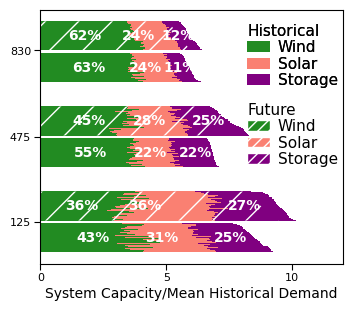

In [50]:
cc=0
var='capacity'
sces=['historic','rcp85hotter']
fig,ax_bar = plt.subplots(1,1,figsize=(3.9,3.3),frameon=False)
nsce=len(sces)
for ir in range(3):
    ISO=ISOs[ir]
    sdata=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
    sdata['capacity_strg']=sdata['capacity_strg']/4 # power capacity
    hist_load=get_df(sdata,ny=ny,scenario='historic',cg=cc)['total_load']/8760
    hist_load=hist_load.mean()

    for tech in techs_all:
        sdata[f'{var}_{tech}']=sdata[f'{var}_{tech}']/hist_load
    sdata['total_capacity']=sdata[[f'{var}_{tech}' for tech in techs_all]].sum(axis=1)    

    for irr in range(nsce):
        sce=sces[irr]
        cp_data=get_df(sdata,ny=ny,scenario=sce,cg=cc/100)
        print(len(cp_data))      
        cp_data=cp_data.sort_values('total_capacity',ascending=False)
        cu1=np.zeros(maxsce)
        for tech in techs_all:
            if (cc==0)&(tech=='CCGT'):
                continue
            toplot=cp_data[f'{var}_{tech}']
            if sce=='historic':
                p = ax_bar.barh(np.arange((maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr,(maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr+maxsce,1),toplot, 1,
                                color=colorpalattes[tech],
                                left=cu1)
            else:
                p = ax_bar.barh(np.arange((maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr,(maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr+maxsce,1),toplot, 1,
                                facecolor=colorpalattes[tech],left=cu1)
            meanr=toplot/cp_data['total_capacity']*100
            meanr=meanr.mean()
            
            
            if tech=='solar-UPV':
                x=cu1[int(maxsce/2+1)]+toplot.values[int(maxsce/2+1)]*0.25
            else:
                x=cu1[int(maxsce/2+1)]+toplot.values[int(maxsce/2+1)]*0.5
            ax_bar.text(x,(maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr+maxsce/2,"%d"%(meanr)+"%",ha='center',va='center',color='white',fontsize=10,fontweight='bold')
            cu1+=toplot.values
    ymin=np.arange((maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr,(maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr+maxsce,1).min()
    ymax=np.arange((maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr,(maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr+maxsce,1).max()
    ax_bar.add_patch(Polygon([(0, ymin), (0, ymax), (cu1.mean()*0.85, ymax), (cu1.mean(), ymin)],linewidth=0,    
                                 hatch='/', facecolor='none', edgecolor='white', zorder=2,alpha=1))
               
ax_bar.set_ylabel('')
ax_bar.set_yticks([125,475,830])
#ax_bar.set_yticklabels(ISOs,fontsize=10,fontweight='bold')

ax_bar.set_xlim([0,12])
ax_bar.set_xticks(np.arange(0,15,5))
ax_bar.set_xlabel('System Capacity/Mean Historical Demand',fontsize=10)

colors = {key:colorpalattes[key] for key in techs_all}
if cc==0:
    colors.pop('CCGT')
legend_patched = [mpatches.Patch(facecolor=colors[key], hatch='///',edgecolor='white', label=tech_names[key]) for key in colors.keys()]
legend_solid = [mpatches.Patch(facecolor=colors[key], label=tech_names[key]) for key in colors.keys()]
lg_patched = ax_bar.legend(handles=legend_patched,loc='upper right', title="Future", labelspacing=0.1,fontsize=11,title_fontsize=11,
                            frameon=False,handlelength=1.5,alignment='left',handletextpad=0.5,bbox_to_anchor=(1.03, 0.69))
lg_solid = ax_bar.legend(handles=legend_solid, loc='upper right',title="Historical", labelspacing=0.1,fontsize=11,title_fontsize=11,
                            frameon=False, handlelength=1.5,alignment='left',handletextpad=0.5,bbox_to_anchor=(1.03, 1.0))
ax_bar.add_artist(lg_patched)
ax_bar.add_artist(lg_solid)

plt.savefig(f'{figdir}/capacity_{cc}.png',bbox_inches='tight',dpi=300)
plt.show()

## Schematic figure

In [21]:
ISO='ISONE'
sce='historic'
eid=1
cc=0

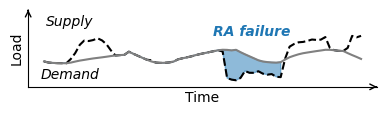

In [23]:
DF_LL = pd.read_csv('%s/dispatch/Results_%s_%s4/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv' %
                            (mdir, ISO, demandsce,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce,1.00))
DF_LL=get_date(DF_LL,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
A=DF_LL.loc['2012-07-29 00:00:00-05:00':'2012-07-31 23:00:00-05:00'].copy()
A['prod_RE']=A['prod_solar-UPV']+A['prod_wind-onshore']
A['prod']=A['prod_solar-UPV']+A['prod_wind-onshore']+A['sDis']

fig, axs = plt.subplots(1, 1, figsize=(4.5, 1))
axs.plot(A.index,A['prod'],color='black',linestyle='--')
axs.plot(A.index,A['demand'],color='grey')
axs.set_yticks([])
#axs.set_xticks(pd.date_range(start='2012-07-29 12:00:00-05:00', end='2012-07-31 23:00:00-05:00', freq='24h'))
#axs.set_xticklabels(['Jul29 12:00', 'Jul30 12:00', 'Jul31 12:00'], fontsize=8)
axs.set_xticks([])
axs.fill_between(A.index, A['demand'], A['prod'], where=(A['demand'] > A['prod_RE']), color='tab:blue', alpha=0.5)
#axs.fill_between(pd.date_range(start='2012-07-29 00:00:00-05:00', end='2012-07-29 06:00:00-05:00', freq='1H'), A['demand'], A['prod'], where=(A['demand'] > A['prod_RE']), color='tab:blue', alpha=0.5)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(True)
axs.spines['bottom'].set_visible(True)
axs.set_ylim(-1000, 40000)
#arrow at the end of axes
axs.annotate('', xy=(1, 0), xytext=(0.99, 0),xycoords='axes fraction',
            arrowprops=dict(arrowstyle='->', lw=1))
axs.annotate('', xy=(0, 1), xytext=(0, 0.99),xycoords='axes fraction',
            arrowprops=dict(arrowstyle='->', lw=1))

axs.text(0.12, 0.15, 'Demand', ha='center', va='center', transform=axs.transAxes, 
         fontdict={'fontsize': 10, 'color': 'black', 'style': 'italic'})
axs.text(0.12, 0.85, 'Supply', ha='center', va='center', transform=axs.transAxes, 
         fontdict={'fontsize': 10, 'color': 'black', 'style': 'italic'})
axs.text(0.64, 0.72, 'RA failure', ha='center', va='center', transform=axs.transAxes, 
         fontdict={'fontsize': 10, 'color': 'tab:blue', 'style': 'italic','weight':'bold'})
#set background color
axs.set_xlabel('Time',fontsize=10)
axs.set_ylabel('Load',fontsize=10)
axs.set_facecolor('None')
plt.savefig(f'{figdir}/drought_time.pdf',bbox_inches='tight',dpi=300)
plt.show()

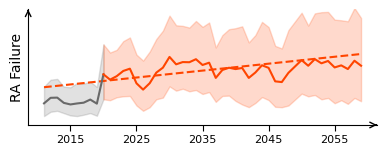

In [53]:
cc=0
fig, axs = plt.subplots(1, 1, figsize=(4.5, 1.5))
var='occ'
vars=['Occ','DurMax','MaxMagEvent']
vars_labels={'Occ':'Occurence','DurMax':'Duration','MaxMagEvent':'Severity'}
vars_labels_units={'Occ':'[-]','DurMax':'[hrs]','MaxMagEvent':'[GW]'}
sce='rcp85hotter'
ISO='ISONE'


hist=pd.read_csv(f'{anadir}/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,'historic'))
hist =hist[(hist['Year']!=2010) & (hist['Year']!=2049)]
minyear=hist['Year'].min()
maxyear=hist['Year'].max() 

new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
hist=hist.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
hist=hist.groupby(['id','Year']).sum(numeric_only=True)
future=hist
for pid in range(1,5):
    futuretmp = pd.read_csv(f'{anadir}/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_%d.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce,pid))
    futuretmp =futuretmp[(futuretmp['Year']!=2010) & (futuretmp['Year']!=2049)]
    minyear=futuretmp['Year'].min()
    maxyear=futuretmp['Year'].max()
    new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
    futuretmp=futuretmp.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
    futuretmp=futuretmp.groupby(['id','Year']).sum(numeric_only=True)
    future=pd.concat([future,futuretmp])
yearmean=future.rolling(window=7).mean(numeric_only=True).dropna().reset_index()
#sns.lineplot(data=yearmean,x='Year',y=var,ax=axs,legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
grouped=yearmean.groupby('Year').mean().reset_index()
X = grouped['Year'].values.reshape(-1, 1)
y=grouped[var].values
model=TheilSenRegressor().fit(X, y)
y_pred = model.predict(X)
slope = model.coef_[0]
mad = median_abs_deviation(y, scale='normal')
slope_std = mad / (np.sqrt(len(y)) * np.std(X)) 
mk_result = mk.original_test(y)
p_value = mk_result.p
axs.plot(grouped['Year'],y_pred,label=f'slope={slope:.2f}, p={p_value:.2f}',color=colorpalattes[sce],linestyle='--')
stars=get_sig_stars(p_value)

sns.lineplot(data=yearmean[yearmean['Year']<2021],x='Year',y='occ',ax=axs,legend=False,errorbar=('pi', 90),color=colorpalattes['historic'])
sns.lineplot(data=yearmean[yearmean['Year']>=2020],x='Year',y='occ',ax=axs,legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
axs.set_ylim(0,50)
axs.set_ylabel('RA Failure')
axs.set_xlabel('')
axs.set_yticks([])
axs.set_xticks([2015, 2025, 2035, 2045, 2055])
axs.annotate('', xy=(1, 0), xytext=(0.99, 0),xycoords='axes fraction',
            arrowprops=dict(arrowstyle='->', lw=1))
axs.annotate('', xy=(0, 1), xytext=(0, 0.99),xycoords='axes fraction',
            arrowprops=dict(arrowstyle='->', lw=1))
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(True)
axs.spines['bottom'].set_visible(True)
plt.savefig(f'{figdir}/drought_evolve.pdf',bbox_inches='tight',dpi=300)
plt.show()

# mean

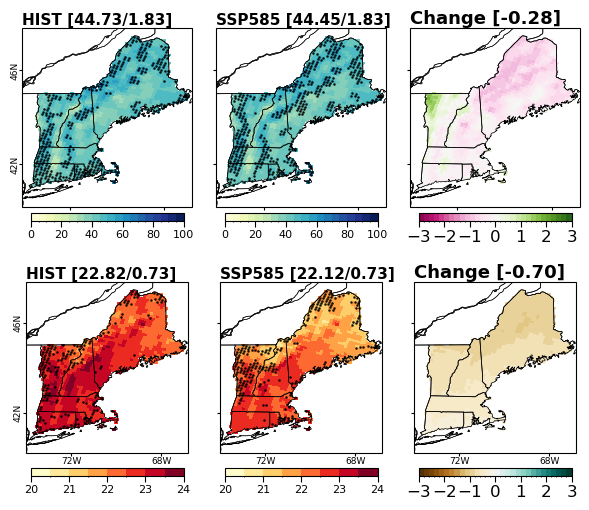

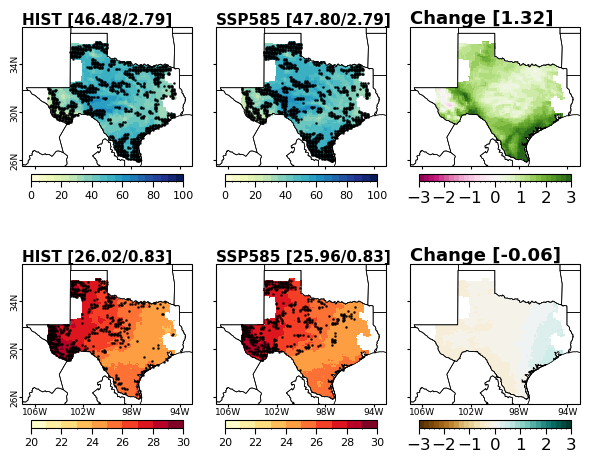

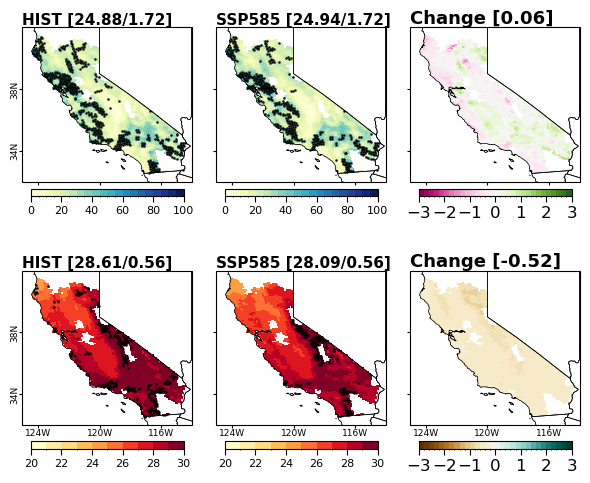

In [54]:
import scipy.stats as stats

scenarios=['historic','rcp85hotter']
resources=['wind','solar']
resource_techs={'wind':'wind-onshore','solar':'solar-UPV'}
ISOs=["ISONE","ERCOT","CAISO"]
cc=0
cmp_windcf={'cmp':cmaps.MPL_YlGnBu,'levels':np.arange(0, 105, 5),'ticks':np.arange(0, 120, 20)}
cmp_windcf_diff={'cmp':cmaps.MPL_PiYG,'levels':np.arange(-3,3.2,0.2),'ticks':np.arange(-3,4,1)}
cmp_solarcf_diff={'cmp':cmaps.MPL_BrBG,'levels':np.arange(-3,3.2,0.2),'ticks':np.arange(-3,4,1)}
for ISO in ISOs:
    fig,axs=plt.subplots(2,3,figsize=(6,5.2),subplot_kw={'projection': ccrs.PlateCarree()})
    if ISO == 'ISONE':
        cmp_solarcf={'cmp':cmaps.MPL_YlOrRd,'levels':np.arange(20, 24.5, 0.5),'ticks':np.arange(20, 25, 1)}
    elif ISO == 'ERCOT':
        cmp_solarcf={'cmp':cmaps.MPL_YlOrRd,'levels':np.arange(20, 31, 1),'ticks':np.arange(20, 32, 2)}

    for ir in range(2):
        resource=resources[ir]
        hist = xr.open_dataset("%s/historic/%s/%s/%s_gen_cf_annualmean.nc" % (metdir,resource,ISO,resource))['capacity_factor'].squeeze()
        future=xr.open_dataset("%s/%s/%s/%s/%s_gen_cf_annualmean.nc" % (metdir,scenarios[1],resource,ISO,resource))['capacity_factor'].squeeze()

        locations_hist=pd.read_csv('%s/investment/Results_%s_%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_grouped.csv'%
                            (mdir, ISO, demandsce,ny, demandsce,ISO, cc, land, mdl,'historic', resource_techs[resource]))
        locations_hist=locations_hist.set_index(['lat','lon'])

        locations_future=pd.read_csv('%s/investment/Results_%s_%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_grouped.csv'%
                            (mdir, ISO, demandsce,ny, demandsce,ISO, cc, land, mdl,'rcp85hotter', resource_techs[resource]))
        locations_future=locations_future.set_index(['lat','lon'])
        locations_hist=locations_hist.reset_index()

        locations_hist=locations_hist[(locations_hist['capacity']>0)]
        mean_location_hist=locations_hist['capacity'].quantile(0.3)
        locations_hist=locations_hist[(locations_hist['capacity']>mean_location_hist)]
        locations_future=locations_future.reset_index()
        locations_future=locations_future[(locations_future['capacity']>0)]
        mean_location_future=locations_future['capacity'].quantile(0.3)
        locations_future=locations_future[(locations_future['capacity']>mean_location_future)]

        mean_hist=hist.mean(dim='Time')
        std_hist=hist.std(dim='Time')
        mean_future=future.mean(dim='Time')
        signal=mean_future-mean_hist
        SNR=signal/std_hist
        
        SNR=xr.where((SNR>1)|(SNR<-1),1,np.nan)
      
        for ic in range(3):
            setupmapbg(axs[ir][ic],ISO)

        if resource=='wind':
            cmp=cmp_windcf
        else:
            cmp=cmp_solarcf
        cmp['norm']=BoundaryNorm(cmp['levels'],ncolors=cmp['cmp'].N,clip=True)
        cf1=axs[ir][0].pcolormesh(mean_hist['lon'],mean_hist['lat'],mean_hist*100,cmap=cmp['cmp'],norm=cmp['norm'])
        cf2=axs[ir][1].pcolormesh(mean_future['lon'],mean_future['lat'],mean_future*100,cmap=cmp['cmp'],norm=cmp['norm'])
        axs[ir][0].scatter(locations_hist['lon'],locations_hist['lat'],s=0.8,marker='o',c='black',alpha=0.8)
        axs[ir][1].scatter(locations_future['lon'],locations_future['lat'],s=0.8,marker='o',c='black',alpha=0.8)
        if ir==0:
            pad=0.03
        else:
            pad=0.07
        shrink=0.9
        plt.colorbar(cf1,ax=axs[ir][0],orientation='horizontal',pad=pad,shrink=shrink,ticks=cmp['ticks'])
        plt.colorbar(cf2,ax=axs[ir][1],orientation='horizontal',pad=pad,shrink=shrink,ticks=cmp['ticks'])

        setsubtitle(axs[ir][0],"%s [%.2f/%.2f]" % (scenario_labels['historic'],mean_hist.mean()*100,std_hist.mean()*100))
        setsubtitle(axs[ir][1],"%s [%.2f/%.2f]" % (scenario_labels[scenarios[1]],mean_future.mean()*100,std_hist.mean()*100))
        if resource=='wind':
            cmp_diff=cmp_windcf_diff
        else:
            cmp_diff=cmp_solarcf_diff
        cmp_diff['norm']=BoundaryNorm(cmp_diff['levels'],ncolors=cmp_diff['cmp'].N,clip=True)
        cf3 = axs[ir][2].pcolormesh(signal['lon'],signal['lat'],signal*100,cmap=cmp_diff['cmp'],norm=cmp_diff['norm'])
        #sr=axs[ir][2].scatter(SNR['lon'],SNR['lat'],s=SNR,marker='x',c='black',edgecolors='black',linewidths=0.2)
        #con=axs[ir][ic].scatter(conf['lon'],conf['lat'],s=conf,marker='o',c='black',edgecolors='black',linewidths=0.08)

        setsubtitle(axs[ir][2],"Change [%.2f]" % (signal.mean()*100),subt_fontsize=13)
        cbar =plt.colorbar(cf3,ax=axs[ir][2],orientation='horizontal',pad=pad,shrink=shrink,ticks=cmp_diff['ticks'])
        cbar.ax.tick_params(labelsize=12)
        for ic in range(3):
            setup_map_panel_ticks(axs[ir][ic],ir,ic,2,'','')

    plt.tight_layout()
    plt.savefig(f'{figdir}/mean_cf_%s.pdf'%ISO,bbox_inches='tight',dpi=300)
    plt.show()


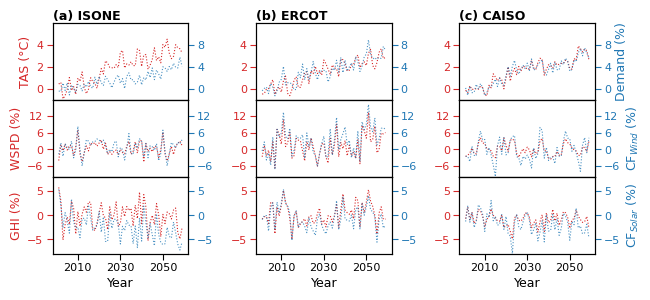

In [56]:
sce='rcp85hotter'
ISOs_a={'ISONE':'ISNE','ERCOT':'ERCO','CAISO':'CISO'}
vars=['T2','WSPD','SWDOWN']
var_label={'T2':'TAS (°C)','WSPD':'WSPD (%)','SWDOWN':'GHI (%)'}
fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(7, 3))
for ic in range(3):
    ISO=ISOs[ic]
    for sce in ['rcp85hotter']:
        met=pd.read_csv(f'/orcd/nese/mhowland/001/lyqiu/GODEEP/TGW/Meteorology/ISOmean/{sce}_ssp5/{ISOs_a[ISO]}_WRF_Hourly_Mean_Meteorology.csv')
        met['Time_UTC']=pd.to_datetime(met['Time_UTC'])
        met['T2']=met['T2']-273.15  
        met['Year']=met['Time_UTC'].dt.year
        met=met[met['Year']>2000]
        met_mean_hist=met[met['Year']<2010][vars].mean(numeric_only=True)
        met=met.set_index('Year')
        met=met[vars]
        met['WSPD']=(met['WSPD']-met_mean_hist['WSPD'])/met_mean_hist['WSPD']*100
        met['SWDOWN']=(met['SWDOWN']-met_mean_hist['SWDOWN'])/met_mean_hist['SWDOWN']*100
        met['T2']=met['T2']-met_mean_hist['T2']
        met_mean=met.reset_index().groupby(['Year']).mean(numeric_only=True).reset_index()
        met_mean_smooth=met_mean.rolling(window=5).mean(numeric_only=True).dropna().reset_index()

        cf_wind_anomaly=pd.read_csv(f'/orcd/nese/mhowland/001/lyqiu/GODEEP/data/{sce}/wind/{ISO}/wind_gen_cf_anomaly_fldmean.csv')
        cf_solar_anomaly=pd.read_csv(f'/orcd/nese/mhowland/001/lyqiu/GODEEP/data/{sce}/solar/{ISO}/solar_gen_cf_anomaly_fldmean.csv')
        demand_anomaly=pd.read_csv(f'/orcd/nese/mhowland/001/lyqiu/GODEEP/Demand/Demand_TELL/outputs/mlp_output/{ISO}_{sce}_demand_anomaly.csv')
        cf_wind_smooth=cf_wind_anomaly.rolling(window=5).mean(numeric_only=True).dropna().reset_index()
        cf_solar_smooth=cf_solar_anomaly.rolling(window=5).mean(numeric_only=True).dropna().reset_index()
        demand_smooth=demand_anomaly.rolling(window=5).mean(numeric_only=True).dropna().reset_index()
        for ir in range(3):
            vara=vars[ir]
            axs[ir][ic].plot(met_mean['Year'],met_mean[vara],linestyle=linestyles[sce],color='tab:red',linewidth=0.8)
            if ir==0:
                data=demand_anomaly
                var='Load'
                varn='Demand (%)'
            elif ir==1:
                data=cf_wind_anomaly
                var='cf'
                varn=r'CF$_{Wind}$ (%)'
            elif ir==2:
                data=cf_solar_anomaly
                var='cf'
                varn=r'CF$_{Solar}$ (%)'
            ax2=axs[ir][ic].twinx()
            ax2.plot(data['Year'],data[var],linestyle=linestyles[sce],color='tab:blue',linewidth=0.8,alpha=0.8)
            if ic==0:
                axs[ir][ic].set_ylabel(var_label[vara],fontsize=9,color='tab:red')
            else:
                axs[ir][ic].set_ylabel('')
            if ic==2:
                ax2.set_ylabel(varn,fontsize=9,color='tab:blue')
            else:
                ax2.set_ylabel('')
            
            
            if ir==2:
                axs[ir][ic].set_xlabel('Year',fontsize=9)
                axs[ir][ic].set_xticks([2010,2030,2050])
            else:
                axs[ir][ic].set_xticks([])
                axs[ir][ic].set_xlabel('')
            axs[ir][ic].tick_params(axis='y', labelsize=8,labelcolor='tab:red',color='tab:red')
            axs[ir][ic].tick_params(axis='x', labelsize=8)
            ax2.tick_params(axis='both', labelsize=8,labelcolor='tab:blue',color='tab:blue')

            if ir==0:
                axs[ir][ic].set_yticks(np.arange(0, 6, 2))
                axs[ir][ic].set_ylim(-1, 6)
                ax2.set_ylim(-2, 12)
                ax2.set_yticks(np.arange(0,12, 4))
            elif ir==1:
                axs[ir][ic].set_yticks(np.arange(-6, 18, 6))
                axs[ir][ic].set_ylim(-10, 18)
                ax2.set_ylim(-10, 18)
                ax2.set_yticks(np.arange(-6, 18, 6))
            elif ir==2:
                axs[ir][ic].set_yticks(np.arange(-5,10, 5))
                axs[ir][ic].set_ylim(-8, 8)
                ax2.set_ylim(-8, 8)
                ax2.set_yticks(np.arange(-5,10, 5))
            if ir==0:
                setsubtitle(axs[ir][ic],ISO,ni=ic,subt_fontsize=9)
plt.subplots_adjust(hspace=0, wspace=0.5)
plt.savefig('%s/met_anomaly_%s.pdf'%(figdir,sce),bbox_inches='tight',dpi=300)


# Energy Droughts

In [47]:

maxsce=120
cc = 0
dailyhh = 3
hourlyhh = 1
invsce='historic'
sces=['historic','rcp85hotter','rcp45hotter']
nsce = len(sces)
demandsce='mlp'
ny=3
land=0

## seasonal-hourly statistics of load and demand 

In [25]:
def get_stats(ifile,ta,ISO,ofile_prefix):
    DF_LL= pd.read_csv(ifile)
    DF_LL['NL']=DF_LL['demand']-DF_LL['prod_solar-UPV']-DF_LL['prod_wind-onshore']
    DF_LL['NL_zero']=DF_LL['NL'].apply(lambda x: 0 if x<0 else x)
    DF_LL=get_date(DF_LL,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
    DF_LL['cf_solar-UPV']=DF_LL['prod_solar-UPV']/ta['capacity_solar-UPV'].values*100 #in percentage
    DF_LL['cf_wind-onshore']=DF_LL['prod_wind-onshore']/ta['capacity_wind-onshore'].values*100
    DF_LL_mean=DF_LL.groupby(['Month','Hour']).mean(numeric_only=True)
    DF_LL_mean.reset_index().to_csv('%smean.csv' % (ofile_prefix))
    DF_LL_std=DF_LL.groupby(['Month','Hour']).std(numeric_only=True)
    DF_LL_std.reset_index().to_csv('%sstd.csv' %(ofile_prefix))
    DF_LL_corr=DF_LL.groupby(['Month','Hour']).corr(numeric_only=True)
    DF_LL_corr.reset_index().to_csv('%scorr.csv' % (ofile_prefix))

In [60]:
cc=0   
for ic in range(3):
    ISO=ISOs[ic]
    sdata=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
    for sce in ['rcp85hotter','historic','rcp45hotter']:
        pool = multiprocessing.Pool(48)
        results=[]
        for eid in range(1,maxsce+1):
            ofile_prefix='%s/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonth' %(anadir,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00)            
            ifile='%s/dispatch/Results_%s_%s4/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv'%(mdir, ISO, demandsce,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00)
            ta=get_df(sdata,ny=ny,ensid=eid,scenario='historic',cg=cc/100)
            if len(ta)!=1:
                print(len(ta))
            results.append(pool.apply_async(get_stats, args=(ifile,ta,ISO,ofile_prefix)))
        pool.close()
        pool.join()

## statistics of droughts

In [22]:
def get_LL(x, threshold=1, exceed=True, lag=False):
    if isinstance(x, pd.Series):
        df = pd.DataFrame({'x': x})
    elif isinstance(x, pd.DataFrame):
        df = x.copy()
    else:
        raise ValueError("Input 'x' should be a pandas Series or DataFrame.")

    df = df.reset_index(drop=True)  # Remove NaNs and reset index
    # Detect threshold exceedance
    df['occ'] = (df['x'] > threshold).astype(int) if exceed else (df['x'] < threshold).astype(int)

    # Apply lag if required
    if lag:
        df['occ'] = (df['occ'] | ((df['occ'].shift(1) == 1) & (df['x'].shift(1) * df['x'] > 0))).astype(int)

    # Identify event groups
    df['event_group'] = (df['occ'].diff() == 1).cumsum()
    df.loc[df['occ'] == 0, 'event_group'] = None  # Remove non-event indices

    # Compute duration and magnitude for each event
    event_stats = df.groupby('event_group').agg(
        dur=('occ', 'sum'),
        mag=('x', lambda s: abs(s).sum())
    ).dropna()

    # Ensure proper data type for assignments
    df[['dur', 'mag']] = 0.0  # Explicitly initialize as float

    first_occurrences = df.groupby('event_group').head(1).index  # Get first indices of events
    
    # Map event stats to first occurrences and convert to float
    df.loc[first_occurrences, 'dur'] = df.loc[first_occurrences, 'event_group'].map(event_stats['dur'].astype(float))
    df.loc[first_occurrences, 'mag'] = df.loc[first_occurrences, 'event_group'].map(event_stats['mag'].astype(float))

    return df

In [23]:
def drough_stat(df_drought,length,thres,eid,ny,sce):
    drought_selected=df_drought[df_drought['dur'] >= thres]
    drought_selected=drought_selected.copy()
    occ=len(drought_selected)/ny # occurrence per year
    prob=drought_selected['dur'].sum()/length*100 #probability of hourly drought
    dur_mean =drought_selected['dur'].mean() #mean duration of drought
    dur_max =drought_selected['dur'].max() #max duration of drought
    drought_selected['magmean'] = drought_selected['mag']/drought_selected['dur'] # mean magnitude of drought (MW/hour)
    mag_mean= drought_selected['magmean'].mean() #MW/hour
    mag_max= drought_selected['mag'].max() #MW/event
    mag_sum= drought_selected['mag'].sum()/ny #MW
    df=pd.DataFrame({'Occ':occ,'Prob':prob,'DurMean':dur_mean,'DurMax':dur_max,
                    'MeanMagHour':mag_mean,'MaxMagEvent':mag_max,'MagSum':mag_sum,
                    'MinDur':thres,'id':eid,'sce':sce},index=[eid])
    return df

def drought_heatmap(drought_selected,eid,sce,group=['Month','Hour','Year']):
    heatmap_mean=drought_selected.groupby(group).mean(numeric_only=True)
    heatmap_mean=heatmap_mean[['dur','mag']]
    heatmap_mean=heatmap_mean.rename(columns={'dur':'DurMean','mag':'MagMean'}) #mean duration and magnitude per event
    heatmap_sum=drought_selected.groupby(group).sum()
    heatmap_sum=heatmap_sum[['occ','dur','mag']]
    heatmap_sum=heatmap_sum.rename(columns={'occ':'Occ','dur':'DurSum','mag':'MagSum'}) #sum duration and magnitude per event
    heatmap=pd.merge(heatmap_mean,heatmap_sum,left_index=True,right_index=True)
    
    return heatmap

def get_drought_char(DF_LL,hourlyhh,ISO,eid,sce,var='LL'):
    if (var=='LL')|(var=='LL_new'):
        df_drought=get_LL(DF_LL[var],threshold=0,exceed=True,lag=False)
    elif var=='sDis':
        df_drought=get_LL(DF_LL[var],threshold=0,exceed=False,lag=False)
    df_drought['time']=DF_LL['dat']
    ###update!!!
    #hourly drought
    time_utc=pd.to_datetime(df_drought['time'],format='%Y-%m-%d %H:%M:%S')
    minyear=time_utc.dt.year.min()
    maxyear=time_utc.dt.year.max()
    df_drought=get_date(df_drought,datv='time',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
    df_drought=df_drought[(df_drought['Year']>=minyear) & (df_drought['Year']<=maxyear)].copy()
    drought_selected=df_drought[df_drought['dur'] >= hourlyhh]
    heatmap=drought_heatmap(drought_selected,eid,sce,group=['Month','Hour','Year']).reset_index()
    
    new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24)],names=['Year','Month','Hour'])
    heatmap=heatmap.set_index(['Year','Month','Hour']).reindex(new_index).fillna(0).reset_index()

    heatmap['sce']=sce
    heatmap['id']=eid
    heatmap.loc[heatmap['Occ']==0,['DurSum','DurMean','MagMean','MagSum']]=np.nan
    heatmap_annual=drought_heatmap(drought_selected,eid,sce,group=['Year']).reset_index()
    new_index=pd.Index(range(minyear,maxyear+1),name='Year')
    heatmap_annual=heatmap_annual.set_index(['Year']).reindex(new_index).fillna(0).reset_index()
    heatmap_annual['sce']=sce
    heatmap_annual['id']=eid
    heatmap_annual.loc[heatmap_annual['Occ']==0,['DurSum','DurMean','MagMean','MagSum']]=np.nan

    return heatmap,heatmap_annual

In [69]:
sces=['rcp45hotter']
cc=0
for ISO in ISOs:
    for ir in range(1):
        sce=sces[ir]
        if sce == 'historic':
            DF_heatmap=pd.DataFrame()
            DF_heatmap_annual=pd.DataFrame()
            pool      = multiprocessing.Pool(60)
            results=[]
            for eid in range(1, maxsce+1):
                DF_LL = pd.read_csv('%s/dispatch/Results_%s_%s4/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv' %
                            (mdir, ISO, demandsce,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce,1.00))
                results.append(pool.apply_async(get_drought_char, (DF_LL,hourlyhh,ISO,eid,sce)))
            pool.close()
            pool.join()
            for res in results:
                heatmap,heatmap_annual=res.get()
                DF_heatmap=pd.concat([DF_heatmap,heatmap])
                DF_heatmap['id']=DF_heatmap['id'].round(0).astype(int)
                DF_heatmap_annual=pd.concat([DF_heatmap_annual,heatmap_annual])   
                DF_heatmap_annual['id']=DF_heatmap_annual['id'].round(0).astype(int)
            prefix= '%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,sce)
            DF_heatmap.to_csv('%s_heatmap.csv'%(prefix))
            DF_heatmap_annual.to_csv('%s_heatmap_annual.csv'%(prefix))
        else:
            prefix= '%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,sce)
            for pid in range(1,5):
                DF_heatmap=pd.DataFrame()
                DF_heatmap_annual=pd.DataFrame()
                pool      = multiprocessing.Pool(60)
                results=[]
                for eid in range(1, maxsce+1):
                    print(eid)
                    DF_LL = pd.read_csv('%s/dispatch/Results_%s_%s%d/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv' %
                        (mdir, ISO, demandsce,pid,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce,1.00))
                    results.append(pool.apply_async(get_drought_char, (DF_LL,hourlyhh,ISO,eid,sce)))
                pool.close()
                pool.join()
                for res in results:
                    heatmap,heatmap_annual=res.get()
                    DF_heatmap=pd.concat([DF_heatmap,heatmap])
                    DF_heatmap['id']=DF_heatmap['id'].round(0).astype(int)
                    DF_heatmap_annual=pd.concat([DF_heatmap_annual,heatmap_annual])   
                    DF_heatmap_annual['id']=DF_heatmap_annual['id'].round(0).astype(int)
                DF_heatmap.to_csv('%s_heatmap_%d.csv'%(prefix,pid))
                DF_heatmap_annual.to_csv('%s_heatmap_annual_%d.csv'%(prefix,pid))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
8

## copula

In [72]:
def empirical_cdf_transform(values, reference):
    """Transforms values based on empirical CDF of a reference dataset."""
    return np.searchsorted(np.sort(reference), values, side='right') / len(reference)

def get_2dcopula(DF_LL_refname, DF_LLname, x, y, filterv, Z_xr_name,sce,eid,grid_points=np.linspace(0, 1, 101),output=True):
    DF_LL_ref=pd.read_csv(DF_LL_refname)
    DF_LL_ref['RE']=DF_LL_ref['prod_solar-UPV']+DF_LL_ref['prod_wind-onshore']           
    DF_LL_ref['LL_event']=DF_LL_ref['LL']>0
    DF_LL= pd.read_csv(DF_LLname)
    DF_LL['RE']=DF_LL['prod_solar-UPV']+DF_LL['prod_wind-onshore']
    DF_LL['LL_event']=DF_LL['LL']>0
    # Step 1: standardize anomalies using historical mean and std
    for var in [x, y]:
        DF_LL_ref[f'{var}_anomaly'] = (DF_LL_ref[var] - DF_LL_ref[var].mean()) / DF_LL_ref[var].std()
        DF_LL[f'{var}_anomaly'] = (DF_LL[var] - DF_LL_ref[var].mean()) / DF_LL_ref[var].std()
       
    # Historical copula percentiles
    u_hist = rankdata(DF_LL_ref[f'{x}_anomaly']) / (len(DF_LL_ref) + 1)
    v_hist = rankdata(DF_LL_ref[f'{y}_anomaly']) / (len(DF_LL_ref) + 1)

    # Future data mapped to historical copula percentiles
    u_future = empirical_cdf_transform(DF_LL[f'{x}_anomaly'], DF_LL_ref[f'{x}_anomaly'])
    v_future = empirical_cdf_transform(DF_LL[f'{y}_anomaly'], DF_LL_ref[f'{y}_anomaly'])
    
    # Kernel density estimation
    kde_hist = gaussian_kde(np.vstack([u_hist, v_hist]))  # Historical Density
    kde_future = gaussian_kde(np.vstack([u_future, v_future]))  # Future Density

    # Grid definition
    U_grid, V_grid = np.meshgrid(grid_points, grid_points)

    # Density evaluation on grid
    Z_hist = kde_hist(np.vstack([U_grid.ravel(), V_grid.ravel()])).reshape(U_grid.shape)
    Z_future = kde_future(np.vstack([U_grid.ravel(), V_grid.ravel()])).reshape(U_grid.shape)

    # Create xarray datasets
    Z_xr = xr.Dataset({'Z_hist': xr.DataArray(Z_hist, coords=[(x, grid_points), (y, grid_points)]),
                       'Z_future': xr.DataArray(Z_future, coords=[(x, grid_points), (y, grid_points)])})
    
    # Event points extraction based on filter condition
    hist_df=pd.DataFrame({x:u_hist[DF_LL_ref[filterv]],y:v_hist[DF_LL_ref[filterv]]})
    hist_df['sce']='historic'
    hist_df['id']=eid
    future_df=pd.DataFrame({x:u_future[DF_LL[filterv]],y:v_future[DF_LL[filterv]]})
    future_df['sce']=sce
    future_df['id']=eid
    points=pd.concat([hist_df,future_df])
    if output:
        Z_xr.to_netcdf(Z_xr_name)
        return points
    else:
        return points,Z_xr


In [ ]:
xns=['demand']
yns=['RE']
cases=['full','day','night']
cc=0
from cdo import *
cdo=Cdo()

for casename in cases[0:1]:
    if casename=='full':
        xns=['demand','demand','demand','prod_solar-UPV']
        yns=['RE','prod_solar-UPV','prod_wind-onshore','prod_wind-onshore']
        xns=['demand']
        yns=['RE']
    elif casename=='day':
        xns=['demand','demand','demand','prod_solar-UPV']
        yns=['RE','prod_solar-UPV','prod_wind-onshore','prod_wind-onshore']
    elif casename=='night':
        xns=['demand','demand']
        yns=['prod_wind-onshore']

    iparis=len(xns)
    for ii in range(iparis):
        xn=xns[ii]
        yn=yns[ii]
        for ISO in ISOs[1:2]:
            for sce in sces[1:2]:
                if (sce == 'historic'): 
                    continue
                pointfile='./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_points_%s_%s_%s.csv'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn,casename)
                # if not os.path.exists(pointfile):
                pool = multiprocessing.Pool(10)
                results=[]
                for eid in range(1, maxsce+1):
                    DF_LL_histname = '%s/dispatch/Results_%s_%s4/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv' %(mdir, ISO, 'mlp',ny, eid, 'mlp',ISO, cc, land, mdl,'historic','historic', 1.00)
                    DF_LL_name = '%s/dispatch/Results_%s_%s4/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv' %(mdir, ISO, demandsce,ny, eid, 'mlp',ISO, cc, land, mdl,'historic',sce,1.00)

                    # if casename=='day':
                    #     DF_LL_hist=DF_LL_hist[DF_LL_hist['prod_solar-UPV']>0]
                    #     DF_LL=DF_LL[DF_LL['prod_solar-UPV']>0]
                    # elif casename=='night':
                    #     DF_LL_hist=DF_LL_hist[DF_LL_hist['prod_solar-UPV']==0]
                    #     DF_LL=DF_LL[DF_LL['prod_solar-UPV']==0]

                    Z_xr_name='./Analysis_drought_free/OutSampleDispatch_sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_%s.nc'%(ny, eid, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn,casename)
                    results.append(pool.apply_async(get_2dcopula, (DF_LL_histname,DF_LL_name,xn,yn,'LL_event',Z_xr_name,sce,eid,np.linspace(0, 1, 101))))
                pool.close()
                pool.join()
                df=pd.DataFrame()
                for res in results:
                    outages=res.get()
                    df=pd.concat([df,outages])
                df.to_csv(pointfile)
                # cdo.ensmean(input='./Analysis_drought_free/OutSampleDispatch_sub%dyrs_ens*_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_%s.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn,casename),
                #     output='./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_%s.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn,casename))
                
                # points=pd.read_csv(pointfile)
                # hist_points=points[points['sce']=='historic']
                # kde_hist = gaussian_kde(np.vstack([hist_points[xn], hist_points[yn]]))
                # U_grid, V_grid = np.meshgrid(np.linspace(0, 1, 101), np.linspace(0, 1, 101))
                # kde_hist_z = kde_hist(np.vstack([U_grid.ravel(), V_grid.ravel()])).reshape(U_grid.shape)
                
                # future_points=points[points['sce']==sce]
                # kde_future = gaussian_kde(np.vstack([future_points[xn], future_points[yn]]))
                # kde_future_z = kde_future(np.vstack([U_grid.ravel(), V_grid.ravel()])).reshape(U_grid.shape)

                # Z_xr_points=xr.Dataset({'Z_hist': xr.DataArray(kde_hist_z, coords=[('U', np.linspace(0, 1, 101)), ('V', np.linspace(0, 1, 101))]),
                #                         'Z_future': xr.DataArray(kde_future_z, coords=[('U', np.linspace(0, 1, 101)), ('V', np.linspace(0, 1, 101))])})
                # Z_xr_points.to_netcdf('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_%s_points.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn,casename))


In [ ]:
xns=['demand']
yns=['RE']
cases=['full','day','night']
cc=0
from cdo import *
cdo=Cdo()

for casename in cases[0:1]:
    if casename=='full':
        xns=['demand','demand','demand','prod_solar-UPV']
        yns=['RE','prod_solar-UPV','prod_wind-onshore','prod_wind-onshore']
        xns=['demand']
        yns=['RE']
    elif casename=='day':
        xns=['demand','demand','demand','prod_solar-UPV']
        yns=['RE','prod_solar-UPV','prod_wind-onshore','prod_wind-onshore']
    elif casename=='night':
        xns=['demand','demand']
        yns=['prod_wind-onshore']

    iparis=len(xns)
    for ii in range(iparis):
        xn=xns[ii]
        yn=yns[ii]
        for ISO in ISOs:
            for sce in ['rcp45hotter']:
                if (sce == 'historic'): 
                    continue
                pointfile='./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_points_%s_%s_%s.csv'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn,casename)
                # if not os.path.exists(pointfile):
                results=[]
                for eid in range(1, maxsce+1):
                    print(eid)

                    DF_LL_hist_name = '%s/dispatch/Results_%s_%s4/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv' %(mdir, ISO, 'mlp',ny, eid, 'mlp',ISO, cc, land, mdl,'historic','historic', 1.00)

                    DF_LL_name = '%s/dispatch/Results_%s_%s4/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv' %(mdir, ISO, demandsce,ny, eid, 'mlp',ISO, cc, land, mdl,'historic',sce,1.00)


                    # if casename=='day':
                    #     DF_LL_hist=DF_LL_hist[DF_LL_hist['prod_solar-UPV']>0]
                    #     DF_LL=DF_LL[DF_LL['prod_solar-UPV']>0]
                    # elif casename=='night':
                    #     DF_LL_hist=DF_LL_hist[DF_LL_hist['prod_solar-UPV']==0]
                    #     DF_LL=DF_LL[DF_LL['prod_solar-UPV']==0]

                    Z_xr_name='%s/OutSampleDispatch_sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_%s.nc'%(anadir,ny, eid, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn,casename)
                    a=get_2dcopula(DF_LL_hist_name,DF_LL_name,xn,yn,'LL_event',Z_xr_name,sce,eid,np.linspace(0, 1, 101))
                    results.append(a)
                df=pd.concat(results)
                df.to_csv(pointfile)
                #cdo.ensmean(input='./Analysis_drought_free/OutSampleDispatch_sub%dyrs_ens*_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_%s.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn,casename),
                #    output='./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_%s.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn,casename))
                
                #points=pd.read_csv(pointfile)
                #hist_points=points[points['sce']=='historic']
                #kde_hist = gaussian_kde(np.vstack([hist_points[xn], hist_points[yn]]))
                #U_grid, V_grid = np.meshgrid(np.linspace(0, 1, 101), np.linspace(0, 1, 101))
                #kde_hist_z = kde_hist(np.vstack([U_grid.ravel(), V_grid.ravel()])).reshape(U_grid.shape)
                
                #future_points=points[points['sce']==sce]
                #kde_future = gaussian_kde(np.vstack([future_points[xn], future_points[yn]]))
                #kde_future_z = kde_future(np.vstack([U_grid.ravel(), V_grid.ravel()])).reshape(U_grid.shape)

                #Z_xr_points=xr.Dataset({'Z_hist': xr.DataArray(kde_hist_z, coords=[('U', np.linspace(0, 1, 101)), ('V', np.linspace(0, 1, 101))]),
                #                        'Z_future': xr.DataArray(kde_future_z, coords=[('U', np.linspace(0, 1, 101)), ('V', np.linspace(0, 1, 101))])})
                #Z_xr_points.to_netcdf('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_%s_points.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn,casename))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


## window process

In [29]:
def get_hourly_dots(checkt,DF_LL_ref,DF_LL,ISO,eid,sce,items,ext_var='dur'):
    data_dots_tt=pd.DataFrame()
    for ii in range(2):
        if ii==0:
           DF=DF_LL_ref.copy()
        else:
           DF=DF_LL.copy()
        
        DF=get_date(DF,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
        DF['prod_RE'] = (DF['prod_solar-UPV'] +DF['prod_wind-onshore'])
        DF['NL'] = (DF['demand']-DF['prod_RE'])
        DF=DF[items]

        if ii==0:
            meandemand= DF['demand'].mean()
        DF=DF/meandemand

        df_drought=get_LL(DF['LL'],threshold=0,exceed=True,lag=False)
        df_drought=df_drought.set_index(DF.index)
        DF=pd.merge(DF,df_drought[['dur']],left_index=True,right_index=True)

        selected = DF[DF[ext_var] >0].copy()
        datesunique = np.unique(selected.index)
        data_dots_tmp=[]
        for index in datesunique:
            target_date_index = DF.index.get_loc(index)
            period = DF.iloc[target_date_index - checkt: target_date_index + checkt+1].copy()
            if not (len(period)<2*checkt+1):
                period.loc[:,'tindex'] = np.arange(-checkt, checkt+1)
                data_dots_tmp.append(period)
        data_dots = pd.concat(data_dots_tmp)
        data_dots['eid']=eid
        if ii==0:
            data_dots['sce']='historic'
        else:
            data_dots['sce']=sce
        data_dots_tt=pd.concat([data_dots_tt,data_dots])
    return data_dots_tt


In [30]:
items = ["prod_solar-UPV", "prod_wind-onshore", "sDis", "demand",'prod_CCGT','LL']
cc=0
ncol=len(items)
nrow=len(ISOs)
ext_var='dur'
sces=['historic']
average="annual"

checkt=144
for sce in sces:
    for ir in range(3):
        ISO=ISOs[ir]
        hourly_dots_ens=pd.DataFrame()
        results = []
        for eid in range(1,121):
            print(eid)
            DF_LL_ref = pd.read_csv('%s/dispatch/Results_%s_%s4/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv' %
                                        (mdir, ISO, demandsce,ny, eid, demandsce,ISO, cc, land, mdl,'historic','historic',1.00))
            DF_LL = pd.read_csv('%s/dispatch/Results_%s_%s4/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load.csv' %
                            (mdir, ISO, demandsce,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce,1.00))
            tmp=get_hourly_dots(checkt, DF_LL_ref, DF_LL, ISO, eid, sce,items)
            tmp=tmp.groupby(['sce','tindex']).mean(numeric_only=True).reset_index()
            results.append(tmp)
        hourly_dots_ens=pd.concat(results)
        hourly_dots_ens.to_csv('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_hourly_dots_ensmean.csv'%(ny,demandsce,ISO,cc,land,mdl,'historic',sce,1.00))            

1


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


## figure

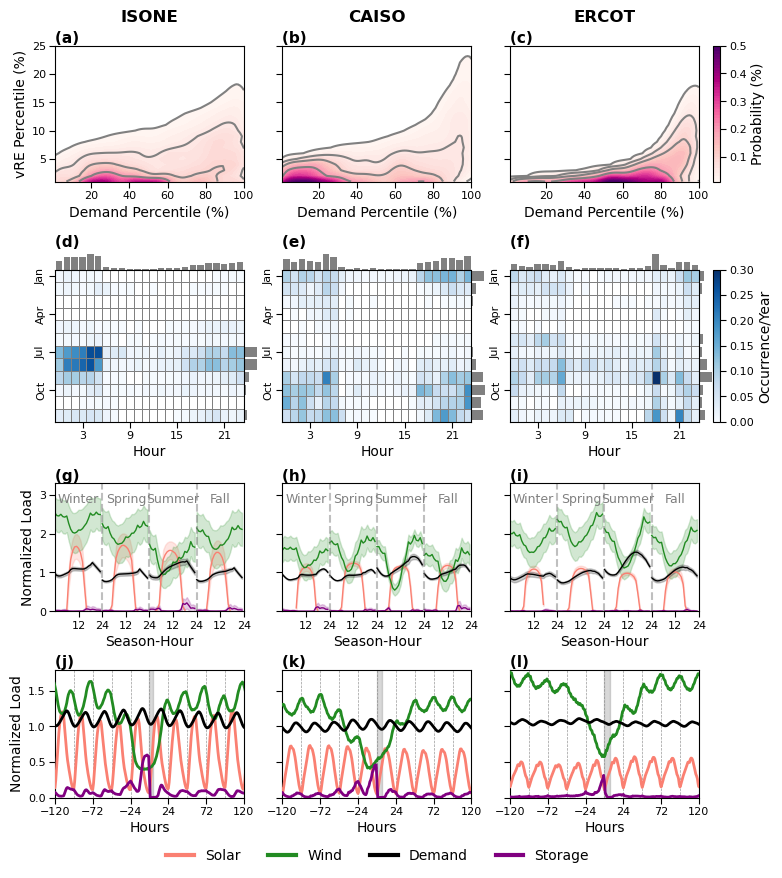

In [48]:
cc=0
items = ["prod_solar-UPV", "prod_wind-onshore", "demand",'sDis']
itemcolor={'prod_solar-UPV':'solar-UPV','prod_wind-onshore':'wind-onshore','demand':'demand','sDis':'strg'}
fig = plt.figure(figsize=(7,8))   
drought_dur={'ISONE':5,'CAISO':7,'ERCOT':7}
seasonns={1:'DJF',2:'MAM',3:'JJA',4:'SON'}
seasonns={1:'Winter',2:'Spring',3:'Summer',4:'Fall'}
nrow=4
sce='historic'
drought_var='Occ'
ncol=len(ISOs)
ylocs=[0.79,0.49,0.253,0.02]
heights=[0.17,0.19,0.16,0.16]
width=0.27

for ic in range(ncol):
    ISO=ISOs[ic]
    xloc=0.05+0.325*ic
    xn='demand'
    yn='RE'
    ir=0
    ax_joint=fig.add_axes((xloc, ylocs[ir], width, heights[ir]))
    
    points_xr=xr.open_dataset('%s/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full_points.nc'%(anadir,ny, 'mlp',ISO, cc, land, mdl,'rcp85hotter', 1.00,xn,yn))
    points_xr_period=points_xr['Z_hist']
    prob=points_xr_period/points_xr_period.sum()*100 # probability(%)
    prob=prob[1:101,1:101]
    U_grid, V_grid = np.meshgrid(np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 100))
    contour_hist = ax_joint.contourf(U_grid*100, V_grid*100,prob ,cmap=cmaps.MPL_RdPu,levels=np.arange(1, 51, 1)*0.01)
    ax_joint.contour(U_grid*100, V_grid*100, prob,colors='grey',levels=[0.01,0.05,0.1,0.2])

    if ic==0:
        ax_joint.set_ylabel("vRE Percentile (%)")
    else:
        ax_joint.set_ylabel('')
        ax_joint.set_yticklabels([])
    ax_joint.set_xlabel("Demand Percentile (%)")
    ax_joint.set_ylim(1,25)
    setsubtitle(ax_joint, f"", nrc=[ir, ic, nrow,ncol],pad=5)
    fig.text(xloc+width/2, 0.99, f"{ISO}", ha='center', fontsize=12, color='black', fontweight='bold')
    ir=2
    ax_generation = fig.add_axes((xloc, ylocs[ir], width, heights[ir]))
    heatmap_mean_ens=[]
    heatmap_std_ens=[]
    for eid in range(1,maxsce+1):
        DF_mean= pd.read_csv('%s/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthmean.csv' %
                                    (anadir,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00))
        DF_std= pd.read_csv('%s/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthstd.csv' %
                                    (anadir,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00))
        DF_mean['Season']=DF_mean['Month'].apply(get_season)
        DF_std['Season']=DF_std['Month'].apply(get_season)

        heatmap_mean = DF_mean.groupby(['Season','Hour']).mean(numeric_only=True)
        heatmap_mean=heatmap_mean.replace(0,np.nan)
        heatmap_mean['ens']=eid
        heatmap_mean_ens.append(heatmap_mean)

        heatmap_std = DF_std.groupby(['Season','Hour']).mean(numeric_only=True)
        heatmap_std=heatmap_std.replace(0,np.nan)
        heatmap_std['ens']=eid
        heatmap_std_ens.append(heatmap_std)
    heatmap_mean_ens=pd.concat(heatmap_mean_ens)
    heatmap_std_ens=pd.concat(heatmap_std_ens)
    heatmap_mean_ensmean=heatmap_mean_ens.groupby(['Season','Hour']).mean(numeric_only=True).reset_index()
    heatmap_std_ensmean=heatmap_std_ens.groupby(['Season','Hour']).mean(numeric_only=True).reset_index()
    mean_demand=heatmap_mean_ensmean['demand'].mean()
    for ss in range(1,5):
        toplot_mean=heatmap_mean_ensmean[heatmap_mean_ensmean['Season']==ss]
        toplot_mean=toplot_mean.copy()
        toplot_mean['Hour']=toplot_mean['Hour']+(ss-1)*24
        toplot_std=heatmap_std_ensmean[heatmap_std_ensmean['Season']==ss]
        toplot_std=toplot_std.copy()
        toplot_std['Hour']=toplot_std['Hour']+(ss-1)*24
        for item in items:
            if item=='sLev':
                continue
            toplot_mean[item]=toplot_mean[item]/mean_demand
            toplot_std[item]=toplot_std[item]/mean_demand
            ax_generation.plot(toplot_mean['Hour'],toplot_mean[item],color=colorpalattes[itemcolor[item]],linewidth=1)
            ax_generation.fill_between(x=toplot_mean['Hour'],y1=toplot_mean[item]-0.5*toplot_std[item],y2=toplot_mean[item]+0.5*toplot_std[item],
                                       color=colorpalattes[itemcolor[item]],alpha=0.2)
        ax_generation.text(12*(ss*2-1), 2.8, seasonns[ss], ha='center',fontsize=9, color='grey')
    
    ax_generation.set_xlim(0,96)
    ax_generation.set_ylim(0,3.3)
    ax_generation.set_xticks(np.arange(12,102,12))
    ax_generation.set_xticklabels([12,24,12,24,12,24,12,24])
    ax_generation.set_yticks(np.arange(0,4,1))

    # separate seasons
    for dh in [24,48,72]:
        ax_generation.axvline(dh,linestyle='dashed',color='grey',alpha=0.5)   
    setsubtitle(ax_generation, f"", nrc=[ir, ic, nrow,ncol],pad=5)

    if ic==0:
        ax_generation.set_ylabel('Normalized Load')
    else:
        ax_generation.set_ylabel('')
        ax_generation.set_yticklabels([])
    ax_generation.set_xlabel('Season-Hour')

    ir=1
    ax_drought=fig.add_axes((xloc, ylocs[ir], width, heights[ir]))
    DF_drought = pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,sce))

    tmp_mean=DF_drought.groupby(['Month','Hour']).mean(numeric_only=True)[[drought_var]]
    tmp_mean=tmp_mean.replace(0,np.nan)
    pivot_mean=tmp_mean.reset_index().pivot(index='Month',columns='Hour',values=drought_var)
    
    sns.heatmap(data=pivot_mean, cmap='Blues', cbar=False, linewidths=0.5, linecolor='grey', vmin=0, vmax=0.3, ax=ax_drought)
    ax_drought.set_xticks([3.5,9.5,15.5,21.5])
    ax_drought.set_xticklabels(['3','9','15','21'])
    ax_drought.set_yticks([0.5,3.5,6.5,9.5])
    ax_drought.set_yticklabels(['Jan','Apr','Jul','Oct'],rotation=90)

    ax_drought_position = ax_drought.get_position()
    ax_top=fig.add_axes((ax_drought_position.x0, ax_drought_position.y1, ax_drought_position.width, 0.02))
    sns.barplot(data=tmp_mean.reset_index().groupby('Hour').sum(),x='Hour',y=drought_var,ax=ax_top,color='grey')    
    ax_right=fig.add_axes((ax_drought_position.x1, ax_drought_position.y0, 0.02, ax_drought_position.height))
    sns.barplot(data=tmp_mean.reset_index().groupby('Month').sum(),x=drought_var,y='Month',ax=ax_right,orient='h',color='grey')
    
    for ax in [ax_top,ax_right]:
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_xticks([])
    ax_top.spines['bottom'].set_visible(True)
    ax_right.spines['left'].set_visible(True)    
    ax_drought.spines['left'].set_visible(True)
    ax_drought.spines['bottom'].set_visible(True)
    #subtitle
    setsubtitle(ax_drought, f"", nrc=[ir, ic, nrow,ncol],pad=20)

    ax_drought.set_ylabel('')
    ax_drought.set_xlabel('Hour')

    ir=3
    ax_process = fig.add_axes((xloc, ylocs[ir], width, heights[ir]))
    dots_ens=pd.read_csv('%s/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_hourly_dots_ensmean.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,'historic','historic',1.00))
    dots=dots_ens[dots_ens['sce']==sce]
    dots=dots.groupby(['tindex']).mean(numeric_only=True).reset_index()
    for ica in range(4):
        item=items[ica]        
        sns.lineplot(data=dots, x='tindex', y=item, 
                color=colorpalattes[itemcolor[item]], linewidth=2, zorder=110,
                linestyle=linestyles[sce],errorbar=None,ax=ax_process)
    ax_process.set_xticks(np.arange(-120,144,48))

    #make a shade for drought period
    ymin=0
    ymax=1.8
    ax_process.fill_between(x=[0,drought_dur[ISO]],y1=ymin,y2=ymax,color='grey',alpha=0.3)
    ax_process.set_ylim(ymin,ymax)
    for x in np.arange(-144,144+24,24):
        ax_process.axvline(x=x, color='grey', linewidth=0.5, linestyle='--',alpha=0.8)
    ax_process.set_xlim(-120,120)

    if ic==0:
        ax_process.set_ylabel('Normalized Load')
    else:
        ax_process.set_ylabel('')
        ax_process.set_yticklabels([])
    ax_process.set_xlabel('Hours')
    
    setsubtitle(ax_process, f"", nrc=[ir, ic, nrow,ncol],pad=5)


#colorbar
cbar_ax_joint = fig.add_axes([0.99,ylocs[0],0.01,heights[0]])
cbar_joint = fig.colorbar(ax_joint.collections[0], cax=cbar_ax_joint, orientation='vertical')
cbar_joint.set_label('Probability (%)')
cbar_ax_joint.set_yticks(np.arange(0.1, 0.6, 0.1))

#colorbar
cbar_ax = fig.add_axes([0.99,ylocs[1],0.01,heights[1]])
cbar = fig.colorbar(ax_drought.collections[0], cax=cbar_ax, orientation='vertical')
cbar.set_label('Occurrence/Year')

#legend
for item in items:
    ax_process.plot([], [], color=colorpalattes[itemcolor[item]], label=tech_names[itemcolor[item]],linewidth=3)
ax_process.legend(loc='upper center', bbox_to_anchor=(-0.7, -0.3), ncol=4, frameon=False)

plt.savefig(f'{figdir}/drought_character.pdf', bbox_inches='tight', dpi=300)


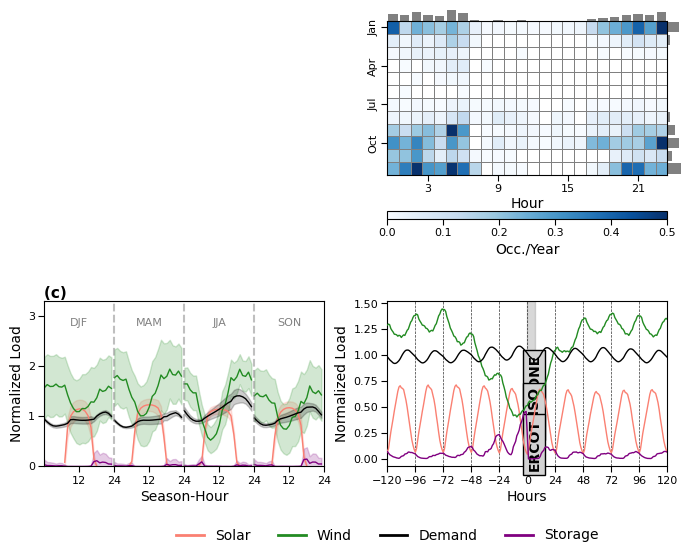

In [33]:
cc=0
items = ["prod_solar-UPV", "prod_wind-onshore", "demand",'sDis']
itemcolor={'prod_solar-UPV':'solar-UPV','prod_wind-onshore':'wind-onshore','demand':'demand','sDis':'strg'}
fig = plt.figure(figsize=(7,5.5))   
drought_dur={'ISONE':5,'CAISO':7,'ERCOT':7}
seasonns={1:'DJF',2:'MAM',3:'JJA',4:'SON'}
nrow=2
sce='historic'
drought_var='occ'
ncol=2
ylocs=[0.79,0.49,0.24,0.02]
heights=[0.19,0.21,0.18,0.18]
width=0.28

ISO='CAISO'

# ir=0
# ic=0
# xn='demand'
# yn='RE'
# ax_joint=fig.add_axes((0.01, 0.56,0.4, 0.30))
# points_xr=xr.open_dataset('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full_points.nc'%(ny, 'mlp',ISO, cc, land, mdl,'rcp85hotter', 1.00,xn,yn))
# points_xr_period=points_xr['Z_hist']
# prob=points_xr_period/points_xr_period.sum()*100 # probability(%)
# prob=prob[1:101,1:101]
# U_grid, V_grid = np.meshgrid(np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 100))
# contour_hist = ax_joint.contourf(U_grid*100, V_grid*100,prob ,cmap=cmaps.MPL_RdPu,levels=np.arange(1, 51, 1)*0.01)
# ax_joint.contour(U_grid*100, V_grid*100, prob,colors='grey',levels=[0.01,0.05,0.1,0.2])

# if ic==0:
#     ax_joint.set_ylabel('vRE Percentile (%)')
# else:
#     ax_joint.set_ylabel('')
# ax_joint.set_ylim(1,25)
# ax_joint.set_xlabel('Demand Percentile (%)',labelpad=2)
# #setsubtitle(ax_joint, f"", nrc=[ir, ic, nrow,ncol],pad=10)
# # #colorbar
# cbar_ax_joint = fig.add_axes([0.01,0.48,0.4,0.015])
# cbar_joint = fig.colorbar(ax_joint.collections[0], cax=cbar_ax_joint, orientation='horizontal')
# cbar_joint.set_label('Probability (%)')

ir=0
ic=1
ax_drought=fig.add_axes((0.5, 0.56, 0.4, 0.28))
DF_drought = pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce))

DF_drought =DF_drought[(DF_drought['Year']!=2010) & (DF_drought['Year']!=2049)]
minyear=DF_drought['Year'].min()
maxyear=DF_drought['Year'].max()

new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
DF_drought=DF_drought.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
tmp_mean=DF_drought.groupby(['Month','Hour']).mean(numeric_only=True)[[drought_var]]
tmp_mean=tmp_mean.fillna(0)
tmp_mean=tmp_mean.replace(0,np.nan)
pivot_mean=tmp_mean.reset_index().pivot(index='Month',columns='Hour',values=drought_var)

sns.heatmap(data=pivot_mean, cmap='Blues', cbar=False, linewidths=0.5, linecolor='grey', vmin=0, vmax=0.5, ax=ax_drought)
ax_drought.set_xticks([3.5,9.5,15.5,21.5])
ax_drought.set_xticklabels(['3','9','15','21'])
ax_drought.set_yticks([0.5,3.5,6.5,9.5])
ax_drought.set_yticklabels(['Jan','Apr','Jul','Oct'],rotation=90)

ax_drought_position = ax_drought.get_position()
ax_top=fig.add_axes((ax_drought_position.x0, ax_drought_position.y1, ax_drought_position.width, 0.02))
sns.barplot(data=tmp_mean.reset_index().groupby('Hour').sum(),x='Hour',y=drought_var,ax=ax_top,color='grey')    
ax_right=fig.add_axes((ax_drought_position.x1, ax_drought_position.y0, 0.02, ax_drought_position.height))
sns.barplot(data=tmp_mean.reset_index().groupby('Month').sum(),x=drought_var,y='Month',ax=ax_right,orient='h',color='grey')

for ax in [ax_top,ax_right]:
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
ax_top.spines['bottom'].set_visible(True)
ax_right.spines['left'].set_visible(True)    
ax_drought.spines['left'].set_visible(True)
ax_drought.spines['bottom'].set_visible(True)
#subtitle
#setsubtitle(ax_drought, f"", nrc=[ir, ic, nrow,ncol],pad=20)

ax_drought.set_ylabel('')
ax_drought.set_xlabel('Hour',labelpad=2)
ax_drought.tick_params(axis='x',labelrotation=0)
# #colorbar
cbar_ax = fig.add_axes([0.5,0.48,0.4,0.015])
cbar = fig.colorbar(ax_drought.collections[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('Occ./Year')

ir=1
ic=0
ax_generation = fig.add_axes((0.01,0.03,0.4,0.3))
heatmap_mean_ens=pd.DataFrame()
heatmap_std_ens=pd.DataFrame()
for eid in range(1,maxsce+1):
    DF_mean= pd.read_csv('./Analysis_drought_free/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthmean.csv' %
                                (ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00))
    DF_std= pd.read_csv('./Analysis_drought_free/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthstd.csv' %
                                (ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00))
    DF_mean['Season']=DF_mean['Month'].apply(get_season)
    DF_std['Season']=DF_std['Month'].apply(get_season)

    heatmap_mean = DF_mean.groupby(['Season','Hour']).mean(numeric_only=True)
    heatmap_mean=heatmap_mean.replace(0,np.nan)
    heatmap_mean['ens']=eid
    heatmap_mean_ens=pd.concat([heatmap_mean_ens,heatmap_mean])

    heatmap_std = DF_std.groupby(['Season','Hour']).mean(numeric_only=True)
    heatmap_std=heatmap_std.replace(0,np.nan)
    heatmap_std['ens']=eid
    heatmap_std_ens=pd.concat([heatmap_std_ens,heatmap_std])
heatmap_mean_ensmean=heatmap_mean_ens.groupby(['Season','Hour']).mean(numeric_only=True).reset_index()
heatmap_std_ensmean=heatmap_std_ens.groupby(['Season','Hour']).mean(numeric_only=True).reset_index()
mean_demand=heatmap_mean_ensmean['demand'].mean()
for ss in range(1,5):
    toplot_mean=heatmap_mean_ensmean[heatmap_mean_ensmean['Season']==ss]
    toplot_mean=toplot_mean.copy()
    toplot_mean['Hour']=toplot_mean['Hour']+(ss-1)*24
    toplot_std=heatmap_std_ensmean[heatmap_std_ensmean['Season']==ss]
    toplot_std=toplot_std.copy()
    toplot_std['Hour']=toplot_std['Hour']+(ss-1)*24
    for item in items:
        if item=='sLev':
            continue
        toplot_mean[item]=toplot_mean[item]/mean_demand
        toplot_std[item]=toplot_std[item]/mean_demand
        ax_generation.plot(toplot_mean['Hour'],toplot_mean[item],color=colorpalattes[itemcolor[item]],linewidth=1)
        ax_generation.fill_between(x=toplot_mean['Hour'],y1=toplot_mean[item]-toplot_std[item],y2=toplot_mean[item]+toplot_std[item],
                                    color=colorpalattes[itemcolor[item]],alpha=0.2)
    ax_generation.text(12*(ss*2-1), 2.8, seasonns[ss], ha='center',fontsize=8, color='grey')

ax_generation.set_xlim(0,96)
ax_generation.set_ylim(0,3.3)
ax_generation.set_xticks(np.arange(12,102,12))
ax_generation.set_xticklabels([12,24,12,24,12,24,12,24])
ax_generation.set_yticks(np.arange(0,4,1))

# separate seasons
for dh in [24,48,72]:
    ax_generation.axvline(dh,linestyle='dashed',color='grey',alpha=0.5)   
setsubtitle(ax_generation, f"", nrc=[ir, ic, nrow,ncol],pad=5)

if ic==0:
    ax_generation.set_ylabel('Normalized Load')
else:
    ax_generation.set_ylabel('')
ax_generation.set_xlabel('Season-Hour')


ir=1
ic=1
ax_process = fig.add_axes((0.5,0.03,0.4,0.3))
dots_ens=pd.read_csv('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_hourly_dots_ensmean.csv'%(ny,demandsce,ISO,cc,land,mdl,'historic','historic',1.00))
dots=dots_ens[dots_ens['sce']==sce]
dots=dots.groupby(['tindex']).mean(numeric_only=True).reset_index()

for ica in range(4):
    item=items[ica]        
    sns.lineplot(data=dots, x='tindex', y=item, 
            color=colorpalattes[itemcolor[item]], linewidth=1, zorder=110,
            linestyle=linestyles[sce],errorbar=None,ax=ax_process)

#make a shade for drought period
ymin=ax_process.get_ylim()[0]
ymax=ax_process.get_ylim()[1]
ax_process.fill_between(x=[0,drought_dur[ISO]],y1=ymin,y2=ymax,color='grey',alpha=0.3)
ax_process.set_ylim(ymin,ymax)
for x in np.arange(-144,144+24,24):
    ax_process.axvline(x=x, color='black', linewidth=0.5, linestyle='--',alpha=0.8)
ax_process.set_xlim(-120,120)
ax_process.set_xticks(np.arange(-120,144,24))

ax_process.set_ylabel('Normalized Load')
ax_process.set_xlabel('Hours')

#setsubtitle(ax_process, f"", nrc=[ir, ic, nrow,ncol],pad=5)

#legend
for item in items:
    ax_process.plot([], [], color=colorpalattes[itemcolor[item]], label=tech_names[itemcolor[item]],linewidth=2)
ax_process.legend(loc='upper center', bbox_to_anchor=(0, -0.3), ncol=4, frameon=False)

for ir in range(3):
   plt.text(0.0, 1-0.32*(ir+1)+0.1, f"{ISOs[ir]}", fontsize=10, ha='left', va='center',rotation=90,fontweight='bold',bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='square,pad=0.3'))

## preconditioned

In [57]:
cc=0
window_dim = np.arange(1, 49, 2)
rethres = np.arange(0,0.26,0.01)

ensn=120

def precondition_cut(prefix,suffix,eid,ISO,window_dim,rethres,sce):
    DF_ref = pd.read_csv('%s%d%s_%s_1.000_Load.csv' % (prefix, eid, suffix,'historic'))
    meandemand= DF_ref['demand'].mean()
    DF_fut=pd.read_csv('%s%d%s_%s_1.000_Load.csv' % (prefix, eid, suffix,sce))
    for ii in range(2):
        datatmp=np.zeros((len(window_dim),len(rethres)))
        if ii==0:
            DF=DF_ref
        else:
            DF=DF_fut
        DF['prod_RE']=DF['prod_solar-UPV']+DF['prod_wind-onshore']
        DF=get_date(DF,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
        DF=DF.drop(columns=['dat'])
        df_drought=get_LL(DF['LL'],threshold=0,exceed=True,lag=False)
        df_drought=df_drought.set_index(DF.index)
        DF=DF/meandemand
        DF=pd.merge(DF,df_drought[['dur','mag']],left_index=True,right_index=True)
        for iw, window in enumerate(window_dim):
            DF['prod_RE_runmean'] = DF['prod_RE'].rolling(window=window, min_periods=1).mean()
            prob_values = np.full(len(rethres), np.nan)
            DF['prod_RE_bin'] = pd.cut(DF['prod_RE_runmean'], bins=rethres, labels=False)
            grouped = DF.groupby('prod_RE_bin').apply(lambda x: (x['dur'] > 0).sum()/len(x) if len(x) > 0 else np.nan,include_groups=False)
            for idx, value in grouped.items():
                if not np.isnan(idx):  # Avoid NaN index cases
                    prob_values[int(idx)] = value 
            datatmp[iw, :] = prob_values
        if ii==0:
            histdatatmp=datatmp
        else:
            futdatatmp=datatmp
    return histdatatmp, futdatatmp




def precondition(prefix,suffix,eid,ISO,window_dim,rethres,sce):
    DF_ref = pd.read_csv('%s%d%s_%s_1.000_Load.csv' % (prefix, eid, suffix,'historic'))
    #meandemand= DF_ref['demand'].mean()

    DF_ref['prod_RE']=DF_ref['prod_solar-UPV']+DF_ref['prod_wind-onshore']
    percentiles=DF_ref['prod_RE'].quantile(rethres).values
    DF_fut=pd.read_csv('%s%d%s_%s_1.000_Load.csv' % (prefix, eid, suffix,sce))
    for ii in range(2):
        datatmp=np.zeros((len(window_dim),len(rethres)))
        if ii==0:
            DF=DF_ref
        else:
            DF=DF_fut
        DF['prod_RE']=DF['prod_solar-UPV']+DF['prod_wind-onshore']
        DF=get_date(DF,datv='dat',tz_original='UTC',tz_to=tzs[ISO],getmeta=True)
        DF=DF.drop(columns=['dat'])
        df_drought=get_LL(DF['LL'],threshold=0,exceed=True,lag=False)
        df_drought=df_drought.set_index(DF.index)
        #DF=DF/meandemand
        DF=pd.merge(DF,df_drought[['dur','mag']],left_index=True,right_index=True)
        for iw, window in enumerate(window_dim):
            DF['prod_RE_runmean'] = DF['prod_RE'].rolling(window=window, min_periods=1).mean()
            for ire in range(len(rethres)):
                a=DF[DF['prod_RE_runmean']<=percentiles[ire]]
                if len(a)>0:
                    prob=(a['dur']>0).sum()/len(a)
                else:
                    prob=np.nan
                datatmp[iw,ire] = prob
        if ii==0:
            histdatatmp=datatmp
        else:
            futdatatmp=datatmp
    return histdatatmp, futdatatmp

for sce in ['historic','rcp85hotter']:
    for ic in range(3):
        ISO=ISOs[ic]
        histdata = np.zeros((ensn, len(window_dim),len(rethres)))
        futuredata=np.zeros((ensn, len(window_dim),len(rethres)))
        prefix='%s/dispatch/Results_%s_%s4_old/sub%dyrs_ens'%(mdir,ISO,demandsce,ny)
        suffix='_demand_%s_%s_cc_%d_landr_%d_%s_%s_test' %(demandsce,ISO, cc, land, mdl,'historic')
        pool=multiprocessing.Pool(60)
        results=[]
        for eid in range(1,ensn+1):
            results.append(pool.apply_async(precondition, (prefix,suffix,eid,ISO,window_dim,rethres,sce)))
        pool.close()
        pool.join()
        for i, res in enumerate(results):
            histdata[i, :, :] = res.get()[0]
            futuredata[i, :, :] = res.get()[1]
        hist_xr=xr.DataArray(histdata, dims=['ens','window','rethres'], coords={'ens':np.arange(1,ensn+1),'window':window_dim,'rethres':rethres})
        hist_xr.to_netcdf('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_preconditioned1.nc'%(ny, 'mlp',ISO, cc, land, mdl,'historic', 1.00))
        fut_xr=xr.DataArray(futuredata, dims=['ens','window','rethres'], coords={'ens':np.arange(1,ensn+1),'window':window_dim,'rethres':rethres})
        fut_xr.to_netcdf('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_preconditioned1.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00))





/tmp/ipykernel_1497083/3808067740.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


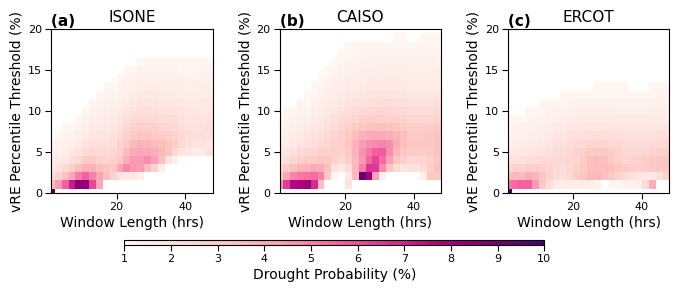

In [32]:
cc=0
window_dim = np.arange(1, 49, 2)
rethres = np.arange(0,0.26,0.01)
ensn=120




fig, ax = plt.subplots(1, 3, figsize=(7, 2.5))
sce='historic'
for ic in range(3):
    ISO=ISOs[ic]
    data = xr.open_dataset('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_preconditioned1.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00))['__xarray_dataarray_variable__']
    mask = np.isnan(data).sum(dim='ens') > (ensn/2)
    data_masked=xr.where(mask, np.nan, data)
    mean_data=data_masked.mean(dim='ens')
    mean_data=mean_data*100
    mean_data=xr.where(mean_data<1, np.nan, mean_data)  
    c=ax[ic].pcolormesh(window_dim, rethres*100, mean_data.T, cmap=cmaps.MPL_RdPu, alpha=1, vmin=1, vmax=10)
    ax[ic].set_title(f"{ISO}")
    ax[ic].set_xlabel('Window Length (hrs)')
    ax[ic].set_ylabel('vRE Percentile Threshold (%)')
    ax[ic].set_ylim(0,20)
    ax[ic].set_xlim(1,48)  
    setsubtitle(ax[ic], f"", ni=ic)
    
        
cax=fig.add_axes([0.2, 0, 0.6, 0.02])
fig.colorbar(c, cax=cax, orientation='horizontal')  
cax.set_xlabel('Drought Probability (%)')
plt.tight_layout()
plt.savefig('./figures_free/precondition.pdf', bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_1435593/2953596981.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


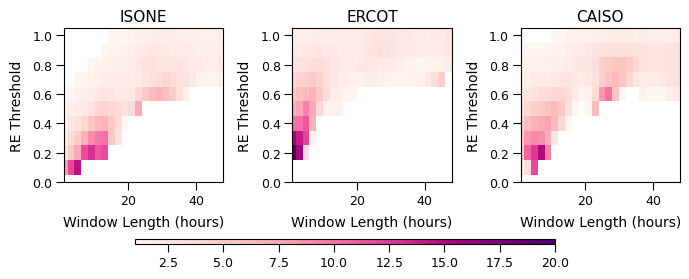

In [ ]:
cc=0
window_dim = np.arange(1, 49, 2)
rethres_dim = np.arange(0,1.1,0.1)
rethres=np.append(rethres_dim,np.inf)
ensn=120
rethre_dim_plot=np.arange(0,1.2,0.1)

sces=['historic','rcp85hotter']

fig, ax = plt.subplots(1, 3, figsize=(7, 2.5))
sce='historic'
for ic in range(3):
    ISO=ISOs[ic]
    data = xr.open_dataset('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_preconditioned.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00))['__xarray_dataarray_variable__']
    mask = np.isnan(data).sum(dim='ens') > (ensn/2)
    data_masked=xr.where(mask, np.nan, data)
    mean_data=data_masked.mean(dim='ens')
    mean_data=mean_data*100
    mean_data=xr.where(mean_data<1, np.nan, mean_data)
    c=ax[ic].pcolormesh(window_dim, rethre_dim_plot, mean_data.T, cmap=cmaps.MPL_RdPu, alpha=1, vmin=1, vmax=20)
    ax[ic].set_title(f"{ISO}")
    ax[ic].set_xlabel('Window Length (hours)')
    ax[ic].set_ylabel('RE Threshold')
    ax[ic].set_ylim(0,1.05)
    ax[ic].set_xlim(1,48)  
    
        
cax=fig.add_axes([0.2, 0, 0.6, 0.02])
fig.colorbar(c, cax=cax, orientation='horizontal')  
plt.tight_layout()
plt.show()

# climate change drought

## figure

7.19273392713049e-06
0.07507390842873574
0.23287441422852773
0.005697511075561934
0.5699744628597805
0.00039847947719939825


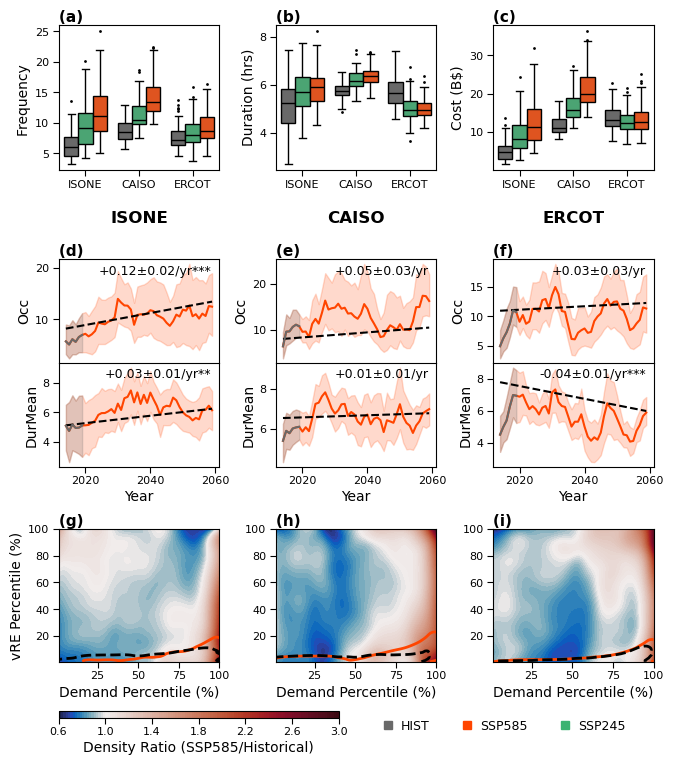

In [111]:
ncs=len(ISOs)
cc=0
nrs=4
ncs=3
fig = plt.figure(figsize=(7, 7))
# 4 rows × 3 columns
gs = gridspec.GridSpec(
    4, 3, 
    height_ratios=[0.7, 0.5, 0.5, 0.8],  # You can adjust ratios to taste
    hspace=0.3  # This sets default vertical spacing
)

axes = [[fig.add_subplot(gs[row, col]) for col in range(3)] for row in range(4)]
ynlabel='RE'
xnlabel='Demand'
#$10/kWh for the value of lost load
##
ir=3
yn='RE'
xn='demand'
ynlabel='RE'
xnlabel='Demand'
levels_diff = np.arange(0.6, 3.02, 0.02)
norm = TwoSlopeNorm(vmin=0.6, vcenter=1.0, vmax=3.0)
sce='rcp85hotter'
for ic in range(3):
    ISO=ISOs[ic]
    Z_xr=xr.open_dataset('%s/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full.nc'%(anadir,ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
    diff_density = (Z_xr.Z_future/Z_xr.Z_hist)  # Compute density difference
    diff_density=diff_density[1:101,1:101]
    contour_diff = axes[ir][ic].contourf(diff_density[xn]*100, diff_density[yn]*100, diff_density, cmap=cmaps.cmocean_balance, levels=levels_diff, norm=norm)
    setsubtitle(axes[ir][ic], f"", nrc=[ir, ic, nrs, ncs])
    
    axes[ir][ic].set_xlabel("Demand Percentile (%)")
    if ic==0:
        axes[ir][ic].set_ylabel("vRE Percentile (%)")
    else:
        axes[ir][ic].set_ylabel("")
    if cc==0:
        points_xr=xr.open_dataset('%s/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full_points.nc'%(anadir,ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
        for sce in ['historic',sce]:
            if sce=='historic':
                points_xr_period=points_xr['Z_hist']
            else:
                points_xr_period=points_xr['Z_future']
            prob=points_xr_period/points_xr_period.sum()*100
            prob=prob[1:101,1:101]
            U_grid, V_grid = np.meshgrid(np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 100))
            if sce=='historic':
                c=axes[ir][ic].contour(U_grid*100, V_grid*100, prob, colors='black',linewidths=2,levels=[0.05],linestyles='dashed',zorder=200)
            else:
                c=axes[ir][ic].contour(U_grid*100, V_grid*100, prob, colors=colorpalattes[sce],linewidths=2,levels=[0.05])
            #axes[ir][ic].clabel(c,fmt='%.2f', fontsize=8, inline=True)
    setsubtitle(axes[ir][ic], f"", nrc=[2, ic, nrs, ncs])
#axes[ir][0].text(0.5, 0.3, "P(RA Failure)>0.05%", fontsize=8, ha='left', va='center',transform=axes[ir][0].transAxes)
#####################contour: anomalies
vars=['Occ','DurMean']
for ir in range(1, 3):
    var=vars[ir-1]
    for ic in range(ncs):
        ISO=ISOs[ic]
        hist=pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,'historic'))
        hist['cost']=hist['MagSum']*(25)/1000/1000
        future=hist
        for pid in range(1,5):
            futuretmp = pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual_%d.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,sce,pid))
            futuretmp['cost']=futuretmp['MagSum']*(25)/1000/1000
            future=pd.concat([future,futuretmp])
        future['sce']=sce
        future['id']=future['id'].astype(int)
        future['Year']=future['Year'].astype(int)
        future_sorted = future.sort_values(['id', 'Year'])
        yearmean=future_sorted.groupby('id').rolling(window=5,on='Year').mean(numeric_only=True).dropna().reset_index()
        #yearmean=yearmean[yearmean['Year']>=2015]
        sns.lineplot(data=yearmean,x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        grouped=yearmean.groupby('Year').mean().reset_index()
        X = grouped['Year'].values.reshape(-1, 1)
        y=grouped[var].values
        model=TheilSenRegressor().fit(X, y)
        y_pred = model.predict(X)
        slope = model.coef_[0]
        mad = median_abs_deviation(y, scale='normal')
        slope_std = mad / (np.sqrt(len(y)) * np.std(X)) 
        mk_result = mk.original_test(y)
        p_value = mk_result.p
        print(p_value)
        axes[ir][ic].plot(grouped['Year'],y_pred,label=f'slope={slope:.2f}, p={p_value:.2f}',color='k',linestyle='--')
        stars=get_sig_stars(p_value)
        if sce=='rcp85hotter':
            axes[ir][ic].text(0.95,0.95, 
                f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes)
        elif sce=='rcp45hotter':
            axes[ir][ic].text(0.95,0.85, 
                f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes)
        sns.lineplot(data=yearmean[yearmean['Year']<2020],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes['historic'])
        #sns.lineplot(data=yearmean[yearmean['Year']>2050],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        if var=='occ':
            axes[ir][ic].set_ylim(0,60)
            if ic==0:
                axes[ir][ic].set_ylabel('Frequency')
            else:
                axes[ir][ic].set_ylabel('')
        elif var=='dur':
            axes[ir][ic].set_ylim(2,11)
            if ic==0:
                axes[ir][ic].set_ylabel('Duration (hrs)')
            else:
                axes[ir][ic].set_ylabel('')
            axes[ir][ic].set_yticks([3, 6,9])
for ic in range(3):
    axes[1][ic].set_xlabel('')
    axes[1][ic].set_xticklabels([])
    setsubtitle(axes[1][ic], f"", nrc=[1, ic, nrs, ncs])
    

############
ir=0
vars=['Occ','DurMean','Cost']
vars_labels={'Occ':'Frequency','DurMean':'Duration','Cost':'Cost'}
vars_labels_units={'Occ':'','DurMean':'(hrs)','Cost':'(B$)'}

tmp=pd.DataFrame()
for ic in range(ncs):
    ISO=ISOs[ic]
    for scea in ['historic','rcp85hotter','rcp45hotter']:
        DF_drought = pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,scea))
        DF_drought['ISO']=ISO
        DF_drought['Cost'] = DF_drought['MagSum']*(25)/1000/1000
        DF_drought['id'] = DF_drought['id'].astype(int)
        DF_drought=DF_drought.groupby(['ISO','id','sce']).mean(numeric_only=True)
        tmp=pd.concat([tmp,DF_drought])

tmp=tmp.reset_index()
for ic in range(ncs):
    var=vars[ic]
    sns.boxplot(ax=axes[ir][ic],x='ISO',y=vars[ic],data=tmp,hue='sce',palette=colorpalattes,hue_order=['historic','rcp45hotter','rcp85hotter'],
    legend=False,saturation=0.75,fliersize=1)
    
    axes[ir][ic].set_ylabel(f"{vars_labels[var]} {vars_labels_units[var]}")
    setsubtitle(axes[ir][ic], "", nrc=[ir, ic, nrs, ncs])
    axes[ir][ic].set_xlabel("")
plt.subplots_adjust(hspace=0.4, top=0.98, bottom=0.07, left=0.1, right=0.95,wspace=0.35)

for col in range(3):
    ax2 = axes[1][col]
    ax3 = axes[2][col]
    ax4 = axes[3][col]
    
    # Get their positions
    pos2 = ax2.get_position()
    pos3 = ax3.get_position()
    pos4 = ax4.get_position()

    ax2.set_position([
        pos2.x0,                     # left
        pos2.y0 - 0.071,              # bottom (move it up)
        pos2.width,
        pos2.height
    ])
    fig.text(pos2.x0+pos2.width/2,pos2.y0+0.13, ISOs[col], ha='center', fontsize=12, color='black', fontweight='bold')
    # Move ax3 up to stick closer to ax2
    ax3.set_position([
        pos3.x0,                     # left
        pos3.y0 - 0.015,              # bottom (move it up)
        pos3.width,
        pos3.height
    ])

    # Optional: visually hide borders between the two
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(True)

    ax4.set_position([
        pos4.x0,                     # left
        pos4.y0,              # bottom (move it up)
        pos4.width,
        pos4.height*0.8
    ])

cax_cbar_diff= fig.add_axes([0.1, -0.01, 0.4, 0.01])
cbar_diff = fig.colorbar(contour_diff, cax=cax_cbar_diff, orientation='horizontal', pad=0.02)
cax_cbar_diff.set_xlabel('Density Ratio (SSP585/Historical)')
cax_cbar_diff.set_xticks(np.arange(0.6, 3.4, 0.4))

ir=3
for scea in ['historic','rcp85hotter','rcp45hotter']:
    axes[ir][2].plot([], [], color=colorpalattes[scea], label=scenario_labels[scea],marker='s',linestyle='None')
axes[ir][2].legend(loc='upper left', bbox_to_anchor=(-0.8, -0.35),ncol=3,frameon=False,handletextpad=0.05,fontsize=9)

plt.savefig(f'{figdir}/cc_pl%d_%s.pdf'%(100-cc,sce), bbox_inches='tight', dpi=300)
plt.show()

In [113]:
tmp.groupby(['ISO','sce']).mean(numeric_only=True)

id  Unnamed: 0        Year   DurMean       MagMean  \
ISO   sce                                                                 
CAISO historic     60.5     4.50000  2014.50000  5.769248  47873.632493   
      rcp45hotter  60.5     4.50000  2054.50000  6.218435  52307.310672   
      rcp85hotter  60.5     4.50000  2054.50000  6.401822  55288.392657   
ERCOT historic     60.5     4.50000  2014.50000  5.724098  61193.098457   
      rcp45hotter  60.5     4.50000  2054.50000  5.048306  52370.287186   
      rcp85hotter  60.5     4.50000  2054.50000  5.000778  51179.611884   
ISONE 0             0.0     5.00000  2015.00000  0.000000      0.000000   
      historic     60.5     4.49537  2014.49537  5.098288  29403.903367   
      rcp45hotter  60.5     4.50000  2054.50000  5.731460  37178.869036   
      rcp85hotter  60.5     4.50000  2054.50000  5.884809  40283.759521   

                         Occ     DurSum         MagSum       Cost  
ISO   sce                                                          
CAISO historic      8.713333  53.791667  465998.213981  11.649955  
      rcp45hotter  11.333333  75.669167  668638.648838  16.715966  
      rcp85hotter  14.075000  96.042500  864183.864130  21.604597  
ERCOT historic      7.686667  47.793958  540498.134593  13.512453  
      rcp45hotter   8.485000  46.792870  504289.159029  12.607229  
      rcp85hotter   9.316667  50.134167  526140.028820  13.153501  
ISONE 0             0.000000   0.000000       0.000000   0.000000  
      historic      6.338935  34.954167  200305.088080   5.007627  
      rcp45hotter   9.378333  55.826667  357232.301762   8.930808  
      rcp85hotter  11.745833  72.795833  497900.711172  12.447518

0.0308704513617708
0.6631741519093703
0.7332138985466468
0.0690816888413297
0.4602010444653013
0.0011257889230618101


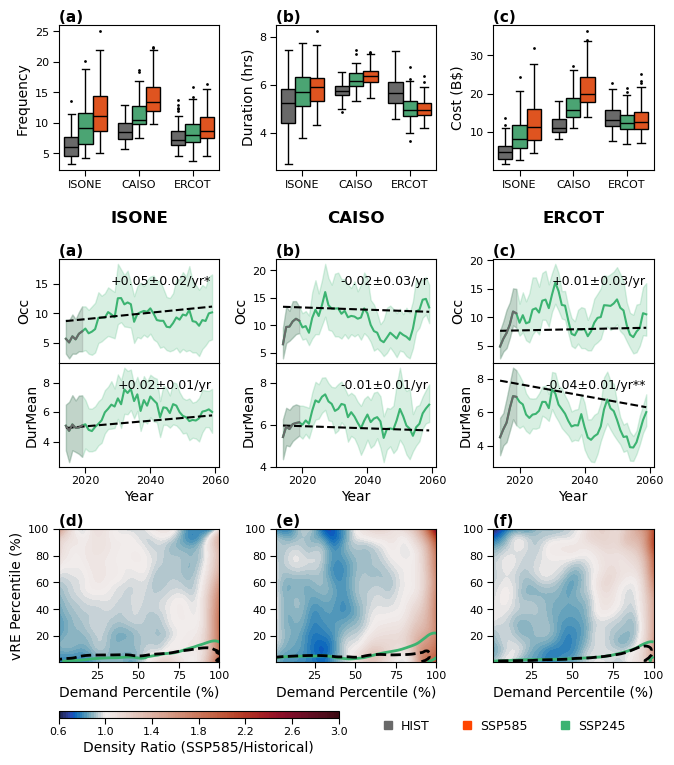

In [116]:
ncs=len(ISOs)
cc=0
nrs=4
ncs=3
fig = plt.figure(figsize=(7, 7))
# 4 rows × 3 columns
gs = gridspec.GridSpec(
    4, 3, 
    height_ratios=[0.7, 0.5, 0.5, 0.8],  # You can adjust ratios to taste
    hspace=0.3  # This sets default vertical spacing
)

axes = [[fig.add_subplot(gs[row, col]) for col in range(3)] for row in range(4)]
ynlabel='RE'
xnlabel='Demand'
#$10/kWh for the value of lost load
##
ir=3
yn='RE'
xn='demand'
ynlabel='RE'
xnlabel='Demand'
levels_diff = np.arange(0.6, 3.02, 0.02)
norm = TwoSlopeNorm(vmin=0.6, vcenter=1.0, vmax=3.0)
sce='rcp45hotter'
for ic in range(3):
    ISO=ISOs[ic]
    Z_xr=xr.open_dataset('%s/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full.nc'%(anadir,ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
    diff_density = (Z_xr.Z_future/Z_xr.Z_hist)  # Compute density difference
    diff_density=diff_density[1:101,1:101]
    contour_diff = axes[ir][ic].contourf(diff_density[xn]*100, diff_density[yn]*100, diff_density, cmap=cmaps.cmocean_balance, levels=levels_diff, norm=norm)
    setsubtitle(axes[ir][ic], f"", nrc=[ir, ic, nrs, ncs])
    
    axes[ir][ic].set_xlabel("Demand Percentile (%)")
    if ic==0:
        axes[ir][ic].set_ylabel("vRE Percentile (%)")
    else:
        axes[ir][ic].set_ylabel("")
    if cc==0:
        points_xr=xr.open_dataset('%s/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full_points.nc'%(anadir,ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
        for sce in ['historic',sce]:
            if sce=='historic':
                points_xr_period=points_xr['Z_hist']
            else:
                points_xr_period=points_xr['Z_future']
            prob=points_xr_period/points_xr_period.sum()*100
            prob=prob[1:101,1:101]
            U_grid, V_grid = np.meshgrid(np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 100))
            if sce=='historic':
                c=axes[ir][ic].contour(U_grid*100, V_grid*100, prob, colors='black',linewidths=2,levels=[0.05],linestyles='dashed',zorder=200)
            else:
                c=axes[ir][ic].contour(U_grid*100, V_grid*100, prob, colors=colorpalattes[sce],linewidths=2,levels=[0.05])
            #axes[ir][ic].clabel(c,fmt='%.2f', fontsize=8, inline=True)
    setsubtitle(axes[ir][ic], f"", nrc=[1, ic, nrs, ncs])
#axes[ir][0].text(0.5, 0.3, "P(RA Failure)>0.05%", fontsize=8, ha='left', va='center',transform=axes[ir][0].transAxes)
#####################contour: anomalies
vars=['Occ','DurMean']
for ir in range(1, 3):
    var=vars[ir-1]
    for ic in range(ncs):
        ISO=ISOs[ic]
        hist=pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,'historic'))
        hist['cost']=hist['MagSum']*(25)/1000/1000
        future=hist
        for pid in range(1,5):
            futuretmp = pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual_%d.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,sce,pid))
            futuretmp['cost']=futuretmp['MagSum']*(25)/1000/1000
            future=pd.concat([future,futuretmp])
        future['sce']=sce
        future['id']=future['id'].astype(int)
        future['Year']=future['Year'].astype(int)
        future_sorted = future.sort_values(['id', 'Year'])
        yearmean=future_sorted.groupby('id').rolling(window=5,on='Year').mean(numeric_only=True).dropna().reset_index()
        #yearmean=yearmean[yearmean['Year']>=2015]
        sns.lineplot(data=yearmean,x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        grouped=yearmean.groupby('Year').mean().reset_index()
        X = grouped['Year'].values.reshape(-1, 1)
        y=grouped[var].values
        model=TheilSenRegressor().fit(X, y)
        y_pred = model.predict(X)
        slope = model.coef_[0]
        mad = median_abs_deviation(y, scale='normal')
        slope_std = mad / (np.sqrt(len(y)) * np.std(X)) 
        mk_result = mk.original_test(y)
        p_value = mk_result.p
        print(p_value)
        axes[ir][ic].plot(grouped['Year'],y_pred,label=f'slope={slope:.2f}, p={p_value:.2f}',color='k',linestyle='--')
        stars=get_sig_stars(p_value)
        if sce=='rcp85hotter':
            axes[ir][ic].text(0.95,0.95, 
                f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes)
        elif sce=='rcp45hotter':
            axes[ir][ic].text(0.95,0.85, 
                f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes)
        sns.lineplot(data=yearmean[yearmean['Year']<2020],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes['historic'])
        #sns.lineplot(data=yearmean[yearmean['Year']>2050],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        if var=='occ':
            axes[ir][ic].set_ylim(0,60)
            if ic==0:
                axes[ir][ic].set_ylabel('Frequency')
            else:
                axes[ir][ic].set_ylabel('')
        elif var=='dur':
            axes[ir][ic].set_ylim(2,11)
            if ic==0:
                axes[ir][ic].set_ylabel('Duration (hrs)')
            else:
                axes[ir][ic].set_ylabel('')
            axes[ir][ic].set_yticks([3, 6,9])
for ic in range(3):
    axes[1][ic].set_xlabel('')
    axes[1][ic].set_xticklabels([])
    setsubtitle(axes[1][ic], f"", nrc=[0, ic, nrs, ncs])
    

############
ir=0
vars=['Occ','DurMean','Cost']
vars_labels={'Occ':'Frequency','DurMean':'Duration','Cost':'Cost'}
vars_labels_units={'Occ':'','DurMean':'(hrs)','Cost':'(B$)'}

tmp=pd.DataFrame()
for ic in range(ncs):
    ISO=ISOs[ic]
    for scea in ['historic','rcp85hotter','rcp45hotter']:
        DF_drought = pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,scea))
        DF_drought['ISO']=ISO
        DF_drought['Cost'] = DF_drought['MagSum']*(25)/1000/1000
        DF_drought['id'] = DF_drought['id'].astype(int)
        DF_drought=DF_drought.groupby(['ISO','id','sce']).mean(numeric_only=True)
        tmp=pd.concat([tmp,DF_drought])

tmp=tmp.reset_index()
for ic in range(ncs):
    var=vars[ic]
    sns.boxplot(ax=axes[ir][ic],x='ISO',y=vars[ic],data=tmp,hue='sce',palette=colorpalattes,hue_order=['historic','rcp45hotter','rcp85hotter'],
    legend=False,saturation=0.75,fliersize=1)
    
    axes[ir][ic].set_ylabel(f"{vars_labels[var]} {vars_labels_units[var]}")
    setsubtitle(axes[ir][ic], "", nrc=[ir, ic, nrs, ncs])
    axes[ir][ic].set_xlabel("")
plt.subplots_adjust(hspace=0.4, top=0.98, bottom=0.07, left=0.1, right=0.95,wspace=0.35)

for col in range(3):
    ax2 = axes[1][col]
    ax3 = axes[2][col]
    ax4 = axes[3][col]
    
    # Get their positions
    pos2 = ax2.get_position()
    pos3 = ax3.get_position()
    pos4 = ax4.get_position()

    ax2.set_position([
        pos2.x0,                     # left
        pos2.y0 - 0.071,              # bottom (move it up)
        pos2.width,
        pos2.height
    ])
    fig.text(pos2.x0+pos2.width/2,pos2.y0+0.13, ISOs[col], ha='center', fontsize=12, color='black', fontweight='bold')
    # Move ax3 up to stick closer to ax2
    ax3.set_position([
        pos3.x0,                     # left
        pos3.y0 - 0.015,              # bottom (move it up)
        pos3.width,
        pos3.height
    ])

    # Optional: visually hide borders between the two
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(True)

    ax4.set_position([
        pos4.x0,                     # left
        pos4.y0,              # bottom (move it up)
        pos4.width,
        pos4.height*0.8
    ])

cax_cbar_diff= fig.add_axes([0.1, -0.01, 0.4, 0.01])
cbar_diff = fig.colorbar(contour_diff, cax=cax_cbar_diff, orientation='horizontal', pad=0.02)
cax_cbar_diff.set_xlabel('Density Ratio (SSP585/Historical)')
cax_cbar_diff.set_xticks(np.arange(0.6, 3.4, 0.4))

ir=3
for scea in ['historic','rcp85hotter','rcp45hotter']:
    axes[ir][2].plot([], [], color=colorpalattes[scea], label=scenario_labels[scea],marker='s',linestyle='None')
axes[ir][2].legend(loc='upper left', bbox_to_anchor=(-0.8, -0.35),ncol=3,frameon=False,handletextpad=0.05,fontsize=9)

plt.savefig(f'{figdir}/cc_pl%d_%s.pdf'%(100-cc,sce), bbox_inches='tight', dpi=300)
plt.show()

0.0308704513617708
0.6631741519093703
0.7332138985466468
0.0690816888413297
0.4602010444653013
0.0011257889230618101
0.12506887377151577
0.29764508438207127
0.11168847692973327
7.19273392713049e-06
0.07507390842873574
0.23287441422852773


0.005697511075561934
0.5699744628597805
0.00039847947719939825
0.0004280578696900239
0.3247774529609755
0.24037466875424895


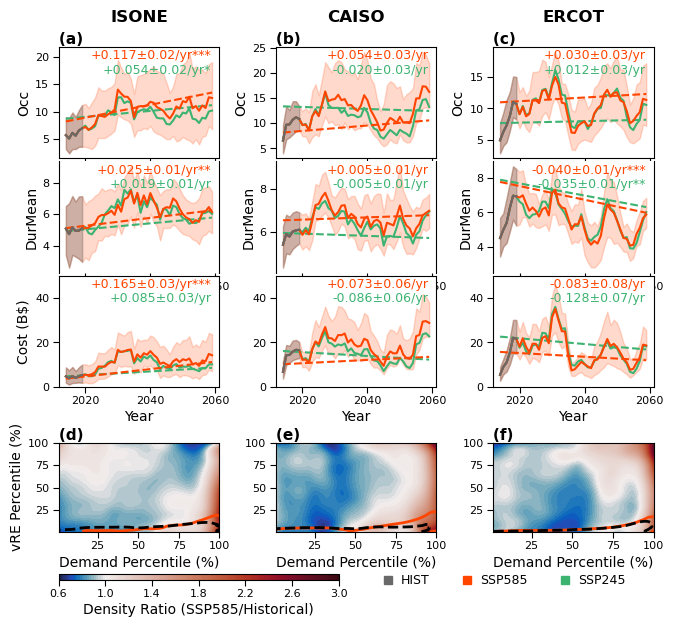

In [24]:
ncs=len(ISOs)
cc=0
nrs=4
fig = plt.figure(figsize=(7, 6))
# 4 rows × 3 columns
gs = gridspec.GridSpec(
    4, 3, 
    height_ratios=[0.5, 0.5, 0.5, 0.5],  # You can adjust ratios to taste
    hspace=0.3  # This sets default vertical spacing
)

axes = [[fig.add_subplot(gs[row, col]) for col in range(3)] for row in range(4)]
ynlabel='RE'
xnlabel='Demand'
#$10/kWh for the value of lost load
##
ir=3
yn='RE'
xn='demand'
ynlabel='RE'
xnlabel='Demand'
levels_diff = np.arange(0.6, 3.02, 0.02)
norm = TwoSlopeNorm(vmin=0.6, vcenter=1.0, vmax=3.0)
sce='rcp85hotter'
for ic in range(ncs):
    ISO=ISOs[ic]
    Z_xr=xr.open_dataset('%s/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full.nc'%(anadir,ny,  'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
    diff_density = (Z_xr.Z_future/Z_xr.Z_hist)  # Compute density difference
    diff_density=diff_density[1:101,1:101]
    contour_diff = axes[ir][ic].contourf(diff_density[xn]*100, diff_density[yn]*100, diff_density, cmap=cmaps.cmocean_balance, levels=levels_diff, norm=norm)
    setsubtitle(axes[ir][ic], f"", nrc=[ir, ic, nrs, ncs])
    
    axes[ir][ic].set_xlabel("Demand Percentile (%)")
    if ic==0:
        axes[ir][ic].set_ylabel("vRE Percentile (%)")
    else:
        axes[ir][ic].set_ylabel("")
    if cc==0:
        points_xr=xr.open_dataset('%s/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full_points.nc'%(anadir,ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
        for sce in ['historic',sce]:
            if sce=='historic':
                points_xr_period=points_xr['Z_hist']
            else:
                points_xr_period=points_xr['Z_future']
            prob=points_xr_period/points_xr_period.sum()*100
            prob=prob[1:101,1:101]
            U_grid, V_grid = np.meshgrid(np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 100))
            if sce=='historic':
                c=axes[ir][ic].contour(U_grid*100, V_grid*100, prob, colors='black',linewidths=2,levels=[0.05],linestyles='dashed',zorder=200)
            else:
                c=axes[ir][ic].contour(U_grid*100, V_grid*100, prob, colors=colorpalattes[sce],linewidths=2,levels=[0.05])
            #axes[ir][ic].clabel(c,fmt='%.2f', fontsize=8, inline=True)
    setsubtitle(axes[ir][ic], f"", nrc=[1, ic, nrs, ncs])
#axes[ir][0].text(0.5, 0.3, "P(RA Failure)>0.05%", fontsize=8, ha='left', va='center',transform=axes[ir][0].transAxes)
#####################contour: anomalies
vars=['Occ','DurMean','cost']
for sce in ['rcp45hotter','rcp85hotter']:
    for ir in range(3):
        var=vars[ir]
        for ic in range(3):
            ISO=ISOs[ic]
            hist=pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,'historic'))
            hist['cost']=hist['MagSum']*(25)/1000/1000
            future=hist
            for pid in range(1,5):
                futuretmp = pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual_%d.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,sce,pid))
                futuretmp['cost']=futuretmp['MagSum']*(25)/1000/1000
                future=pd.concat([future,futuretmp])
            future['sce']=sce
            future['id']=future['id'].astype(int)
            future['Year']=future['Year'].astype(int)
            future_sorted = future.sort_values(['id', 'Year'])
            yearmean=future_sorted.groupby('id').rolling(window=5,on='Year').mean(numeric_only=True).dropna().reset_index()
            
            grouped=yearmean.groupby('Year').mean().reset_index()
            X = grouped['Year'].values.reshape(-1, 1)
            y=grouped[var].values
            model=TheilSenRegressor().fit(X, y)
            y_pred = model.predict(X)
            slope = model.coef_[0]
            mad = median_abs_deviation(y, scale='normal')
            slope_std = mad / (np.sqrt(len(y)) * np.std(X)) 
            mk_result = mk.original_test(y)
            p_value = mk_result.p
            print(p_value)
            axes[ir][ic].plot(grouped['Year'],y_pred,label=f'slope={slope:.2f}, p={p_value:.2f}',color=colorpalattes[sce],linestyle='--')
            stars=get_sig_stars(p_value)
            if sce=='rcp85hotter':
                sns.lineplot(data=yearmean,x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
                axes[ir][ic].text(0.95,0.98, 
                    f"{slope:+.3f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes,color=colorpalattes[sce])
            elif sce=='rcp45hotter':
                sns.lineplot(data=yearmean,x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=None,color=colorpalattes[sce])
                axes[ir][ic].text(0.95,0.85, 
                    f"{slope:+.3f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes,color=colorpalattes[sce])
            sns.lineplot(data=yearmean[yearmean['Year']<2020],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes['historic'])
            #sns.lineplot(data=yearmean[yearmean['Year']>2050],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
            if var=='occ':
                axes[ir][ic].set_ylim(0,70)
                if ic==0:
                    axes[ir][ic].set_ylabel('Frequency')
                else:
                    axes[ir][ic].set_ylabel('')
            elif var=='dur':
                axes[ir][ic].set_ylim(3,10)
                if ic==0:
                    axes[ir][ic].set_ylabel('Duration (hrs)')
                else:
                    axes[ir][ic].set_ylabel('')
                axes[ir][ic].set_yticks([3, 6,9 ])
            elif var=='cost':
                axes[ir][ic].set_ylim(0,50)
                if ic==0:
                    axes[ir][ic].set_ylabel('Cost (B$)')
                else:
                    axes[ir][ic].set_ylabel('')
                axes[ir][ic].set_yticks([0, 20, 40])
for ic in range(3):
    axes[0][ic].set_xlabel('')
    axes[0][ic].set_xticklabels([])
    setsubtitle(axes[0][ic], "", nrc=[0, ic, nrs, ncs])
    

plt.subplots_adjust(hspace=0.4, top=0.98, bottom=0.07, left=0.1, right=0.95,wspace=0.35)

for col in range(3):
    ax1= axes[0][col]
    ax2 = axes[1][col]
    ax3 = axes[2][col]
    ax4 = axes[3][col]
    
    # Get their positions
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    pos3 = ax3.get_position()
    pos4 = ax4.get_position()

    ax1.set_position([
        pos1.x0,                     # left
        pos1.y0 - 0.051-0.051,              # bottom (move it up)
        pos1.width,
        pos1.height
    ])

    ax2.set_position([
        pos2.x0,                     # left
        pos2.y0-0.051,              # bottom (move it up)
        pos2.width,
        pos2.height
    ])
    fig.text(pos1.x0+pos1.width/2,pos1.y1-0.06, ISOs[col], ha='center', fontsize=12, color='black', fontweight='bold')
    # Move ax3 up to stick closer to ax2
    ax3.set_position([
        pos3.x0,                     # left
        pos3.y0,              # bottom (move it up)
        pos3.width,
        pos3.height
    ])

    # Optional: visually hide borders between the two
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['top'].set_visible(True)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['top'].set_visible(True)

    ax4.set_position([
        pos4.x0,                     # left
        pos4.y0,              # bottom (move it up)
        pos4.width,
        pos4.height*0.8
    ])

cax_cbar_diff= fig.add_axes([0.1, -0.01, 0.4, 0.01])
cbar_diff = fig.colorbar(contour_diff, cax=cax_cbar_diff, orientation='horizontal', pad=0.02)
cax_cbar_diff.set_xlabel('Density Ratio (SSP585/Historical)')
cax_cbar_diff.set_xticks(np.arange(0.6, 3.4, 0.4))

ir=3
for scea in ['historic','rcp85hotter','rcp45hotter']:
    axes[ir][2].plot([], [], color=colorpalattes[scea], label=scenario_labels[scea],marker='s',linestyle='None')
axes[ir][2].legend(loc='upper left', bbox_to_anchor=(-0.8, -0.35),ncol=3,frameon=False,handletextpad=0.05,fontsize=9)

plt.savefig('%s/cc_pl%d_%sad.pdf'%(figdir,100-cc,sce), bbox_inches='tight', dpi=300)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/orcd/nese/mhowland/001/lyqiu/GODEEP/analysis/Analysis_drought/OutSampleDispatch_sub3yrs_demand_mlp_ISONE_cc_0_landr_0_TGW_test_rcp45hotter_1.000_copula_demand_RE_full.nc'

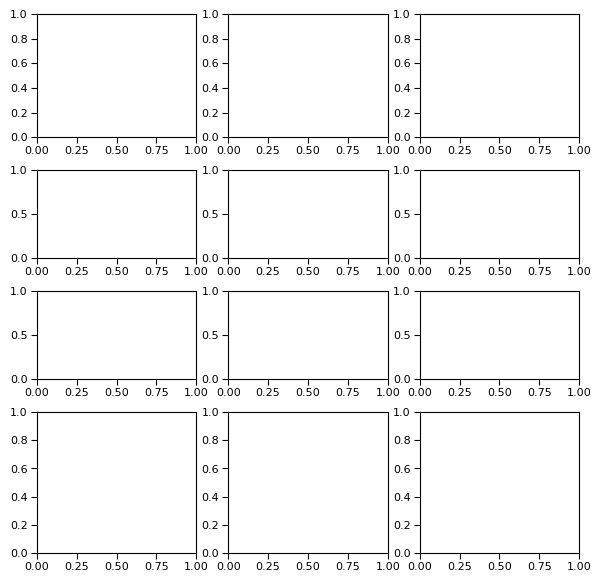

In [ ]:
ncs=len(ISOs)
cc=0
nrs=4
fig = plt.figure(figsize=(7, 7))
# 4 rows × 3 columns
gs = gridspec.GridSpec(
    4, 3, 
    height_ratios=[0.7, 0.5, 0.5, 0.8],  # You can adjust ratios to taste
    hspace=0.3  # This sets default vertical spacing
)

axes = [[fig.add_subplot(gs[row, col]) for col in range(3)] for row in range(4)]
ynlabel='RE'
xnlabel='Demand'
#$10/kWh for the value of lost load
##
ir=3
yn='RE'
xn='demand'
ynlabel='RE'
xnlabel='Demand'
levels_diff = np.arange(0.6, 3.02, 0.02)
norm = TwoSlopeNorm(vmin=0.6, vcenter=1.0, vmax=3.0)
sce='rcp45hotter'
for ic in range(ncs):
    ISO=ISOs[ic]
    Z_xr=xr.open_dataset('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full.nc'%(ny,  'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
    diff_density = (Z_xr.Z_future/Z_xr.Z_hist)  # Compute density difference
    contour_diff = axes[ir][ic].contourf(Z_xr[xn]*100, Z_xr[yn]*100, diff_density, cmap=cmaps.cmocean_balance, levels=levels_diff, norm=norm)
    setsubtitle(axes[ir][ic], f"", nrc=[ir, ic, nrs, ncs])
    
    axes[ir][ic].set_xlabel("Demand Percentile (%)")
    if ic==0:
        axes[ir][ic].set_ylabel("vRE Percentile (%)")
    else:
        axes[ir][ic].set_ylabel("")
    if cc==0:
        points_xr=xr.open_dataset('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full_points.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
        pointfile='./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_points_%s_%s_%s.csv'%(ny, 'mlp',ISO, cc, land, mdl,'rcp85hotter', 1.00,xn,yn,'full')
        points=pd.read_csv(pointfile)
        for sce in ['historic','rcp85hotter']:
            points_period=points[points['sce']==sce]
            if sce=='historic':
                points_xr_period=points_xr['Z_hist']
            else:
                points_xr_period=points_xr['Z_future']
            prob=points_xr_period/points_xr_period.sum()*100
            U_grid, V_grid = np.meshgrid(np.linspace(0, 1, 101), np.linspace(0, 1, 101))
            minx=points_period[xn].min()
            maxx=points_period[xn].max()
            miny=points_period[yn].min()
            maxy=points_period[yn].max()
            mask_U=(U_grid>=minx)&(U_grid<=maxx)
            mask_V=(V_grid>=miny)&(V_grid<=maxy)
            mask=mask_U&mask_V
            prob=prob.where(mask)
            if sce=='historic':
                axes[ir][ic].contour(U_grid*100, V_grid*100, prob*100, colors='black',linewidths=2,levels=[0.01])
            else:
                axes[ir][ic].contour(U_grid*100, V_grid*100, prob*100, colors=colorpalattes[sce],linewidths=2,levels=[0.01])
    setsubtitle(axes[ir][ic], f"", nrc=[2, ic, nrs, ncs])
#####################contour: anomalies
vars=['occ','dur']
for ir in range(1, 3):
    var=vars[ir-1]
    for ic in range(3):
        ISO=ISOs[ic]
        hist=pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,'historic'))
        hist =hist[(hist['Year']!=2010) & (hist['Year']!=2049)]
        minyear=hist['Year'].min()
        maxyear=hist['Year'].max() 
        new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
        hist=hist.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
        hist=hist.groupby(['id','Year']).sum(numeric_only=True)
        hist['sce']='historic'
        sce='rcp45hotter'
        future=hist
        for pid in range(1,5):
            futuretmp = pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_%d.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce,pid))
            futuretmp =futuretmp[(futuretmp['Year']!=2010) & (futuretmp['Year']!=2049)]
            #futuretmp['occd']=futuretmp['occ']*futuretmp['dur']
            minyear=futuretmp['Year'].min()
            maxyear=futuretmp['Year'].max()
            new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
            futuretmp=futuretmp.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
            futuretmp=futuretmp.groupby(['id','Year']).sum(numeric_only=True)
            future=pd.concat([future,futuretmp])
        future['sce']=sce
        # demand=pd.concat([hist_demand,future_demand])
        yearmean=future.rolling(window=7).mean(numeric_only=True).dropna().reset_index()
        sns.lineplot(data=yearmean,x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        grouped=yearmean.groupby('Year').mean().reset_index()
        X = grouped['Year'].values.reshape(-1, 1)
        y=grouped[var].values
        model=TheilSenRegressor().fit(X, y)
        y_pred = model.predict(X)
        slope = model.coef_[0]
        mad = median_abs_deviation(y, scale='normal')
        slope_std = mad / (np.sqrt(len(y)) * np.std(X)) 
        mk_result = mk.original_test(y)
        p_value = mk_result.p
        print(p_value)
        axes[ir][ic].plot(grouped['Year'],y_pred,label=f'slope={slope:.2f}, p={p_value:.2f}',color='k',linestyle='--')
        stars=get_sig_stars(p_value)
        if sce=='rcp85hotter':
            axes[ir][ic].text(0.95,0.95, 
                f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes)
        elif sce=='rcp45hotter':
            axes[ir][ic].text(0.95,0.85, 
                f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes)
        sns.lineplot(data=yearmean[yearmean['Year']<2020],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes['historic'])
        sns.lineplot(data=yearmean[yearmean['Year']>2050],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        if var=='occ':
            axes[ir][ic].set_ylim(0,60)
            if ic==0:
                axes[ir][ic].set_ylabel('Occurrence')
            else:
                axes[ir][ic].set_ylabel('')
        elif var=='dur':
            axes[ir][ic].set_ylim(0,150)
            if ic==0:
                axes[ir][ic].set_ylabel('Duration (hrs)')
            else:
                axes[ir][ic].set_ylabel('')
            axes[ir][ic].set_yticks([0, 40, 80, 120])
for ic in range(3):
    axes[1][ic].set_xlabel('')
    axes[1][ic].set_xticklabels([])
    setsubtitle(axes[1][ic], f"", nrc=[1, ic, nrs, ncs])
    

############
ir=0
xvar='Prob'
yvar='Dur'
vars=['Occ','DurMean','Cost']
vars_labels={'Occ':'Occurrence','DurMean':'Duration','Cost':'Cost'}
vars_labels_units={'Occ':'','DurMean':'(hrs)','Cost':'(M$)'}

tmp=pd.DataFrame()
for ic in range(ncs):
    ISO=ISOs[ic]
    for sce in ['historic','rcp85hotter','rcp45hotter']:
        DF_drought = pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_drought_hourly.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce))
        DF_drought['ISO']=ISO
        DF_drought['Cost'] = DF_drought['MeanMagHour']*DF_drought['DurMean']/10*(10)/1000
        tmp=pd.concat([tmp,DF_drought])
tmp=tmp.reset_index()
for ic in range(ncs):
    var=vars[ic]
    sns.boxplot(ax=axes[ir][ic],x='ISO',y=vars[ic],data=tmp,hue='sce',palette=colorpalattes,hue_order=['historic','rcp45hotter','rcp85hotter'],
    legend=False,saturation=0.75,fliersize=1)
    axes[ir][ic].set_ylabel(f"{vars_labels[var]} {vars_labels_units[var]}")
    setsubtitle(axes[ir][ic], "", nrc=[ir, ic, nrs, ncs])
    axes[ir][ic].set_xlabel("")
plt.subplots_adjust(hspace=0.4, top=0.98, bottom=0.07, left=0.1, right=0.95,wspace=0.35)

for col in range(3):
    ax2 = axes[1][col]
    ax3 = axes[2][col]
    ax4 = axes[3][col]
    
    # Get their positions
    pos2 = ax2.get_position()
    pos3 = ax3.get_position()
    pos4 = ax4.get_position()

    ax2.set_position([
        pos2.x0,                     # left
        pos2.y0 - 0.071,              # bottom (move it up)
        pos2.width,
        pos2.height
    ])
    fig.text(pos2.x0+pos2.width/2,pos2.y0+0.13, ISOs[col], ha='center', fontsize=12, color='black', fontweight='bold')
    # Move ax3 up to stick closer to ax2
    ax3.set_position([
        pos3.x0,                     # left
        pos3.y0 - 0.015,              # bottom (move it up)
        pos3.width,
        pos3.height
    ])

    # Optional: visually hide borders between the two
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(True)

    ax4.set_position([
        pos4.x0,                     # left
        pos4.y0,              # bottom (move it up)
        pos4.width,
        pos4.height*0.8
    ])

cax_cbar_diff= fig.add_axes([0.1, -0.01, 0.4, 0.01])
cbar_diff = fig.colorbar(contour_diff, cax=cax_cbar_diff, orientation='horizontal', pad=0.02)
cax_cbar_diff.set_xlabel('Density Ratio (SSP585/Historical)')
cax_cbar_diff.set_xticks(np.arange(0.6, 3.4, 0.4))

ir=3
for sce in ['historic','rcp85hotter','rcp45hotter']:
    axes[ir][2].plot([], [], color=colorpalattes[sce], label=scenario_labels[sce],marker='s',linestyle='None')
axes[ir][2].legend(loc='upper left', bbox_to_anchor=(-0.8, -0.35),ncol=3,frameon=False,handletextpad=0.05,fontsize=9)

plt.savefig('./figures_free/cc_pl%d_%s.pdf'%(100-cc,sce), bbox_inches='tight', dpi=300)
plt.show()

5.125976165754054e-06
0.029438073404765674
0.07995556512751589
0.0007555994872971983
0.0281387897736618
0.017639163874108243


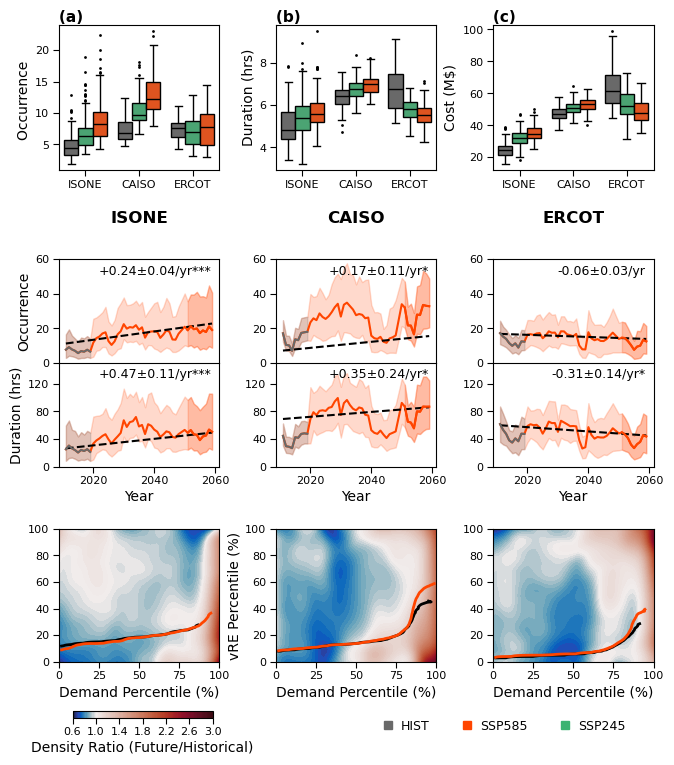

In [ ]:
ncs=len(ISOs)
cc=0
nrs=4
fig = plt.figure(figsize=(7, 7))
# 4 rows × 3 columns
gs = gridspec.GridSpec(
    4, 3, 
    height_ratios=[0.7, 0.5, 0.5, 0.8],  # You can adjust ratios to taste
    hspace=0.3  # This sets default vertical spacing
)

axes = [[fig.add_subplot(gs[row, col]) for col in range(3)] for row in range(4)]
ynlabel='RE'
xnlabel='Demand'
#$10/kWh for the value of lost load
##
ir=3
yn='RE'
xn='demand'
ynlabel='RE'
xnlabel='Demand'
levels_diff = np.arange(0.6, 3.02, 0.02)
norm = TwoSlopeNorm(vmin=0.6, vcenter=1.0, vmax=3.0)
sce='rcp85hotter'
for ic in range(ncs):
    ISO=ISOs[ic]
    Z_xr=xr.open_dataset('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full.nc'%(ny,  'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
    diff_density = (Z_xr.Z_future/Z_xr.Z_hist)  # Compute density difference
    contour_diff = axes[ir][ic].contourf(Z_xr[xn]*100, Z_xr[yn]*100, diff_density, cmap=cmaps.cmocean_balance, levels=levels_diff, norm=norm)
    #setsubtitle(axes[ir][ic], f"", nrc=[ir, ic, nrs, ncs])
    
    axes[ir][ic].set_xlabel("Demand Percentile (%)")
    if ic==1:
        axes[ir][ic].set_ylabel("vRE Percentile (%)")
    else:
        axes[ir][ic].set_ylabel("")
    if cc==0:
        points_xr=xr.open_dataset('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full_points.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
        pointfile='./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_points_%s_%s_%s.csv'%(ny, 'mlp',ISO, cc, land, mdl,'rcp85hotter', 1.00,xn,yn,'full')
        points=pd.read_csv(pointfile)
        for sce in ['historic','rcp85hotter']:
            points_period=points[points['sce']==sce]
            if sce=='historic':
                points_xr_period=points_xr['Z_hist']
            else:
                points_xr_period=points_xr['Z_future']
            prob=points_xr_period/points_xr_period.sum()*100
            U_grid, V_grid = np.meshgrid(np.linspace(0, 1, 101), np.linspace(0, 1, 101))
            minx=points_period[xn].min()
            maxx=points_period[xn].max()
            miny=points_period[yn].min()
            maxy=points_period[yn].max()
            mask_U=(U_grid>=minx)&(U_grid<=maxx)
            mask_V=(V_grid>=miny)&(V_grid<=maxy)
            mask=mask_U&mask_V
            prob=prob.where(mask)
            if sce=='historic':
               axes[ir][ic].contour(U_grid*100, V_grid*100, prob*100, colors='black',linewidths=2,levels=[0.01])
            else:
               axes[ir][ic].contour(U_grid*100, V_grid*100, prob*100, colors=colorpalattes[sce],linewidths=2,levels=[0.01])
    #setsubtitle(axes[ir][ic], f"", nrc=[2, ic, nrs, ncs])
#####################contour: anomalies
vars=['occ','dur']
for ir in range(1, 3):
    var=vars[ir-1]
    for ic in range(3):
        ISO=ISOs[ic]
        hist=pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,'historic'))
        hist =hist[(hist['Year']!=2010) & (hist['Year']!=2049)]
        minyear=hist['Year'].min()
        maxyear=hist['Year'].max() 
        new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
        hist=hist.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
        hist=hist.groupby(['id','Year']).sum(numeric_only=True)
        hist['sce']='historic'
        sce='rcp85hotter'
        future=hist
        for pid in range(1,5):
            futuretmp = pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_%d.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce,pid))
            futuretmp =futuretmp[(futuretmp['Year']!=2010) & (futuretmp['Year']!=2049)]
            #futuretmp['occd']=futuretmp['occ']*futuretmp['dur']
            minyear=futuretmp['Year'].min()
            maxyear=futuretmp['Year'].max()
            new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
            futuretmp=futuretmp.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
            futuretmp=futuretmp.groupby(['id','Year']).sum(numeric_only=True)
            future=pd.concat([future,futuretmp])
        future['sce']=sce
        # demand=pd.concat([hist_demand,future_demand])
        yearmean=future.rolling(window=7).mean(numeric_only=True).dropna().reset_index()
        sns.lineplot(data=yearmean,x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        grouped=yearmean.groupby('Year').mean().reset_index()
        X = grouped['Year'].values.reshape(-1, 1)
        y=grouped[var].values
        model=TheilSenRegressor().fit(X, y)
        y_pred = model.predict(X)
        slope = model.coef_[0]
        mad = median_abs_deviation(y, scale='normal')
        slope_std = mad / (np.sqrt(len(y)) * np.std(X)) 
        mk_result = mk.original_test(y)
        p_value = mk_result.p
        print(p_value)
        axes[ir][ic].plot(grouped['Year'],y_pred,label=f'slope={slope:.2f}, p={p_value:.2f}',color='k',linestyle='--')
        stars=get_sig_stars(p_value)
        if sce=='rcp85hotter':
            axes[ir][ic].text(0.95,0.95, 
                f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes)
        elif sce=='rcp45hotter':
            axes[ir][ic].text(0.95,0.85, 
                f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes)
        sns.lineplot(data=yearmean[yearmean['Year']<2020],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes['historic'])
        sns.lineplot(data=yearmean[yearmean['Year']>2050],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        if var=='occ':
            axes[ir][ic].set_ylim(0,60)
            if ic==0:
                axes[ir][ic].set_ylabel('Occurrence')
            else:
                axes[ir][ic].set_ylabel('')
        elif var=='dur':
            axes[ir][ic].set_ylim(0,150)
            if ic==0:
                axes[ir][ic].set_ylabel('Duration (hrs)')
            else:
                axes[ir][ic].set_ylabel('')
            axes[ir][ic].set_yticks([0, 40, 80, 120])
for ic in range(3):
    axes[1][ic].set_xlabel('')
    axes[1][ic].set_xticklabels([])
    #setsubtitle(axes[1][ic], f"", nrc=[1, ic, nrs, ncs])
    

############
ir=0
xvar='Prob'
yvar='Dur'
vars=['Occ','DurMean','Cost']
vars_labels={'Occ':'Occurrence','DurMean':'Duration','Cost':'Cost'}
vars_labels_units={'Occ':'','DurMean':'(hrs)','Cost':'(M$)'}

tmp=pd.DataFrame()
for ic in range(ncs):
    ISO=ISOs[ic]
    for sce in ['historic','rcp85hotter','rcp45hotter']:
        DF_drought = pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_drought_hourly.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce))
        DF_drought['ISO']=ISO
        DF_drought['Cost'] = DF_drought['MeanMagHour']*DF_drought['DurMean']/10*(10)/1000
        tmp=pd.concat([tmp,DF_drought])
tmp=tmp.reset_index()
for ic in range(ncs):
    var=vars[ic]
    sns.boxplot(ax=axes[ir][ic],x='ISO',y=vars[ic],data=tmp,hue='sce',palette=colorpalattes,hue_order=['historic','rcp45hotter','rcp85hotter'],
    legend=False,saturation=0.75,fliersize=1)
    axes[ir][ic].set_ylabel(f"{vars_labels[var]} {vars_labels_units[var]}")
    setsubtitle(axes[ir][ic], "", nrc=[ir, ic, nrs, ncs])
    axes[ir][ic].set_xlabel("")
plt.subplots_adjust(hspace=0.4, top=0.98, bottom=0.07, left=0.1, right=0.95,wspace=0.35)

for col in range(3):
    ax2 = axes[1][col]
    ax3 = axes[2][col]
    ax4 = axes[3][col]
    
    # Get their positions
    pos2 = ax2.get_position()
    pos3 = ax3.get_position()
    pos4 = ax4.get_position()

    ax2.set_position([
        pos2.x0,                     # left
        pos2.y0 - 0.071,              # bottom (move it up)
        pos2.width,
        pos2.height
    ])
    fig.text(pos2.x0+pos2.width/2,pos2.y0+0.13, ISOs[col], ha='center', fontsize=12, color='black', fontweight='bold')
    # Move ax3 up to stick closer to ax2
    ax3.set_position([
        pos3.x0,                     # left
        pos3.y0 - 0.015,              # bottom (move it up)
        pos3.width,
        pos3.height
    ])

    # Optional: visually hide borders between the two
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(True)

    ax4.set_position([
        pos4.x0,                     # left
        pos4.y0,              # bottom (move it up)
        pos4.width,
        pos4.height*0.8
    ])

cax_cbar_diff= fig.add_axes([0.12, -0.01, 0.2, 0.01])
cbar_diff = fig.colorbar(contour_diff, cax=cax_cbar_diff, orientation='horizontal', pad=0.02)
cax_cbar_diff.set_xlabel('Density Ratio (Future/Historical)')
cax_cbar_diff.set_xticks(np.arange(0.6, 3.4, 0.4))

ir=3
for sce in ['historic','rcp85hotter','rcp45hotter']:
    axes[ir][2].plot([], [], color=colorpalattes[sce], label=scenario_labels[sce],marker='s',linestyle='None')
axes[ir][2].legend(loc='upper left', bbox_to_anchor=(-0.8, -0.35),ncol=3,frameon=False,handletextpad=0.05,fontsize=9)

plt.savefig('./figures_free/cc_pl%dss.png'%(100-cc), bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
ncs=len(ISOs)
cc=0
nrs=4
fig = plt.figure(figsize=(7, 7))
# 4 rows × 3 columns
gs = gridspec.GridSpec(
    4, 3, 
    height_ratios=[0.7, 0.5, 0.5, 0.8],  # You can adjust ratios to taste
    hspace=0.3  # This sets default vertical spacing
)

axes = [[fig.add_subplot(gs[row, col]) for col in range(3)] for row in range(4)]
ynlabel='RE'
xnlabel='Demand'
#$10/kWh for the value of lost load
##
ir=3
yn='RE'
xn='demand'
ynlabel='RE'
xnlabel='Demand'
levels_diff = np.arange(0.6, 3.02, 0.02)
norm = TwoSlopeNorm(vmin=0.6, vcenter=1.0, vmax=3.0)
sce='rcp85hotter'
ISO=ISOs[ic]

    
    Z_xr=xr.open_dataset('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full.nc'%(ny,  'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
    diff_density = (Z_xr.Z_future/Z_xr.Z_hist)  # Compute density difference
    contour_diff = axes[ir][ic].contourf(Z_xr[xn]*100, Z_xr[yn]*100, diff_density, cmap=cmaps.cmocean_balance, levels=levels_diff, norm=norm)
    setsubtitle(axes[ir][ic], f"", nrc=[ir, ic, nrs, ncs])
    
    axes[ir][ic].set_xlabel("Demand Percentile (%)")
    if ic==0:
        axes[ir][ic].set_ylabel("vRE Percentile (%)")
    else:
        axes[ir][ic].set_ylabel("")
    if cc==0:
        points_xr=xr.open_dataset('./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_%s_%s_full_points.nc'%(ny, 'mlp',ISO, cc, land, mdl,sce, 1.00,xn,yn))
        pointfile='./Analysis_drought_free/OutSampleDispatch_sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_test_%s_%.3f_copula_points_%s_%s_%s.csv'%(ny, 'mlp',ISO, cc, land, mdl,'rcp85hotter', 1.00,xn,yn,'full')
        points=pd.read_csv(pointfile)
        for sce in ['historic','rcp85hotter']:
            points_period=points[points['sce']==sce]
            if sce=='historic':
                points_xr_period=points_xr['Z_hist']
            else:
                points_xr_period=points_xr['Z_future']
            prob=points_xr_period/points_xr_period.sum()*100
            U_grid, V_grid = np.meshgrid(np.linspace(0, 1, 101), np.linspace(0, 1, 101))
            minx=points_period[xn].min()
            maxx=points_period[xn].max()
            miny=points_period[yn].min()
            maxy=points_period[yn].max()
            mask_U=(U_grid>=minx)&(U_grid<=maxx)
            mask_V=(V_grid>=miny)&(V_grid<=maxy)
            mask=mask_U&mask_V
            prob=prob.where(mask)
            if sce=='historic':
                axes[ir][ic].contour(U_grid*100, V_grid*100, prob*100, colors='black',linewidths=2,levels=[0.01])
            else:
                axes[ir][ic].contour(U_grid*100, V_grid*100, prob*100, colors=colorpalattes[sce],linewidths=2,levels=[0.01])
    setsubtitle(axes[ir][ic], f"", nrc=[2, ic, nrs, ncs])
#####################contour: anomalies
vars=['occ','dur']
for ir in range(1, 3):
    var=vars[ir-1]
    for ic in range(3):
        ISO=ISOs[ic]
        hist=pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,'historic'))
        hist =hist[(hist['Year']!=2010) & (hist['Year']!=2049)]
        minyear=hist['Year'].min()
        maxyear=hist['Year'].max() 
        new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
        hist=hist.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
        hist=hist.groupby(['id','Year']).sum(numeric_only=True)
        hist['sce']='historic'
        sce='rcp85hotter'
        future=hist
        for pid in range(1,5):
            futuretmp = pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_%d.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce,pid))
            futuretmp =futuretmp[(futuretmp['Year']!=2010) & (futuretmp['Year']!=2049)]
            #futuretmp['occd']=futuretmp['occ']*futuretmp['dur']
            minyear=futuretmp['Year'].min()
            maxyear=futuretmp['Year'].max()
            new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
            futuretmp=futuretmp.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
            futuretmp=futuretmp.groupby(['id','Year']).sum(numeric_only=True)
            future=pd.concat([future,futuretmp])
        future['sce']=sce
        # demand=pd.concat([hist_demand,future_demand])
        yearmean=future.rolling(window=7).mean(numeric_only=True).dropna().reset_index()
        sns.lineplot(data=yearmean,x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        grouped=yearmean.groupby('Year').mean().reset_index()
        X = grouped['Year'].values.reshape(-1, 1)
        y=grouped[var].values
        model=TheilSenRegressor().fit(X, y)
        y_pred = model.predict(X)
        slope = model.coef_[0]
        mad = median_abs_deviation(y, scale='normal')
        slope_std = mad / (np.sqrt(len(y)) * np.std(X)) 
        mk_result = mk.original_test(y)
        p_value = mk_result.p
        print(p_value)
        axes[ir][ic].plot(grouped['Year'],y_pred,label=f'slope={slope:.2f}, p={p_value:.2f}',color='k',linestyle='--')
        stars=get_sig_stars(p_value)
        if sce=='rcp85hotter':
            axes[ir][ic].text(0.95,0.95, 
                f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes)
        elif sce=='rcp45hotter':
            axes[ir][ic].text(0.95,0.85, 
                f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=axes[ir][ic].transAxes)
        sns.lineplot(data=yearmean[yearmean['Year']<2020],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes['historic'])
        sns.lineplot(data=yearmean[yearmean['Year']>2050],x='Year',y=var,ax=axes[ir][ic],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        if var=='occ':
            axes[ir][ic].set_ylim(0,60)
            if ic==0:
                axes[ir][ic].set_ylabel('Occurrence')
            else:
                axes[ir][ic].set_ylabel('')
        elif var=='dur':
            axes[ir][ic].set_ylim(0,150)
            if ic==0:
                axes[ir][ic].set_ylabel('Duration (hrs)')
            else:
                axes[ir][ic].set_ylabel('')
            axes[ir][ic].set_yticks([0, 40, 80, 120])
for ic in range(3):
    axes[1][ic].set_xlabel('')
    axes[1][ic].set_xticklabels([])
    setsubtitle(axes[1][ic], f"", nrc=[1, ic, nrs, ncs])
    

############
ir=0
xvar='Prob'
yvar='Dur'
vars=['Occ','DurMean','Cost']
vars_labels={'Occ':'Occurrence','DurMean':'Duration','Cost':'Cost'}
vars_labels_units={'Occ':'','DurMean':'(hrs)','Cost':'(M$)'}

tmp=pd.DataFrame()
for ic in range(ncs):
    ISO=ISOs[ic]
    for sce in ['historic','rcp85hotter','rcp45hotter']:
        DF_drought = pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_drought_hourly.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce))
        DF_drought['ISO']=ISO
        DF_drought['Cost'] = DF_drought['MeanMagHour']*DF_drought['DurMean']/10*(10)/1000
        tmp=pd.concat([tmp,DF_drought])
tmp=tmp.reset_index()
for ic in range(ncs):
    var=vars[ic]
    sns.boxplot(ax=axes[ir][ic],x='ISO',y=vars[ic],data=tmp,hue='sce',palette=colorpalattes,hue_order=['historic','rcp45hotter','rcp85hotter'],
    legend=False,saturation=0.75,fliersize=1)
    axes[ir][ic].set_ylabel(f"{vars_labels[var]} {vars_labels_units[var]}")
    setsubtitle(axes[ir][ic], "", nrc=[ir, ic, nrs, ncs])
    axes[ir][ic].set_xlabel("")
plt.subplots_adjust(hspace=0.4, top=0.98, bottom=0.07, left=0.1, right=0.95,wspace=0.35)

# for col in range(3):
#     ax2 = axes[1][col]
#     ax3 = axes[2][col]
#     ax4 = axes[3][col]
    
#     # Get their positions
#     pos2 = ax2.get_position()
#     pos3 = ax3.get_position()
#     pos4 = ax4.get_position()

#     ax2.set_position([
#         pos2.x0,                     # left
#         pos2.y0 - 0.071,              # bottom (move it up)
#         pos2.width,
#         pos2.height
#     ])
#     fig.text(pos2.x0+pos2.width/2,pos2.y0+0.13, ISOs[col], ha='center', fontsize=12, color='black', fontweight='bold')
#     # Move ax3 up to stick closer to ax2
#     ax3.set_position([
#         pos3.x0,                     # left
#         pos3.y0 - 0.015,              # bottom (move it up)
#         pos3.width,
#         pos3.height
#     ])

#     # Optional: visually hide borders between the two
#     ax2.spines['bottom'].set_visible(False)
#     ax3.spines['top'].set_visible(True)

#     ax4.set_position([
#         pos4.x0,                     # left
#         pos4.y0,              # bottom (move it up)
#         pos4.width,
#         pos4.height*0.8
#     ])

# cax_cbar_diff= fig.add_axes([0.1, -0.01, 0.4, 0.01])
# cbar_diff = fig.colorbar(contour_diff, cax=cax_cbar_diff, orientation='horizontal', pad=0.02)
# cax_cbar_diff.set_xlabel('Density Ratio (SSP585/Historical)')
# cax_cbar_diff.set_xticks(np.arange(0.6, 3.4, 0.4))

# ir=3
# for sce in ['historic','rcp85hotter','rcp45hotter']:
#     axes[ir][2].plot([], [], color=colorpalattes[sce], label=scenario_labels[sce],marker='s',linestyle='None')
# axes[ir][2].legend(loc='upper left', bbox_to_anchor=(-0.8, -0.35),ncol=3,frameon=False,handletextpad=0.05,fontsize=9)



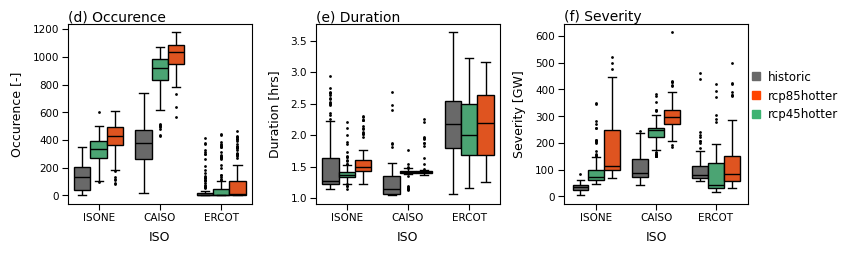

In [ ]:
ncs=len(ISOs)
cc=10
nrs=3
fig, ax = plt.subplots(nrows=1, ncols=ncs, figsize=(8, 2))
ynlabel='RE'
xnlabel='Demand'


############boxplot: drought
ir=1
xvar='Prob'
yvar='Dur'
vars=['Occ','DurMax','MaxMagEvent']
vars_labels={'Occ':'Occurence','DurMax':'Duration','MaxMagEvent':'Severity'}
vars_labels_units={'Occ':'[-]','DurMax':'[hrs]','MaxMagEvent':'[GW]'}
sces=['historic','rcp85hotter','rcp45hotter']
tmp=pd.DataFrame()
for ic in range(ncs):
    ISO=ISOs[ic]
    for sce in sces:
        DF_drought = pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_drought_hourly.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce))
        DF_drought['ISO']=ISO
        tmp=pd.concat([tmp,DF_drought])
tmp=tmp.reset_index()
tmp['MaxMagEvent']=tmp['MaxMagEvent']/1000
for ic in range(ncs):
    var=vars[ic]
    sns.boxplot(ax=ax[ic],x='ISO',y=vars[ic],data=tmp,hue='sce',palette=colorpalattes,hue_order=['historic','rcp45hotter','rcp85hotter'],
    legend=False,saturation=0.75,fliersize=1)
    ax[ic].set_ylabel(f"{vars_labels[var]} {vars_labels_units[var]}" ,labelpad=6.8)
    setsubtitle(ax[ic], vars_labels[var], nrc=[ir, ic, nrs, ncs])



plt.subplots_adjust(hspace=0.6, top=0.95, bottom=0.05, left=0.1, right=0.95,wspace=0.35)

for sce in sces:
    ax[2].plot([], [], color=colorpalattes[sce], label=sce,marker='s',linestyle='None')
ax[2].legend(loc='upper left', bbox_to_anchor=(0.92, 0.8),ncol=1,frameon=False,handletextpad=0.05)

plt.show()

/home/lyqiu/miniconda3/envs/plot/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/lyqiu/miniconda3/envs/plot/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/lyqiu/miniconda3/envs/plot/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/lyqiu/miniconda3/envs/plot/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


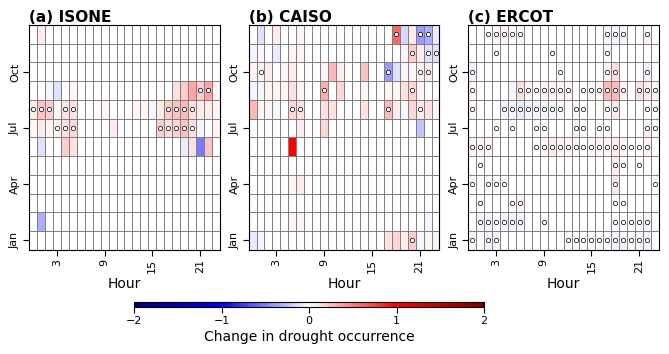

In [63]:
ncs=len(ISOs)
drought_var='Occ'
cc=0
from scipy.stats import ttest_1samp
fig,axs=plt.subplots(nrows=1, ncols=ncs, figsize=(7, 3))
for ic in range(3):
    ISO=ISOs[ic]
    for sce in ['historic','rcp85hotter']:
        DF_drought = pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,sce))
        tmp_mean=DF_drought.groupby(['Month','Hour','id']).mean(numeric_only=True)[[drought_var]]
        tmp_mean=tmp_mean.fillna(0)
        if sce=='historic':
            tmp_hist=tmp_mean.copy()
        else:
            tmp_future=tmp_mean.copy()
    tmp_diff=tmp_future-tmp_hist
    tmp_diff=tmp_diff.reset_index()
    tmp_diff_mean=tmp_diff.groupby(['Month','Hour']).mean(numeric_only=True)
    tmp_diff_std = tmp_diff.groupby(['Month', 'Hour']).std(numeric_only=True)

    t_stat_list = []
    p_value_list = []
    for (month, hour), group in tmp_diff.groupby(['Month', 'Hour']):
        if len(group) > 1:  # Ensure there is more than one sample in each group
            t_stat, p_value = ttest_1samp(group[drought_var], popmean=0, nan_policy='omit')
        else:
            t_stat, p_value = np.nan, np.nan  # If there's only one value, t-test isn't possible

        t_stat_list.append({'Month': month, 'Hour': hour, 't_stat': t_stat, 'p_value': p_value})
    # Convert results to DataFrame
    t_stat_df = pd.DataFrame(t_stat_list)

    t_stat_df['significant'] = t_stat_df['p_value'] < 0.05
    
    pivot_mean = tmp_diff_mean.reset_index().pivot(index='Month', columns='Hour', values=drought_var).sort_index(ascending=False)
    pivot_significance = t_stat_df.pivot(index='Month', columns='Hour', values='significant').sort_index(ascending=False)
    sns.heatmap(data=pivot_mean, cmap=cmaps.BlWhRe, cbar=False, linewidths=0.5, linecolor='grey', vmin=-2, vmax=2, ax=axs[ic])
    # Overlay significant points (e.g., white dots) where p < 0.05
    axs[ic].scatter(
        x=np.where(pivot_significance.values)[1] + 0.5,  # Adjusted for heatmap grid
        y=np.where(pivot_significance.values)[0] + 0.5,
        color='white', s=10, edgecolors='black', linewidth=0.5
    )
    axs[ic].set_xlabel('Hour')
    axs[ic].set_ylabel('')
    axs[ic].set_xticks([3.5,9.5,15.5,21.5])
    axs[ic].set_xticklabels(['3','9','15','21'])
    axs[ic].set_yticks([2.5,5.5,8.5,11.5])
    axs[ic].set_yticklabels(['Oct','Jul','Apr','Jan'],rotation=90)
    # ADD a frame around the heatmap
    for _, spine in axs[ic].spines.items():
        spine.set_visible(True)
    setsubtitle(axs[ic], f"{ISOs[ic]}", ni=ic)
plt.subplots_adjust(hspace=0.4, top=0.95, bottom=0.2, left=0.05, right=0.95,wspace=0.15)
cbar_ax = fig.add_axes([0.2, 0.01, 0.5, 0.015])
cbar = plt.colorbar(axs[ic].collections[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('Change in drought occurrence')
cbar.set_ticks([-2, -1, 0, 1, 2])
plt.savefig(f'{figdir}/change_drought_occ.pdf', bbox_inches='tight', dpi=300)
plt.show()



# resource

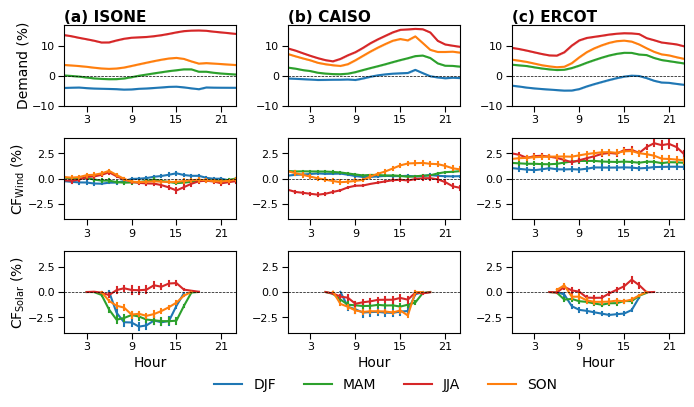

In [71]:
ls={'historic':'-','rcp85hotter':'-','rcp45hotter':'-.'}
cc=0
ncs=len(ISOs)
for ffsce in ['rcp85hotter']:
    fig,axs_ge=plt.subplots(3,3,figsize=(8,4))
    for ic in range(ncs):
        ISO=ISOs[ic]
        heatmap_ens_tmp=[]
        for eid in range(1,maxsce+1):
            for sce in ['historic',ffsce]:
                DF_LL= pd.read_csv('%s/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthmean.csv' %
                                            (anadir,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00))
                DF_LL['Season']=DF_LL['Month'].apply(get_season)
                if sce=='historic':
                    meandemand=DF_LL['demand'].mean()
                DF_LL['demand']=DF_LL['demand']/meandemand*100
                DF_LL_mean=DF_LL.groupby(['Season','Hour']).mean(numeric_only=True)
                if sce=='historic':
                    supper_hist=DF_LL_mean.copy()
                else:
                    supper_future=DF_LL_mean.copy()

            heatmap_data = (supper_future-supper_hist)
            heatmap_data=heatmap_data.replace(0,np.nan)
            heatmap_data['ens']=eid
            heatmap_ens_tmp.append(heatmap_data)
        heatmap_ens = pd.concat(heatmap_ens_tmp)
        heatmap_ens_mean=heatmap_ens.groupby(['Season','Hour']).mean(numeric_only=True)
        heatmap_ens=heatmap_ens.reset_index()
        loadvar='cf'
        for ir in range(3):
            if ir>0:
                sns.lineplot(ax=axs_ge[ir][ic],data=heatmap_ens,hue='Season',x='Hour',y=f'{loadvar}_{techs_RE[ir-1]}',palette=colorpalattes,legend=False,linestyle=ls[ffsce],errorbar='sd',err_style='bars')
                axs_ge[ir][ic].set_ylim([-4,4])
            else:
                sns.lineplot(ax=axs_ge[ir][ic],data=heatmap_ens,hue='Season',x='Hour',y='demand',palette=colorpalattes,legend=False,linestyle=ls[ffsce])
                axs_ge[ir][ic].set_ylim([-10,17])
            
            axs_ge[ir][ic].hlines(y=0,xmin=0,xmax=23,linestyle='--',color='black',linewidth=0.5)
            axs_ge[ir][ic].set_xlim([0,23])
            axs_ge[ir][ic].set_xticks([3,9,15,21])
            if ic==0:
                if ir==0:
                    axs_ge[ir][ic].set_ylabel('Demand (%)',labelpad=0.5)
                elif ir==1:
                    axs_ge[ir][ic].set_ylabel(r'CF$_\text{Wind}$ (%)',labelpad=0.5)
                else:
                    axs_ge[ir][ic].set_ylabel(r'CF$_\text{Solar}$ (%)',labelpad=0.5)
            else:
                axs_ge[ir][ic].set_ylabel('')
            if ir==2:
                axs_ge[ir][ic].set_xlabel('Hour')
            else:
                axs_ge[ir][ic].set_xlabel('')
        setsubtitle(axs_ge[0][ic], f"{ISOs[ic]}", ni=ic)
        # axs_ge[0][ic].set_title(f"{ISO}")
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    #legend
    for season in ['DJF','MAM','JJA','SON']:
        axs_ge[0][0].plot([], [], color=colorpalattes[season], label=season,linestyle='-')
    axs_ge[0][0].legend(loc='upper left', bbox_to_anchor=(0.8, -3.2),ncol=4,frameon=False)
    plt.savefig(f'{figdir}/seasonalchange_{ffsce}.pdf', bbox_inches='tight', dpi=300)


# Factor

In [100]:
cc=10
tmp=pd.DataFrame()
for ic in range(ncs):
    ISO=ISOs[ic]
    sdata_limited=pd.read_csv('%s/dispatch/Results_%s_%s4/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
    sdata_limited_load=sdata_limited[(sdata_limited['test_sce']=='rcp85hotter')&(sdata_limited['upper_bound_CCGT']==cc/100)][['total_LL','prod_CCGT','inv_ens_id']]
    sdata_unlimited=pd.read_csv('%s/dispatch_unlimited/Results_%s_%s4/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
    sdata_unlimited_load=sdata_unlimited[(sdata_unlimited['test_sce']=='rcp85hotter')&(sdata_unlimited['upper_bound_CCGT']==cc/100)][['total_LL','prod_CCGT','inv_ens_id']]
    sdata_limited_load=sdata_limited_load.set_index('inv_ens_id')
    sdata_unlimited_load=sdata_unlimited_load.set_index('inv_ens_id')
    sdata_merged=(sdata_unlimited_load-sdata_limited_load)/sdata_limited_load*100
    sdata_merged['ISO']=ISO
    tmp=pd.concat([tmp,sdata_merged])
tmp=tmp.reset_index()
#tmp['Cost of Energy Drought']=tmp['total_LL']+tmp['Cost of Energy Drought']

In [52]:
ncs=len(ISOs)
yvar='Occ'
vars_labels={'Occ':'Occurence','DurMax':'Duration','MaxMagEvent':'Severity'}
vars_labels_units={'Occ':'[-]','DurMax':'[hrs]','MaxMagEvent':'[GW]'}
sces=['historic','rcp85hotter','rcp45hotter']


vars=['Total','RE','cf_solar-UPV','cf_wind-onshore','solar_sv','wind_sv','wind_solar']
vars_sel=['Total','RE','cf_solar-UPV','cf_wind-onshore']
ccs=[0,10]
order=['Total','RE','wind_solar','solar_sv','wind_sv','cf_solar-UPV','cf_wind-onshore',]
vars_label=[r'Cost$_{Total}$',r'Cap$_{RE}$','Complementarity',r'SV$_{Solar}$',r'SV$_{Wind}$',r'CF$_{Solar}$',r'CF$_{Wind}$']

for ic in range(1):
    cc=ccs[ic]
    for ica in range(3):
        ISO=ISOs[ica]
        for ir in range(2):
            sce=sces[ir]           
            mean_tmp=[]
            for eid in range(1,121):
                DF_LL_mean= pd.read_csv('%s/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthmean.csv' %
                                                (anadir,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00))
                df=DF_LL_mean.copy()
                df=df.mean().to_frame().T
                df['id']=eid
                df=df.set_index('id')
                mean_tmp.append(df)
            mean_tmp=pd.concat(mean_tmp)
            mean_tmp.to_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthmean_mean.csv' %
                                                (anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00))
            
            corr_tmp=[]
            for eid in range(1,121):
                DF_LL_corr= pd.read_csv('%s/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthcorr.csv' %
                                                (anadir,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00))
                DF_LL_corr=DF_LL_corr.set_index('level_2')
                wind_solar=DF_LL_corr.loc['prod_solar-UPV','prod_wind-onshore']
                wind_solar=wind_solar.mean()
                wind_solar=-wind_solar
                df=pd.DataFrame({'wind_solar':wind_solar},index=[eid])
                corr_tmp.append(df)
            corr_tmp=pd.concat(corr_tmp)
            corr_tmp.to_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthcorr_mean.csv' %
                                                (anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00))
            
            for tech in ['wind-onshore','solar-UPV']:
                std_tmp=[]
                for eid in range(1,121):
                    std= pd.read_csv('%s/investment/Results_%s_%s_cf/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%s_sptialvar.csv' %
                                            (mdir, ISO, demandsce,ny, eid, demandsce,ISO, cc, land, mdl,'historic',sce,tech))
                    mean_std=std[['capacity_factor']].mean().to_frame().T
                    mean_std['id']=eid
                    std_tmp.append(mean_std)
                std_tmp=pd.concat(std_tmp)
                if tech=='wind-onshore':
                    std_tmp=std_tmp.rename(columns={'capacity_factor':'wind_sv'}).set_index('id')
                elif tech=='solar-UPV':
                    std_tmp=std_tmp.rename(columns={'capacity_factor':'solar_sv'}).set_index('id')
                std_tmp.to_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%s_Load_sptialvar_mean.csv' %
                                                (anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, tech))




/tmp/ipykernel_719232/4218007113.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(vars_labels.values(),fontsize=10)


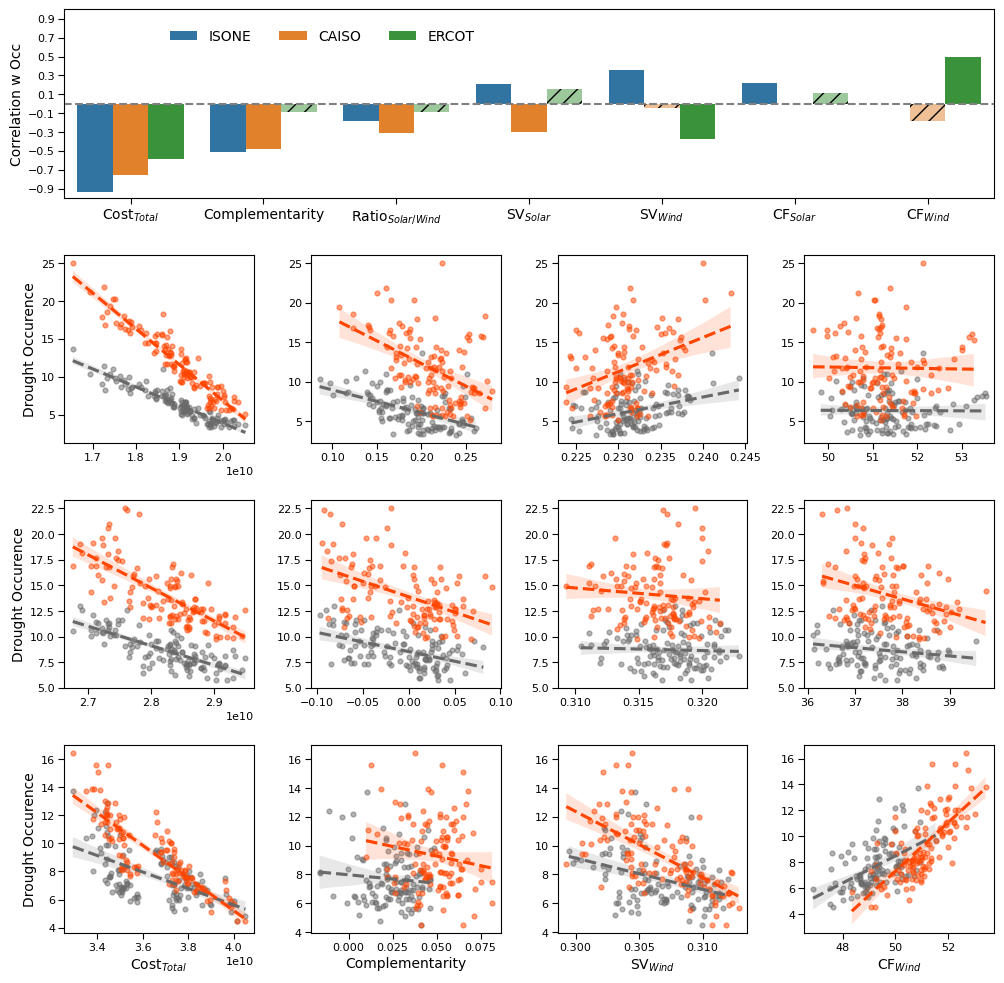

In [72]:
ncs=len(ISOs)
yvar='Occ'
vars_labels={'Occ':'Occurence','DurMax':'Duration','MaxMagEvent':'Severity'}
vars_labels_units={'Occ':'[-]','DurMax':'[hrs]','MaxMagEvent':'[GW]'}
sces=['historic','rcp85hotter']
fig = plt.figure(figsize=(12, 12))  # Adjust size as needed
gs=gridspec.GridSpec(4, 4)

vars=['Total','SolarR','cf_solar-UPV','cf_wind-onshore','solar_sv','wind_sv','wind_solar']
vars_sel=['Total','wind_solar','wind_sv','cf_wind-onshore']
ccs=[0,10]
order=['Total','wind_solar','SolarR','solar_sv','wind_sv','cf_solar-UPV','cf_wind-onshore',]
vars_labels={'Total':r'Cost$_{Total}$',
             'wind_solar':'Complementarity','SolarR':r'Ratio$_{Solar/Wind}$','solar_sv':r'SV$_{Solar}$',
             'wind_sv':r'SV$_{Wind}$','cf_solar-UPV':r'CF$_{Solar}$','cf_wind-onshore':r'CF$_{Wind}$'}

invsce='historic'
axes = [[fig.add_subplot(gs[row, col]) for col in range(4)] for row in range(1,4)]
for ic in range(1):
    cc=ccs[ic]
    DF=pd.DataFrame()
    for ica in range(3):
        ISO=ISOs[ica]
        for ir in range(2):
            sce=sces[ir]
            tmpISO=pd.DataFrame()
            cp_data_full=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
            cp_data=get_df(cp_data_full,scenario='historic',cg=cc/100)
            cp_data=cp_data.reset_index().set_index('inv_ens_id')
            DF_drought = pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,sce),index_col='id')
            DF_drought=DF_drought.groupby(['id']).mean(numeric_only=True)
            DF_drought['ISO']=ISO
            DF_drought['sce']=sce
            tmpISO=pd.merge(DF_drought,cp_data,right_index=True,left_index=True)
            tmpISO=tmpISO.rename(columns={'total_cost':'Total','capacity_strg':'Storage','capacity_solar-UPV':'Solar','capacity_wind-onshore':'Wind','capacity_RE':'RE','capacity_CCGT':'CCGT'})
            tmpISO=tmpISO.drop(columns=['prod_solar-UPV','prod_wind-onshore'])
            tmpISO['RE']=tmpISO['Solar']+tmpISO['Wind']
            tmpISO['SolarR']=tmpISO['Solar']/tmpISO['Wind']
            

            mean_tmp=pd.read_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthmean_mean.csv' %
                                                (anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00),index_col='id')
            prod_mean=mean_tmp[['prod_solar-UPV','prod_wind-onshore']].copy()
            mean_tmp=mean_tmp[vars[2:4]]
            
            tmpISO=pd.merge(tmpISO,mean_tmp,left_index=True,right_index=True)
            
            corr_tmp=pd.read_csv('./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthcorr_mean.csv' %(ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00),index_col='Unnamed: 0')
            
            tmpISO=pd.merge(tmpISO,corr_tmp,left_index=True,right_index=True)

            for tech in ['wind-onshore','solar-UPV']:
                std_tmp=pd.read_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%s_Load_sptialvar_mean.csv' %
                                                (anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, tech),index_col='id')
                tmpISO=pd.merge(tmpISO,std_tmp,left_index=True,right_index=True)

    
            tmpISO['wind_sv']=tmpISO['wind_sv']
            tmpISO['solar_sv']=tmpISO['solar_sv']

            if sce=='historic':
                for var in vars:
                    corr, p_value = pearsonr(tmpISO[yvar], tmpISO[var])
                    df=pd.DataFrame({'ISO':[ISO],'sce':[sce],'cc':[cc],'corr':[corr],'p_value':[p_value],'x':[var],'y':[yvar]})
                    DF=pd.concat([DF,df])

                
            for ic in range(4):
                varh=vars_sel[ic]
                sns.regplot(data=tmpISO,x=varh,y=yvar,ax=axes[ica][ic],
                            scatter=True,x_ci='sd', color=colorpalattes[sce],line_kws={'linestyle':'--'},
                            scatter_kws={'s':12,'alpha':0.5,'color':colorpalattes[sce]})
                if ic==0:
                    axes[ica][ic].set_ylabel('Drought Occurence')
                else:
                    axes[ica][ic].set_ylabel('')
                if ica==2:
                    axes[ica][ic].set_xlabel(vars_labels[varh])
                else:
                    axes[ica][ic].set_xlabel('')

DF['corr']=np.where(np.isnan(DF['corr']),0.0001,DF['corr'])  
DF['x']=pd.Categorical(DF['x'], categories=order, ordered=True)
DF=DF.sort_values('x')
DF_significant=DF.copy()
DF_nonsig=DF.copy()
DF_significant['corr']=DF_significant['corr']*(DF_significant['p_value']<0.05).astype(int) 
DF_nonsig['corr']=DF_nonsig['corr']*(DF_nonsig['p_value']>=0.05).astype(int)

ax1=fig.add_subplot(gs[0, :])
sns.barplot(data=DF_significant,x='x',y='corr',hue='ISO',ax=ax1,legend=True,hue_order=ISOs)
sns.barplot(data=DF_nonsig,x='x',y='corr',hue='ISO',ax=ax1,legend=False,alpha=0.5,hatch='//',hue_order=ISOs)
#setsubtitle(axs[ii], f"{sce}-{100-cc}% PL", nrc=[ir, ic, 2, 2])
ax1.set_ylabel(f'Correlation w {yvar}')
ax1.set_xlabel(f'')
ax1.set_ylim(-1,1)
ax1.axhline(0,linestyle='--',color='grey')
ax1.set_xticklabels(vars_labels.values(),fontsize=10)
ax1.set_yticks(np.arange(-0.9, 1.1, 0.2))
# ax1.axhline(0.7,linestyle='--',color='grey')
# ax1.axhline(-0.7,linestyle='--',color='grey')
# ax1.axhline(0.5,linestyle='--',color='grey')
# ax1.axhline(-0.5,linestyle='--',color='grey')
# axs[1].set_xlabel(f'Total Cost [B$]')
# axs[2].set_xlabel(r'CF$_{Solar}$, 5-7 AM')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(0.1, 0.96), ncol=3,title='',frameon=False)
plt.subplots_adjust(wspace=0.3,hspace=0.3)
#plt.tight_layout()
plt.show()

/tmp/ipykernel_719232/1194425147.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(vars_labels.values(),fontsize=9)


else
else
else


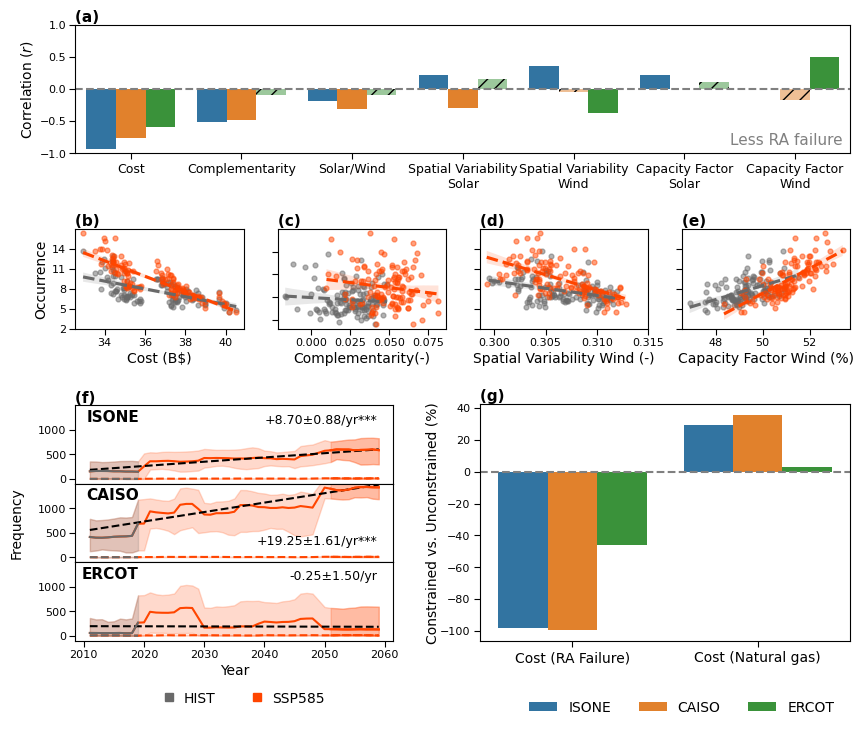

In [73]:
ncs=len(ISOs)
yvar='Occ'
vars_labels={'Occ':'Occurence','DurMax':'Duration','MaxMagEvent':'Severity'}
vars_labels_units={'Occ':'[-]','DurMax':'[hrs]','MaxMagEvent':'[GW]'}
sces=['historic','rcp85hotter']
fig = plt.figure(figsize=(10, 8))  # Adjust size as needed
gs=gridspec.GridSpec(5, 4,height_ratios=[4.5,3.5,1,1,1],hspace=1.2)

vars=['Total','SolarR','cf_solar-UPV','cf_wind-onshore','solar_sv','wind_sv','wind_solar']
vars_sel=['Total','wind_solar','wind_sv','cf_wind-onshore']
ccs=[0,10]
order=['Total','wind_solar','SolarR','solar_sv','wind_sv','cf_solar-UPV','cf_wind-onshore',]
vars_labels={'Total':'Cost',
             'wind_solar':'Complementarity','SolarR':'Solar/Wind','solar_sv':'Spatial Variability\nSolar',
             'wind_sv':'Spatial Variability\nWind',
             'cf_solar-UPV':'Capacity Factor\nSolar','cf_wind-onshore':'Capacity Factor\nWind'}

invsce='historic'
axes = [fig.add_subplot(gs[1, col]) for col in range(4)]

cc=0
DF=pd.DataFrame()
for ica in range(3):
    ISO=ISOs[ica]
    for ir in range(2):
        sce=sces[ir]
        tmpISO=pd.DataFrame()
        cp_data_full=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
        cp_data=get_df(cp_data_full,scenario='historic',cg=cc/100)
        cp_data=cp_data.reset_index().set_index('inv_ens_id')
        DF_drought = pd.read_csv('./Analysis_drought_free/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce),index_col='id')
        DF_drought=DF_drought.groupby(['id']).mean(numeric_only=True)
        DF_drought['ISO']=ISO
        DF_drought['sce']=sce
        tmpISO=pd.merge(DF_drought,cp_data,right_index=True,left_index=True)
        tmpISO=tmpISO.rename(columns={'total_cost':'Total','capacity_strg':'Storage','capacity_solar-UPV':'Solar','capacity_wind-onshore':'Wind','capacity_RE':'RE','capacity_CCGT':'CCGT'})
        tmpISO=tmpISO.drop(columns=['prod_solar-UPV','prod_wind-onshore'])
        tmpISO['RE']=tmpISO['Solar']+tmpISO['Wind']
        tmpISO['SolarR']=tmpISO['Solar']/tmpISO['Wind']
        
        mean_tmp=pd.read_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthmean_mean.csv' %
                                            (anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00),index_col='id')
        prod_mean=mean_tmp[['prod_solar-UPV','prod_wind-onshore']].copy()
        mean_tmp=mean_tmp[vars[2:4]]
        
        tmpISO=pd.merge(tmpISO,mean_tmp,left_index=True,right_index=True)

        corr_tmp=pd.read_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthcorr_mean.csv' %(anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00),index_col='Unnamed: 0')

        tmpISO=pd.merge(tmpISO,corr_tmp,left_index=True,right_index=True)

        for tech in ['wind-onshore','solar-UPV']:
            std_tmp=pd.read_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%s_Load_sptialvar_mean.csv' %
                                            (anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, tech),index_col='id')
            tmpISO=pd.merge(tmpISO,std_tmp,left_index=True,right_index=True)

        if sce=='historic':
            for var in vars:
                corr, p_value = pearsonr(tmpISO[yvar], tmpISO[var])
                df=pd.DataFrame({'ISO':[ISO],'sce':[sce],'cc':[cc],'corr':[corr],'p_value':[p_value],'x':[var],'y':[yvar]})
                DF=pd.concat([DF,df])
        tmpISO['Total']=tmpISO['Total']/1000/1000/1000
        if ISO=='ERCOT':    
            for ic in range(4):
                varh=vars_sel[ic]
                sns.regplot(data=tmpISO,x=varh,y=yvar,ax=axes[ic],
                            scatter=True,x_ci='sd', color=colorpalattes[sce],line_kws={'linestyle':'--'},
                            scatter_kws={'s':12,'alpha':0.5,'color':colorpalattes[sce]})
                axes[ic].set_yticks(np.arange(2, 17, 3))
                if ic==0:
                    axes[ic].set_ylabel('Occurrence')
                else:
                    axes[ic].set_ylabel('')
                    axes[ic].set_yticklabels([])
                axes[ic].set_xlabel(vars_labels[varh] + '(-)')
                setsubtitle(axes[ic], f"", ni=ic+1)
            axes[0].set_xlabel('Cost (B$)')
            axes[2].set_xlabel('Spatial Variability Wind (-)')
            axes[3].set_xlabel('Capacity Factor Wind (%)')
axes[2].set_xticks(np.arange(0.30, 0.315, 0.005))
DF['corr']=np.where(np.isnan(DF['corr']),0.0001,DF['corr'])  
DF['x']=pd.Categorical(DF['x'], categories=order, ordered=True)
DF=DF.sort_values('x')
DF_significant=DF.copy()
DF_nonsig=DF.copy()
DF_significant['corr']=DF_significant['corr']*(DF_significant['p_value']<0.05).astype(int) 
DF_nonsig['corr']=DF_nonsig['corr']*(DF_nonsig['p_value']>=0.05).astype(int)

ax1=fig.add_subplot(gs[0, :])
sns.barplot(data=DF_significant,x='x',y='corr',hue='ISO',ax=ax1,legend=False,hue_order=ISOs)
sns.barplot(data=DF_nonsig,x='x',y='corr',hue='ISO',ax=ax1,legend=False,alpha=0.5,hatch='//',hue_order=ISOs)
ax1.set_ylabel(r'Correlation ($r$)')
ax1.set_xlabel(f'')
ax1.set_ylim(-1,1)
ax1.axhline(0,linestyle='--',color='grey')
ax1.set_xticklabels(vars_labels.values(),fontsize=9)
ax1.set_yticks(np.arange(-1, 1.5, 0.5))
ax1.text(0.99,0.1,'Less RA failure',fontsize=11,ha='right',va='center',color='grey',
         transform=ax1.transAxes)
setsubtitle(ax1, f"", ni=0)

cc=10
cmdir="/orcd/nese/mhowland/001/lyqiu/GODEEP/optimization/"
ax2=fig.add_subplot(gs[2:5, 2:4])
tmp=pd.DataFrame()
for ic in range(ncs):
    ISO=ISOs[ic]
    for lica in ['limited','unlimited']:
        if lica=='limited':
            sdata_tmp=pd.read_csv('%s/dispatch/Results_%s_%s4/TGW_%s_General_Results.csv'%(cmdir,ISO,demandsce,ISO))
        else:
            sdata_tmp=pd.read_csv('%s/dispatch_unlimited/Results_%s_%s4/TGW_%s_General_Results.csv'%(cmdir,ISO,demandsce,ISO))
        sdata_tmp_load=sdata_tmp[(sdata_tmp['test_sce']=='rcp85hotter')&(sdata_tmp['upper_bound_CCGT']==cc/100)][['total_LL','prod_CCGT','inv_ens_id','fuel_cost_CCGT']]
        sdata_tmp_load=sdata_tmp_load.set_index('inv_ens_id')
        sdata_tmp_load['Operation Cost']=sdata_tmp_load['total_LL']+sdata_tmp_load['fuel_cost_CCGT']
        if lica=='limited':
            sdata_limited_load=sdata_tmp_load.copy()
        else:
            sdata_unlimited_load=sdata_tmp_load.copy()
            
    sdata_merged=(sdata_unlimited_load-sdata_limited_load)/sdata_limited_load*100
    sdata_merged['ISO']=ISO
    tmp=pd.concat([tmp,sdata_merged])
tmp=tmp.reset_index()
tmp=tmp.rename(columns={'total_LL':'Cost (RA Failure)','fuel_cost_CCGT':'Cost (Natural gas)'}) 
tmp= tmp.melt(id_vars=['inv_ens_id','ISO'],value_vars=['Cost (RA Failure)','Cost (Natural gas)'])
sns.barplot(data=tmp,x='variable',y='value',hue='ISO',ax=ax2,legend=True,errorbar=None,hue_order=ISOs)
ax2.set_ylabel(r'Constrained vs. Unconstrained (%)',labelpad=0.5)
ax2.axhline(0,linestyle='--',color='grey')
ax2.set_xlabel('')
ax2.tick_params(axis='x', labelsize=10,pad=3.5)
setsubtitle(ax2, "", ni=6)

cc=10
var='occ'
ax_time=[]
for ir in range(3):
    ISO=ISOs[ir]
    ax_time.append(fig.add_subplot(gs[2+ir, 0:2]))
    for ik in range(2):
        if ik==0:
            hist=pd.read_csv('./Analysis_drought/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,'historic'))
        else:
            hist=pd.read_csv('./Analysis_drought/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%sun_heatmap.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,'historic'))
        hist =hist[(hist['Year']!=2010) & (hist['Year']!=2049)]
        minyear=hist['Year'].min()
        maxyear=hist['Year'].max() 
        new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
        hist=hist.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
        hist=hist.groupby(['id','Year']).sum(numeric_only=True)
        sce='rcp85hotter'
        future=hist
        for pid in range(1,5):
            if ik==0:
                futuretmp = pd.read_csv('./Analysis_drought/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_%d.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce,pid))
            else:
                futuretmp = pd.read_csv('./Analysis_drought/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%sun_heatmap_%d.csv'%(ny,demandsce,ISO,cc,land,mdl,invsce,sce,pid))
            futuretmp =futuretmp[(futuretmp['Year']!=2010) & (futuretmp['Year']!=2049)]
            minyear=futuretmp['Year'].min()
            maxyear=futuretmp['Year'].max()
            new_index=pd.MultiIndex.from_product([range(minyear,maxyear+1),range(1,13),range(0,24),range(1,121)],names=['Year','Month','Hour','id'])
            futuretmp=futuretmp.set_index(['Year','Month','Hour','id']).reindex(new_index).fillna(0).reset_index()
            futuretmp=futuretmp.groupby(['id','Year']).sum(numeric_only=True)
            future=pd.concat([future,futuretmp])
        future['sce']=sce
        yearmean=future.rolling(window=7).mean(numeric_only=True).dropna().reset_index()
        if ik==0:
            sns.lineplot(data=yearmean,x='Year',y=var,ax=ax_time[ir],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
            grouped=yearmean.groupby('Year').mean().reset_index()
            X = grouped['Year'].values.reshape(-1, 1)
            y=grouped[var].values
            model=TheilSenRegressor().fit(X, y)
            y_pred = model.predict(X)
            slope = model.coef_[0]
            mad = median_abs_deviation(y, scale='normal')
            slope_std = mad / (np.sqrt(len(y)) * np.std(X)) 
            mk_result = mk.original_test(y)
            p_value = mk_result.p
            ax_time[ir].plot(grouped['Year'],y_pred,label=f'slope={slope:.2f}, p={p_value:.2f}',color='k',linestyle='--')
            stars=get_sig_stars(p_value)
            ytex=[0.9,0.35,0.9]
            ax_time[ir].text(0.95,ytex[ir], 
                    f"{slope:+.2f}±{slope_std:.2f}/yr{stars}", fontsize=9, ha='right', va='top', transform=ax_time[ir].transAxes)
            ax_time[ir].text(0.2,0.95,ISO, fontsize=11, ha='right', va='top', transform=ax_time[ir].transAxes,fontweight='bold')
            sns.lineplot(data=yearmean[yearmean['Year']<2020],x='Year',y=var,ax=ax_time[ir],legend=False,errorbar=('pi', 90),color=colorpalattes['historic'])
            sns.lineplot(data=yearmean[yearmean['Year']>2050],x='Year',y=var,ax=ax_time[ir],legend=False,errorbar=('pi', 90),color=colorpalattes[sce])
        else:
            print('else')
            sns.lineplot(data=yearmean,x='Year',y=var,ax=ax_time[ir],legend=False,errorbar=('pi', 90),color=colorpalattes[sce],linestyle='--')
            sns.lineplot(data=yearmean[yearmean['Year']<2020],x='Year',y=var,ax=ax_time[ir],legend=False,errorbar=('pi', 90),color=colorpalattes['historic'],linestyle='--')
            sns.lineplot(data=yearmean[yearmean['Year']>2050],x='Year',y=var,ax=ax_time[ir],legend=False,errorbar=('pi', 90),color=colorpalattes[sce],linestyle='--')
        ax_time[ir].set_ylabel('')
        ax_time[ir].set_ylim([-100, 1500])
        ax_time[ir].set_yticks(np.arange(0, 1500, 500))
ax_time[1].set_ylabel('Frequency', labelpad=10)
for ir in range(3):
    axt1=ax_time[0]
    axt2=ax_time[1]
    axt3=ax_time[2]
    pos1 = axt1.get_position()
    pos2 = axt2.get_position()
    pos3 = axt3.get_position()
    axt1.set_xlabel('')
    axt1.set_xticklabels([])
    newheight=pos1.height*1.4
    newwidth=pos1.width*0.95
    axt1.set_position([pos1.x0, pos3.y0+2*newheight, newwidth, newheight])
    axt2.set_xlabel('')
    axt2.set_xticklabels([])
    axt2.set_position([pos2.x0, pos3.y0+newheight, newwidth, newheight])
    axt3.set_position([pos3.x0, pos3.y0, newwidth, newheight])
setsubtitle(axt1, "", ni=5)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(0.1,-0.2 ), ncol=3,title='',frameon=False)
ir=3
for sce in ['historic','rcp85hotter']:
    axes[1].plot([], [], color=colorpalattes[sce], label=scenario_labels[sce],marker='s',linestyle='None')
axes[1].legend(loc='upper left', bbox_to_anchor=(-0.8, -3.5),ncol=2,frameon=False,handletextpad=0.05,fontsize=10)
plt.savefig(f'{figdir}/factors.pdf',bbox_inches='tight', dpi=300)
plt.show()

In [156]:
cc=10
ax2=fig.add_subplot(gs[2:5, 2:4])
tmp=pd.DataFrame()
for ic in range(ncs):
    ISO=ISOs[ic]
    for lica in ['limited','unlimited']:
        if lica=='limited':
            sdata_tmp=pd.read_csv('%s/dispatch/Results_%s_%s4/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
        else:
            sdata_tmp=pd.read_csv('%s/dispatch_unlimited/Results_%s_%s4/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
        sdata_tmp_load=sdata_tmp[(sdata_tmp['test_sce']=='rcp85hotter')&(sdata_tmp['upper_bound_CCGT']==cc/100)][['total_LL','prod_CCGT','inv_ens_id','fuel_cost_CCGT']]
        sdata_tmp_load=sdata_tmp_load.set_index('inv_ens_id')
        sdata_tmp_load['Operation Cost']=sdata_tmp_load['total_LL']+sdata_tmp_load['fuel_cost_CCGT']
        if lica=='limited':
            sdata_limited_load=sdata_tmp_load.copy()
        else:
            sdata_unlimited_load=sdata_tmp_load.copy()
            
    sdata_merged=(sdata_unlimited_load-sdata_limited_load)/sdata_limited_load*100
    sdata_merged['ISO']=ISO
    tmp=pd.concat([tmp,sdata_merged])
tmp=tmp.reset_index()
tmp=tmp.rename(columns={'total_LL':'Cost (RA Failure)','fuel_cost_CCGT':'Cost (Natural gas)'}) 
tmp= tmp.melt(id_vars=['inv_ens_id','ISO'],value_vars=['Cost (RA Failure)','Cost (Natural gas)'])
sns.barplot(data=tmp,x='variable',y='value',hue='ISO',ax=ax2,legend=True,errorbar=None,hue_order=ISOs)
ax2.set_ylabel(r'Constrained vs. Unconstrained (%)',labelpad=0.5)
ax2.axhline(0,linestyle='--',color='grey')
ax2.set_xlabel('')
ax2.tick_params(axis='x', labelsize=10,pad=3.5)
setsubtitle(ax2, "", ni=6)

In [158]:
sdata_limited_load

,total_LL,prod_CCGT,fuel_cost_CCGT,Operation Cost
inv_ens_id,,,,
1,1.621318e+06,38105663.93,1321441551,1.323063e+09
2,4.377269e+06,38105663.93,1321441551,1.325819e+09
3,3.983206e+06,38105663.93,1321441551,1.325425e+09
4,4.170485e+06,38105663.93,1321441551,1.325612e+09
5,5.046972e+06,38105663.93,1321441551,1.326489e+09
...,...,...,...,...
116,8.305987e+05,38105663.93,1321441551,1.322272e+09
117,3.726807e+05,38105663.93,1321441551,1.321814e+09
118,1.077090e+06,38105663.93,1321441551,1.322519e+09


In [157]:
sdata_unlimited_load

,total_LL,prod_CCGT,fuel_cost_CCGT,Operation Cost
inv_ens_id,,,,
1,54691.056876,3.967502e+07,1.375864e+09,1.375919e+09
2,84569.028457,4.240046e+07,1.470378e+09,1.470463e+09
3,104086.625326,4.198844e+07,1.456090e+09,1.456194e+09
4,76572.756440,4.220234e+07,1.463507e+09,1.463584e+09
5,105094.754327,4.305066e+07,1.492926e+09,1.493031e+09
...,...,...,...,...
116,47769.444593,3.888995e+07,1.348639e+09,1.348687e+09
117,57951.522349,3.842123e+07,1.332385e+09,1.332443e+09
118,32044.730276,3.915124e+07,1.357701e+09,1.357733e+09


In [74]:
ncs=len(ISOs)
scenarios=['historic','rcp85hotter']

from scipy.stats import linregress
cc=0
DF=pd.DataFrame()

for ica in range(3):
    ISO=ISOs[ica]
    for ir in range(2):
        sce=scenarios[ir]
        tmpISO=pd.DataFrame()
        cp_data_full=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
        cp_data=get_df(cp_data_full,scenario='historic',cg=cc/100)
        cp_data=cp_data.reset_index().set_index('inv_ens_id')
        DF_drought = pd.read_csv('%s/OutSampleDispatch_ny_%d_demand_%s_%s_cc_%d_landr_%d_%s_inv_%s_test_%s_heatmap_annual.csv'%(anadir,ny,demandsce,ISO,cc,land,mdl,invsce,sce),index_col='id')
        DF_drought=DF_drought.groupby(['id']).mean(numeric_only=True)
        DF_drought['ISO']=ISO
        DF_drought['sce']=sce
        tmpISO=pd.merge(DF_drought,cp_data,right_index=True,left_index=True)
        tmpISO=tmpISO.rename(columns={'total_cost':'Total','capacity_strg':'Storage','capacity_solar-UPV':'Solar','capacity_wind-onshore':'Wind','capacity_RE':'RE','capacity_CCGT':'CCGT'})
        tmpISO=tmpISO.drop(columns=['prod_solar-UPV','prod_wind-onshore'])
        tmpISO['RE']=tmpISO['Solar']+tmpISO['Wind']
        tmpISO['SolarR']=tmpISO['Solar']/tmpISO['Wind']
        
        mean_tmp=pd.read_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthmean_mean.csv' %
                                            (anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00),index_col='id')
        prod_mean=mean_tmp[['prod_solar-UPV','prod_wind-onshore']].copy()
        mean_tmp=mean_tmp[vars[2:4]]
        
        tmpISO=pd.merge(tmpISO,mean_tmp,left_index=True,right_index=True)

        corr_tmp=pd.read_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonthcorr_mean.csv' %(anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00),index_col='Unnamed: 0')

        tmpISO=pd.merge(tmpISO,corr_tmp,left_index=True,right_index=True)

        for tech in ['wind-onshore','solar-UPV']:
            std_tmp=pd.read_csv('%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%s_Load_sptialvar_mean.csv' %
                                            (anadir,ny, demandsce,ISO, cc, land, mdl,'historic',sce, tech),index_col='id')
            tmpISO=pd.merge(tmpISO,std_tmp,left_index=True,right_index=True)

        for var in vars:
            

            # Fit linear regression
            slope, intercept, r_value, p_value, std_err = linregress(tmpISO[yvar], tmpISO[var])


            corr, p_value = pearsonr(tmpISO[yvar], tmpISO[var])
            df=pd.DataFrame({'ISO':[ISO],'sce':[sce],'cc':[cc],'corr':[corr],'slope':[slope],'p_value':[p_value],'x':[var],'y':[yvar]})
            DF=pd.concat([DF,df])


DF['corr']=np.where(np.isnan(DF['corr']),0.0001,DF['corr'])  
DF['x']=pd.Categorical(DF['x'], categories=order, ordered=True)
DF=DF.sort_values('x')
DF_significant=DF.copy()
DF_nonsig=DF.copy()
DF_significant['corr']=DF_significant['corr']*(DF_significant['p_value']<0.05).astype(int) 
DF_nonsig['corr']=DF_nonsig['corr']*(DF_nonsig['p_value']>=0.05).astype(int)



In [75]:
a=DF.groupby(['ISO','x','sce']).agg({'corr':'mean'}).reset_index()
#a=a.set_index(['ISO','sce'])
for sce in ['historic','rcp85hotter']:
    b=a[a['sce']==sce]
    b=b.pivot(index='ISO',columns='x',values='corr')
    display(b)
    b.to_csv('%s/Correlation_%s.csv'%(figdir,sce))


x,Total,wind_solar,SolarR,solar_sv,wind_sv,cf_solar-UPV,cf_wind-onshore
ISO,,,,,,,
CAISO,-0.760750,-0.477689,-0.309984,-0.299496,-0.046667,-0.000045,-0.179180
ERCOT,-0.586716,-0.092049,-0.093121,0.154821,-0.376989,0.111737,0.496630
ISONE,-0.932587,-0.513483,-0.181903,0.213211,0.358475,0.223883,-0.008096


x,Total,wind_solar,SolarR,solar_sv,wind_sv,cf_solar-UPV,cf_wind-onshore
ISO,,,,,,,
CAISO,-0.733300,-0.477943,-0.241727,-0.290910,-0.091766,0.069572,-0.334006
ERCOT,-0.839923,-0.156231,-0.317028,0.336454,-0.613070,0.112915,0.710069
ISONE,-0.946003,-0.481649,-0.165321,0.222623,0.369832,0.265737,-0.014848


In [91]:
cc=10
ax2=fig.add_subplot(gs[2:5, 2:4])
tmp=pd.DataFrame()
for ic in range(1):
    ISO=ISOs[ic]
    sdata_limited=pd.read_csv('%s/dispatch/Results_%s_%s4/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
    sdata_limited_load=sdata_limited[(sdata_limited['test_sce']=='rcp85hotter')&(sdata_limited['upper_bound_CCGT']==cc/100)][['total_LL','prod_CCGT','inv_ens_id']]
    sdata_unlimited=pd.read_csv('%s/dispatch_unlimited/Results_%s_%s4/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
    sdata_unlimited_load=sdata_unlimited[(sdata_unlimited['test_sce']=='rcp85hotter')&(sdata_unlimited['upper_bound_CCGT']==cc/100)][['total_LL','prod_CCGT','inv_ens_id']]
    sdata_limited_load=sdata_limited_load.set_index('inv_ens_id')
    sdata_unlimited_load=sdata_unlimited_load.set_index('inv_ens_id')
    sdata_merged=(sdata_unlimited_load-sdata_limited_load)/sdata_limited_load*100
    sdata_merged['ISO']=ISO
    tmp=pd.concat([tmp,sdata_merged])
tmp=tmp.reset_index()
tmp=tmp.rename(columns={'total_LL':'Cost of Energy Drought','prod_CCGT':'Natural gas usage'}) 
tmp= tmp.melt(id_vars=['inv_ens_id','ISO'],value_vars=['Cost of Energy Drought','Natural gas usage'])


# locations

## grouped

In [20]:
for ISO in ISOs:
    for tech in techs_RE:
        data=xr.open_dataset(f'/orcd/nese/mhowland/001/lyqiu/GODEEP/data/historic/wind/{ISO}/wind_gen_cf_annualmean.nc')['capacity_factor']
        data=data.isel(Time=1)
        data1d=data.stack(z=('x','y')).dropna(dim='z',how='all')
        lon=data1d['lon'].values
        lat=data1d['lat'].values
        lonlat=pd.DataFrame({'lon':lon,'lat':lat},
                            index=range(len(lon)))
        lonlat.to_csv(f'/orcd/nese/mhowland/001/lyqiu/GODEEP/ISOs/lonlat_{ISO}_{tech}.csv')

        

In [21]:
#standar sizes
techs_RE=['wind-onshore','solar-UPV']
sces=['historic','rcp85hotter']
cc=0
for ISO in ISOs:
    for tech in techs_RE:
        locations_base=pd.read_csv(f'/orcd/nese/mhowland/001/lyqiu/GODEEP/ISOs/lonlat_{ISO}_{tech}.csv',index_col=0)
        for sce in sces:
            for eid in range(1,maxsce+1):
                locations=pd.read_csv('%s/investment/Results_%s_%s/sub%dyrs_ens%d_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations.csv'%
                                (mdir, ISO, demandsce,ny, eid, demandsce,ISO, cc, land, mdl,sce, tech))
                locations_tmp=pd.merge(locations,locations_base,left_on=['lat','lon'],right_on=['lat','lon'],how='right')
                locations_tmp['capacity']=locations_tmp['capacity'].fillna(0)
                locations_tmp=locations_tmp.set_index(['lat','lon'])
                if eid==1:
                    locations_cum=locations_tmp.copy()
                else:
                    locations_cum=locations_cum+locations_tmp
            locations_cum['capacity']=locations_cum['capacity']/maxsce
            print(locations_cum['capacity'].sum())
            locations_cum.to_csv('%s/investment/Results_%s_%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_grouped.csv'%
                            (mdir, ISO, demandsce,ny, demandsce,ISO, cc, land, mdl,sce, tech))

51339.11944261706
46671.0307176804
36357.62751084792
47129.1090722058
97706.8155482299
89234.9269772782
39690.446077538196
55946.718529468104
154200.70955099334
153468.19216387512
59173.35572648764
59648.997306936406


In [94]:
def parse_timestamp(ts):
    ts_str = str(ts)  # Convert to string
    date_part, frac_part = ts_str.split('.') if '.' in ts_str else (ts_str, '0')  # Split into date and fraction
    dt = pd.to_datetime(date_part, format="%Y%m%d")  # Convert date
    frac_seconds = float(f"0.{frac_part}") * 86400  # Convert fraction of a day to seconds
    dt = dt + pd.to_timedelta(frac_seconds, unit='s')  # Add fractional time
    return dt.round('h')

   wind_solar
0    0.139402
   wind_solar
0   -0.007398
   wind_solar
0    0.051496


/tmp/ipykernel_719232/3875436375.py:210: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_bar[1].legend( loc='upper right', bbox_to_anchor=(0, -0.1), ncol=3, frameon=False)


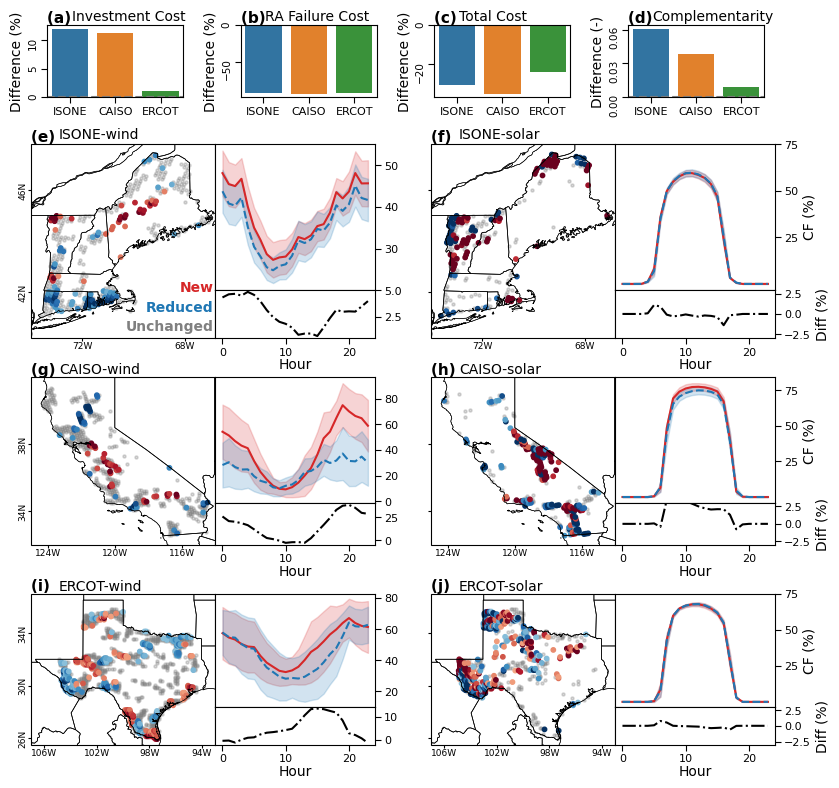

In [110]:
fig = plt.figure(figsize=(8,8))  
cc=0
sce='rcp85hotter'
tech='wind-onshore'
techlabels={'wind-onshore':'wind','solar-UPV':'solar'}
ax_map=[]
ax_se=[]
ax_diff=[]
x1locs=[0.01,0.51]
x1locs=[0.01,0.51]
x2locs=[0.24,0.74]
yhs=[0.25,0.25,0.23]
ylocs=[0.555,0.28,0.03]
for ir in range(3):
    ISO=ISOs[ir]
    for itech in range(2):
        tech=techs_RE[itech]
        xloc=x1locs[itech]
        ax_map.append(fig.add_axes((xloc, ylocs[ir], 0.23, yhs[ir]),projection=ccrs.PlateCarree()))
        setupmapbg(ax_map[len(ax_map)-1],ISO)

        locations_hist=pd.read_csv('%s/investment/Results_%s_%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_grouped.csv'%
                                (mdir, ISO, demandsce,ny, demandsce,ISO, cc, land, mdl,'historic', tech))
        locations_hist=locations_hist.set_index(['lat','lon'])

        locations_future=pd.read_csv('%s/investment/Results_%s_%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_grouped.csv'%
                                (mdir, ISO, demandsce,ny, demandsce,ISO, cc, land, mdl,'rcp85hotter', tech))
        locations_future=locations_future.set_index(['lat','lon'])

        locations_diff=(locations_future-locations_hist)
        thres=locations_hist[locations_hist['capacity']>0].mean().values[0]
        locations_diff_sig=locations_diff[(locations_diff['capacity']>thres)|(locations_diff['capacity']<-thres)]
        locations_diff_sig=locations_diff_sig.reset_index()
        
        locations_diff_nonsig=locations_diff[(locations_diff['capacity']<=thres)&(locations_diff['capacity']>=-thres)]
        locations_hista=locations_hist[(locations_hist['capacity']>0)]
        mean_location_hista=locations_hista['capacity'].quantile(0.3)
        locations_hista=locations_hista[(locations_hista['capacity']>mean_location_hista)]
        locations_diff_nonsig=pd.merge(locations_hista,locations_diff_nonsig,left_index=True,right_index=True,how='inner')
        locations_diff_nonsig=locations_diff_nonsig.reset_index()


        c2=ax_map[len(ax_map)-1].scatter(locations_diff_nonsig['lon'], locations_diff_nonsig['lat'],c='grey',s=5,alpha=0.3)
        c=ax_map[len(ax_map)-1].scatter(locations_diff_sig['lon'], locations_diff_sig['lat'],c=locations_diff_sig['capacity'],cmap=cmaps.MPL_RdBu_r,vmin=-200,vmax=200,s=10)
        setup_map_panel_ticks(ax_map[len(ax_map)-1],1,itech,2,f"",f"")
        setsubtitle(ax_map[len(ax_map)-1],"",ni=len(ax_map)-1+4)
        ax_map[len(ax_map)-1].text(0.15,1.05, f"{ISO}-{techlabels[tech]}",fontsize=10, ha='left', va='center', transform=ax_map[len(ax_map)-1].transAxes)
        CF_df_diff=pd.DataFrame()
        data=xr.open_dataset(f"{metdir}/{sce}/{techlabels[tech]}/{ISO}/{techlabels[tech]}_gen_cf_annual_monthly_dhourmean.nc")['capacity_factor']
        try:
            time=pd.Series(data['Time'].values).apply(parse_timestamp)
        except:
            try:
                time=pd.to_datetime(data['Time'].values)
            except:
                time=pd.to_datetime([str(data['Time'].values[i]) for i in range(len(data['Time'].values))])
        data['lat']=data['lat'].round(3)
        data['lon']=data['lon'].round(3)
        data['Time']=time
        data=data.stack(z=('y', 'x')).dropna(dim='z')
        CF_df=data.to_dataframe()[['capacity_factor', 'lat', 'lon']].reset_index()
        CF_df['Year']=CF_df['Time'].dt.year
        CF_df=CF_df[(CF_df['Year']>=2050) & (CF_df['Year']<2060)]
        CF_df['Month']=CF_df['Time'].dt.month
        CF_df['Hour']=CF_df['Time'].dt.hour
        CF_df['Hour']=CF_df['Hour']+tzs_shift[ISO]
        CF_df['Hour']=CF_df['Hour'].apply(lambda x: x+24 if x<0 else x)
        CF_df=CF_df.drop(columns=['Time','y','x'])
        CF_df['capacity_factor']=CF_df['capacity_factor']*100
        CF_df=CF_df.groupby(['lat','lon','Month','Hour']).mean().reset_index()
        CF_df_diff_tmp=pd.merge(CF_df,locations_diff_sig,left_on=['lat','lon'],right_on=['lat','lon'],how='right')
        CF_df_diff=pd.concat([CF_df_diff,CF_df_diff_tmp])

        xloc=x2locs[itech]
        locs=ax_map[len(ax_map)-1].get_position()
        ax_se.append(fig.add_axes((xloc, locs.y0+locs.height/4, 0.20, locs.height/4*3)))
        ax_diff.append(fig.add_axes((xloc, locs.y0, 0.20, locs.height/4)))
        for ice in range(2):
            if ice==0:
                a=CF_df_diff[CF_df_diff['capacity']>0]
            else:
                a=CF_df_diff[CF_df_diff['capacity']<0]
            a=a[(a['Month']>=6) & (a['Month']<=9)]
            a=a.groupby(['lat','lon','Hour']).mean().reset_index()
            cap=a['capacity'].sum()/1000
            if ice==0:
                sns.lineplot(data=a,x='Hour',y='capacity_factor',legend=False,ax=ax_se[len(ax_se)-1],c='tab:red',
                            errorbar=('sd', 1),linestyle='-')
                redline=a.copy()
            else:
                sns.lineplot(data=a,x='Hour',y='capacity_factor',legend=False,ax=ax_se[len(ax_se)-1],c='tab:blue',
                            errorbar=('sd', 1),linestyle='--')
                blueline=a.copy()
        redline=redline.groupby(['Hour']).mean().reset_index()
        blueline=blueline.groupby(['Hour']).mean().reset_index()
        diff=redline-blueline
        ax_diff[len(ax_diff)-1].plot(diff.index,diff['capacity_factor'],linestyle='-.',color='black')
        ax_se[len(ax_se)-1].yaxis.tick_right()
        ax_se[len(ax_se)-1].yaxis.set_label_position("right")
        ax_diff[len(ax_diff)-1].yaxis.tick_right()
        ax_diff[len(ax_diff)-1].yaxis.set_label_position("right")
        if itech==0:   
            ax_se[len(ax_se)-1].set_ylabel('')
            ax_diff[len(ax_diff)-1].set_ylabel("")
        else:
            ax_se[len(ax_se)-1].set_ylabel('CF (%)')
            ax_diff[len(ax_diff)-1].set_ylabel("Diff (%)")

        ax_diff[len(ax_diff)-1].set_xlabel('Hour',labelpad=0.2)
        ax_se[len(ax_se)-1].set_xlabel('')
        if itech==1:
            ax_diff[len(ax_diff)-1].set_ylim(-3,3)
            ax_se[len(ax_se)-1].set_yticks([25,50,75])

ax_map[0].text(0.99, 0.26, 'New', fontsize=10, ha='right', va='center', transform=ax_map[0].transAxes,color='tab:red',fontweight='bold')
ax_map[0].text(0.99, 0.16, 'Reduced', fontsize=10, ha='right', va='center', transform=ax_map[0].transAxes,color='tab:blue',fontweight='bold')
ax_map[0].text(0.99, 0.06, 'Unchanged', fontsize=10, ha='right', va='center', transform=ax_map[0].transAxes,color='grey',fontweight='bold')
sces=['historic','rcp85hotter']
vars=['wind_solar']


DF=pd.DataFrame()
for ISO in ISOs:
    for ise in range(1,3):
        cp_data_full=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
        if ise==0:
            tmpISO=get_df(cp_data_full,scenario='historic',cg=cc/100)
            suffix='./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonth' %(ny, demandsce,ISO, cc, land, mdl,'historic','historic')
        elif ise==1:
            tmpISO=get_df(cp_data_full,scenario=sce,cg=cc/100)
            suffix='./Analysis_drought/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_Load_hourmonth' % (ny, demandsce,ISO, cc, land, mdl,sce)
        else:
            tmpISO=get_df(cp_data_full,scenario='historic',cg=cc/100)
            suffix='./Analysis_drought/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonth' % (ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00)
        corr_tmp=pd.read_csv('%scorr_mean.csv' %(suffix),index_col='Unnamed: 0')
        tmpISO=tmpISO.reset_index().set_index('inv_ens_id')
        tmpISO=tmpISO.rename(columns={'total_cost':'Total','capacity_strg':'Storage','capacity_solar-UPV':'Solar','capacity_wind-onshore':'Wind','capacity_RE':'RE','capacity_CCGT':'CCGT'})      
        tmpISO=pd.merge(tmpISO,corr_tmp,left_index=True,right_index=True)

        # for tech in ['wind-onshore','solar-UPV']:
        #     if ise==0:
        #         std_tmp=pd.read_csv('./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_Load_sptialvar_mean.csv' %
        #                                     (ny, demandsce,ISO, cc, land, mdl,'historic', tech),index_col='id')
        #     elif ise==1:
        #         std_tmp=pd.read_csv('./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_Load_sptialvar_mean.csv' %
        #                                     (ny, demandsce,ISO, cc, land, mdl,sce, tech),index_col='id')
        #     else:
        #         std_tmp=pd.read_csv('./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%s_Load_sptialvar_mean.csv' %
        #                                     (ny, demandsce,ISO, cc, land, mdl,'historic',sce, tech),index_col='id')
        #     tmpISO=pd.merge(tmpISO,std_tmp,left_index=True,right_index=True)

        df=tmpISO.mean(numeric_only=True).to_frame().T
        df=df[vars]

        if ise==0:
            df_hist=df.copy()
        elif ise==1:
            df_new=df.copy()
        elif ise==2:
            df_dispatch=df.copy()
    dfa=(df_new-df_dispatch)
    print(df_dispatch)
    dfa['ISO']=ISO
    DF=pd.concat([DF,dfa])
                

change_all=pd.DataFrame()
for isoa in range(3):
    ISO=ISOs[isoa]
    for irr in range(2):
        if irr==0:
            sdata_tmp=pd.read_csv('%s/dispatch/Results_%s_%s4/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
            sdata_tmp=sdata_tmp[(sdata_tmp['test_sce']=='rcp85hotter')&(sdata_tmp['upper_bound_CCGT']==cc/100)]
            sdata_tmp['inv_cost']=sdata_tmp['total_cost']-sdata_tmp['LL_cost']
            hist=sdata_tmp.mean(numeric_only=True)
        elif irr==1:
            sdata_tmp=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
            sdata_tmp=sdata_tmp[(sdata_tmp['investment_sce']=='rcp85hotter')&(sdata_tmp['upper_bound_CCGT']==cc/100)]
            sdata_tmp['inv_cost']=sdata_tmp['total_cost']-sdata_tmp['LL_cost']
            newinv=sdata_tmp.mean(numeric_only=True)
    change=newinv/hist-1
    change=change.to_frame().T
    change['ISO']=ISO
    change_all=pd.concat([change_all,change])
change_all=change_all.set_index('ISO')
change_all=change_all[['inv_cost','LL_cost','total_cost']]*100

ax_bar=[]
vars=['inv_cost','LL_cost','total_cost']
vars_labels=['Investment Cost','RA Failure Cost','Total Cost','Complementarity']
for ic in range(4):
    yloc=0.86
    ax_bar.append(fig.add_axes((x1locs[0]+0.02+ic*0.242, yloc, 0.17, 0.09)))
    if ic<=2:
        var=vars[ic]
        sns.barplot(data=change_all,x='ISO',y=var,hue='ISO',ax=ax_bar[ic],legend=False,hue_order=ISOs)
        ax_bar[ic].set_ylabel('Difference (%)')
    else:
        sns.barplot(data=DF,x='ISO',y='wind_solar',hue='ISO',legend=False,hue_order=ISOs,ax=ax_bar[ic])
        ax_bar[ic].set_ylabel('Difference (-)')

    
    ax_bar[ic].axhline(0,linestyle='--',color='grey')
    ax_bar[ic].set_xlabel('')
    setsubtitle(ax_bar[ic],"",ni=ic)
    ax_bar[ic].text(0.18,1.12, vars_labels[ic],fontsize=10, ha='left', va='center', transform=ax_bar[ic].transAxes)
    ax_bar[ic].tick_params(axis='y', labelsize=7.5, pad=2.5, rotation=90)

ax_bar[3].set_yticks([0,0.03,0.06])
ax_bar[1].legend( loc='upper right', bbox_to_anchor=(0, -0.1), ncol=3, frameon=False)
plt.savefig(f'{figdir}/futuresiting.pdf', dpi=300, bbox_inches='tight')
plt.show()

   wind_solar
0    0.139402
   wind_solar
0   -0.007398
   wind_solar
0    0.051496


<Axes: xlabel='variable', ylabel='value'>

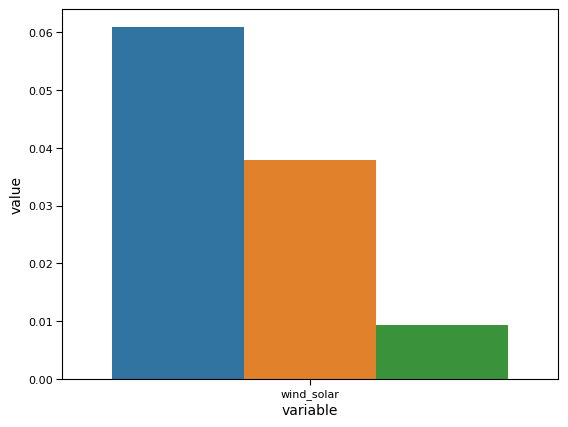

In [85]:
DF=pd.DataFrame()
for ISO in ISOs:
    for ise in range(1,3):
        cp_data_full=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
        if ise==0:
            tmpISO=get_df(cp_data_full,scenario='historic',cg=cc/100)
            suffix='./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonth' %(ny, demandsce,ISO, cc, land, mdl,'historic','historic')
        elif ise==1:
            tmpISO=get_df(cp_data_full,scenario=sce,cg=cc/100)
            suffix='./Analysis_drought/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_Load_hourmonth' % (ny, demandsce,ISO, cc, land, mdl,sce)
        else:
            tmpISO=get_df(cp_data_full,scenario='historic',cg=cc/100)
            suffix='./Analysis_drought/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonth' % (ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00)
        corr_tmp=pd.read_csv('%scorr_mean.csv' %(suffix),index_col='Unnamed: 0')
        tmpISO=tmpISO.reset_index().set_index('inv_ens_id')
        tmpISO=tmpISO.rename(columns={'total_cost':'Total','capacity_strg':'Storage','capacity_solar-UPV':'Solar','capacity_wind-onshore':'Wind','capacity_RE':'RE','capacity_CCGT':'CCGT'})
        tmpISO['RE']=tmpISO['Solar']+tmpISO['Wind']
        tmpISO['SolarR']=tmpISO['Solar']/tmpISO['Wind']         
        tmpISO=pd.merge(tmpISO,corr_tmp,left_index=True,right_index=True)

        for tech in ['wind-onshore','solar-UPV']:
            if ise==0:
                std_tmp=pd.read_csv('./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_Load_sptialvar_mean.csv' %
                                            (ny, demandsce,ISO, cc, land, mdl,'historic', tech),index_col='id')
            elif ise==1:
                std_tmp=pd.read_csv('./Analysis_drought/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_Load_sptialvar_mean.csv' %
                                            (ny, demandsce,ISO, cc, land, mdl,sce, tech),index_col='id')
            else:
                std_tmp=pd.read_csv('./Analysis_drought/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%s_Load_sptialvar_mean.csv' %
                                            (ny, demandsce,ISO, cc, land, mdl,'historic',sce, tech),index_col='id')
            tmpISO=pd.merge(tmpISO,std_tmp,left_index=True,right_index=True)

        df=tmpISO.mean(numeric_only=True).to_frame().T
        df=df[vars]

        if ise==0:
            df_hist=df.copy()
        elif ise==1:
            df_new=df.copy()
        elif ise==2:
            df_dispatch=df.copy()
    dfa=(df_new-df_dispatch)
    print(df_dispatch)
    dfa['ISO']=ISO
    DF=pd.concat([DF,dfa])
                
ax_bar=[]
DF=DF.set_index('ISO')
DF=DF.melt(ignore_index=False).reset_index()
sns.barplot(data=DF,x='variable',y='value',hue='ISO',legend=False,hue_order=ISOs)
# for ic in range(3):
#     yloc=0.005
#     ax_bar.append(fig.add_axes((x1locs[0]+ic*0.33, yloc, 0.27, 0.09)))
#     var=vars[ic]
#     sns.barplot(data=DF,x='ISO',y=var,hue='ISO',ax=ax_bar[ic],legend=False,hue_order=ISOs)
#     ax_bar[ic].set_ylabel('')
#     ax_bar[ic].axhline(0,linestyle='--',color='grey')
#     ax_bar[ic].set_xlabel('')
#     setsubtitle(ax_bar[ic],"",ni=ic+6)
#     ax_bar[ic].text(0.15,1.12, vars_labels[var],fontsize=11, ha='left', va='center', transform=ax_bar[ic].transAxes)
# ax_bar[1].legend( loc='upper right', bbox_to_anchor=(0, -0.1), ncol=3, frameon=False)

NameError: name 'locations_diff_sig' is not defined

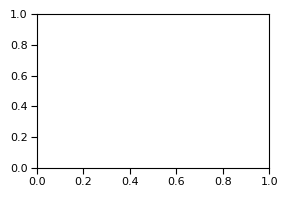

In [73]:
fig,ax_se=plt.subplots(1,1,figsize=(3,2))
cc=0
sce='rcp85hotter'
tech='wind-onshore'
techlabels={'wind-onshore':'wind','solar-UPV':'solar'}
ax_map=[]
ax_se=[]
ax_diff=[]
x1locs=[0.01,0.51]
x2locs=[0.24,0.74]
for ir in range(1):
    ISO=ISOs[ir]
    for itech in range(2):
        tech=techs_RE[itech]

        CF_df_diff=pd.DataFrame()
        data=xr.open_dataset(f"{metdir}/{sce}/{techlabels[tech]}/{ISO}/{techlabels[tech]}_gen_cf_annual_monthly_dhourmean.nc")['capacity_factor']
        try:
            time=pd.Series(data['Time'].values).apply(parse_timestamp)
        except:
            try:
                time=pd.to_datetime(data['Time'].values)
            except:
                time=pd.to_datetime([str(data['Time'].values[i]) for i in range(len(data['Time'].values))])
        data['lat']=data['lat'].round(3)
        data['lon']=data['lon'].round(3)
        data['Time']=time
        data=data.stack(z=('y', 'x')).dropna(dim='z')
        CF_df=data.to_dataframe()[['capacity_factor', 'lat', 'lon']].reset_index()
        CF_df['Year']=CF_df['Time'].dt.year
        CF_df=CF_df[(CF_df['Year']>=2050) & (CF_df['Year']<2060)]
        CF_df['Month']=CF_df['Time'].dt.month
        CF_df['Hour']=CF_df['Time'].dt.hour
        CF_df['Hour']=CF_df['Hour']+tzs_shift[ISO]
        CF_df['Hour']=CF_df['Hour'].apply(lambda x: x+24 if x<0 else x)
        CF_df=CF_df.drop(columns=['Time','y','x'])
        CF_df['capacity_factor']=CF_df['capacity_factor']*100
        CF_df=CF_df.groupby(['lat','lon','Month','Hour']).mean().reset_index()
        CF_df_diff_tmp=pd.merge(CF_df,locations_diff_sig,left_on=['lat','lon'],right_on=['lat','lon'],how='right')
        CF_df_diff=pd.concat([CF_df_diff,CF_df_diff_tmp])

        xloc=x2locs[itech]
        locs=ax_map[len(ax_map)-1].get_position()
        
        for ice in range(2):
            if ice==0:
                a=CF_df_diff[CF_df_diff['capacity']>0]
            else:
                a=CF_df_diff[CF_df_diff['capacity']<0]
            a=a[(a['Month']>=6) & (a['Month']<=9)]
            a=a.groupby(['lat','lon','Hour']).mean().reset_index()
            cap=a['capacity'].sum()/1000
            if ice==0:
                sns.lineplot(data=a,x='Hour',y='capacity_factor',legend=False,ax=ax_se[len(ax_se)-1],c='tab:red',
                            errorbar=('sd', 1),linestyle='-')
                redline=a.copy()
            else:
                sns.lineplot(data=a,x='Hour',y='capacity_factor',legend=False,ax=ax_se[len(ax_se)-1],c='tab:blue',
                            errorbar=('sd', 1),linestyle='--')
                blueline=a.copy()
        redline=redline.groupby(['Hour']).mean().reset_index()
        blueline=blueline.groupby(['Hour']).mean().reset_index()
        diff=redline-blueline
        ax_diff[len(ax_diff)-1].plot(diff.index,diff['capacity_factor'],linestyle='-.',color='black')
        ax_se.yaxis.tick_right()
        ax_se.yaxis.set_label_position("right")

        ax_se.set_ylabel('CF (%)')
        ax_diff[len(ax_diff)-1].set_ylabel("Diff (%)")

        ax_se.set_xlabel('Hour',labelpad=0.2)

        if itech==1:

            ax_se.set_yticks([25,50,75])


sces=['historic','rcp85hotter']
vars=['cf_wind-onshore','cf_solar-UPV','wind_solar']
vars_labels={'cf_solar-UPV':'Capacity Factor-Solar','cf_wind-onshore':'Capacity Factor-Wind',
             'solar_sv':'Spatail Variability-Solar','wind_sv':'Spatail Variability-Wind','wind_solar':'Complementarity'}


#plt.savefig('./figures/futuresiting.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [66]:
tmp_test

total_cost                 3.104470e+10
LL_cost                    1.286503e+10
total_cost_strg            6.286851e+09
total_cost_solar-UPV       4.656834e+09
total_cost_wind-onshore    7.235978e+09
total_LL                   5.146014e+05
inv_ens_id                 6.050000e+01
dtype: float64

In [67]:
tmp_op

total_cost                 2.119207e+10
LL_cost                    8.250854e+08
total_cost_strg            7.752461e+09
total_cost_solar-UPV       6.036490e+09
total_cost_wind-onshore    6.578035e+09
total_LL                   3.300342e+04
inv_ens_id                 6.050000e+01
dtype: float64

In [77]:
sdata_tmp=pd.read_csv('%s/dispatch/Results_%s_%s4/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
sdata_tmp=sdata_tmp[(sdata_tmp['test_sce']=='rcp85hotter')&(sdata_tmp['upper_bound_CCGT']==cc/100)]

In [ ]:
sdata_tmp

,num_periods,Sol_time,weather_model,landres_allowed,demand_data,region,total_cost,prod_strg,total_cost_LL,total_LL,...,total_cost_CCGT,upper_bound_CCGT,total_cost_solar-UPV,prod_solar-UPV,load_solar-UPV,cell_size_solar-UPV,total_cost_wind-onshore,prod_wind-onshore,load_wind-onshore,cell_size_wind-onshore
189,78840,19.0,TGW,0,mlp,ISONE,2.467882e+10,4.202842e+06,4.693408e+09,1.877363e+05,...,0.0,0.0,5.581571e+09,8.117090e+07,3.180543e+07,12.0,7.427670e+09,2.357095e+08,9.373777e+07,12.0
219,78840,19.0,TGW,0,mlp,ISONE,2.511226e+10,3.936773e+06,5.725380e+09,2.290152e+05,...,0.0,0.0,5.472724e+09,7.973296e+07,3.126361e+07,12.0,7.277321e+09,2.330994e+08,9.419174e+07,12.0
186,78840,17.0,TGW,0,mlp,ISONE,2.531221e+10,4.053291e+06,5.373276e+09,2.149310e+05,...,0.0,0.0,5.456955e+09,7.944542e+07,3.056157e+07,12.0,7.741766e+09,2.431514e+08,9.492831e+07,12.0
204,78840,17.0,TGW,0,mlp,ISONE,2.541697e+10,4.099776e+06,5.829830e+09,2.331932e+05,...,0.0,0.0,5.460511e+09,7.887544e+07,3.114321e+07,12.0,7.187000e+09,2.303073e+08,9.433639e+07,12.0
218,78840,18.0,TGW,0,mlp,ISONE,2.554242e+10,4.727887e+06,6.252996e+09,2.501198e+05,...,0.0,0.0,5.588948e+09,8.150780e+07,3.394267e+07,12.0,6.833835e+09,2.177012e+08,9.163099e+07,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,78840,18.0,TGW,0,mlp,ISONE,3.989659e+10,5.067919e+06,2.303453e+10,9.213814e+05,...,0.0,0.0,4.632747e+09,6.871962e+07,3.198646e+07,12.0,6.303505e+09,1.998063e+08,9.297720e+07,12.0
141,78840,20.0,TGW,0,mlp,ISONE,4.111792e+10,4.506811e+06,2.430996e+10,9.723984e+05,...,0.0,0.0,4.032611e+09,5.984899e+07,2.879770e+07,12.0,6.551705e+09,2.072248e+08,9.601557e+07,12.0
122,78840,16.0,TGW,0,mlp,ISONE,4.365694e+10,4.608326e+06,2.697597e+10,1.079039e+06,...,0.0,0.0,3.966780e+09,5.867975e+07,2.874766e+07,12.0,6.450069e+09,2.025829e+08,9.597687e+07,12.0
123,78840,16.0,TGW,0,mlp,ISONE,4.458838e+10,4.967845e+06,2.816394e+10,1.126558e+06,...,0.0,0.0,4.173507e+09,6.162343e+07,3.048422e+07,12.0,6.244592e+09,1.988803e+08,9.425656e+07,12.0


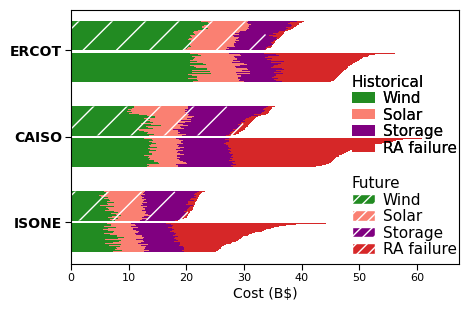

In [25]:
cc=0
fig,ax_bar = plt.subplots(1,1,figsize=(5,3.3),frameon=False)
var='total_cost'
tmp=pd.DataFrame()
nsce=2
maxsce=120
techs_all_ll=['wind-onshore', 'solar-UPV', 'CCGT', 'strg','LL']
for ir in range(3):
    ISO=ISOs[ir]
    for irr in range(2):
        if irr==0:
            sdata_tmp=pd.read_csv('%s/dispatch/Results_%s_%s4/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
            sdata_tmp=sdata_tmp[(sdata_tmp['test_sce']=='rcp85hotter')&(sdata_tmp['upper_bound_CCGT']==cc/100)]
        elif irr==1:
            sdata_tmp=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
            sdata_tmp=sdata_tmp[(sdata_tmp['investment_sce']=='rcp85hotter')&(sdata_tmp['upper_bound_CCGT']==cc/100)]
        sdata_tmp=sdata_tmp.rename(columns={'LL_cost':'total_cost_LL'})
        cp_data=sdata_tmp.sort_values(by=['total_cost'],ascending=True)
        cu1=np.zeros(120)
        cp_data=cp_data[['total_cost','total_cost_LL','total_cost_wind-onshore','total_cost_solar-UPV','total_cost_CCGT','total_cost_strg']]
        cp_data=cp_data/(1e9)
        for tech in techs_all_ll:
            if (cc==0)&(tech=='CCGT'):
                continue
            toplot=cp_data[f'{var}_{tech}']
            if irr==0:
                p = ax_bar.barh(np.arange((maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr,(maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr+maxsce,1),toplot, 1,
                                color=colorpalattes[tech],
                                left=cu1)
            else:
                p = ax_bar.barh(np.arange((maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr,(maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr+maxsce,1),toplot, 1,
                                facecolor=colorpalattes[tech],left=cu1)
            meanr=toplot/cp_data['total_cost']*100
            meanr=meanr.mean()
            cu1+=toplot.values
    ymin=np.arange((maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr,(maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr+maxsce,1).min()
    ymax=np.arange((maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr,(maxsce*nsce+110*(nsce-1))*ir+(maxsce+10)*irr+maxsce,1).max()
    ax_bar.add_patch(Polygon([(0, ymin), (0, ymax), (cu1.mean()*0.85, ymax), (cu1.mean(), ymin)],linewidth=0,    
                                        hatch='/', facecolor='none', edgecolor='white', zorder=2,alpha=1))
ax_bar.set_ylabel('')
ax_bar.set_yticks([125,475,830])
ax_bar.set_yticklabels(ISOs,fontsize=10,fontweight='bold')

# ax_bar.set_xlim([0,12])
#ax_bar.set_xticks(np.arange(0,15,5))
ax_bar.set_xlabel('Cost (B$)',fontsize=10)

colors = {'wind-onshore': 'forestgreen', 'solar-UPV': 'salmon', 'strg': 'purple','LL':'tab:red'}
# if cc==0:
#     colors.pop('CCGT')
legend_patched = [mpatches.Patch(facecolor=colors[key], hatch='///',edgecolor='white', label=tech_names[key]) for key in colors.keys()]
legend_solid = [mpatches.Patch(facecolor=colors[key], label=tech_names[key]) for key in colors.keys()]
lg_patched = ax_bar.legend(handles=legend_patched,loc='upper right', title="Future", labelspacing=0.1,fontsize=11,title_fontsize=11,
                            frameon=False,handlelength=1.5,alignment='left',handletextpad=0.5,bbox_to_anchor=(1.03, 0.4))
lg_solid = ax_bar.legend(handles=legend_solid, loc='upper right',title="Historical", labelspacing=0.1,fontsize=11,title_fontsize=11,
                            frameon=False, handlelength=1.5,alignment='left',handletextpad=0.5,bbox_to_anchor=(1.03, 0.8))
ax_bar.add_artist(lg_patched)
ax_bar.add_artist(lg_solid)

In [ ]:
cc=0
var='total_cost'
tmp=pd.DataFrame()
nsce=2
maxsce=120
techs_all_ll=['wind-onshore', 'solar-UPV', 'CCGT', 'strg','LL']
change_all=pd.DataFrame()
for ir in range(3):
    ISO=ISOs[ir]
    for irr in range(2):
        if irr==0:
            sdata_tmp=pd.read_csv('%s/dispatch/Results_%s_%s4/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
            sdata_tmp=sdata_tmp[(sdata_tmp['test_sce']=='rcp85hotter')&(sdata_tmp['upper_bound_CCGT']==cc/100)]
            sdata_tmp['inv_cost']=sdata_tmp['total_cost']-sdata_tmp['LL_cost']
            hist=sdata_tmp.mean(numeric_only=True)
        elif irr==1:
            sdata_tmp=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
            sdata_tmp=sdata_tmp[(sdata_tmp['investment_sce']=='rcp85hotter')&(sdata_tmp['upper_bound_CCGT']==cc/100)]
            sdata_tmp['inv_cost']=sdata_tmp['total_cost']-sdata_tmp['LL_cost']
            newinv=sdata_tmp.mean(numeric_only=True)
    change=newinv/hist-1
    change=change.to_frame().T
    change['ISO']=ISO
    change_all=pd.concat([change_all,change])
change_all=change_all.set_index('ISO')
change_all=change_all[['inv_cost','LL_cost','total_cost']]*100




In [47]:
change_all=change_all.reset_index().melt(id_vars=['ISO'],value_vars=['inv_cost','LL_cost','total_cost'])


In [50]:
change_all

,ISO,variable,value
0,ISONE,inv_cost,12.031703
1,CAISO,inv_cost,11.189742
2,ERCOT,inv_cost,0.989232
3,ISONE,LL_cost,-93.371486
4,CAISO,LL_cost,-94.186828
5,ERCOT,LL_cost,-93.501943
6,ISONE,total_cost,-30.806326
7,CAISO,total_cost,-35.188553
8,ERCOT,total_cost,-24.289061


<Axes: xlabel='variable', ylabel='value'>

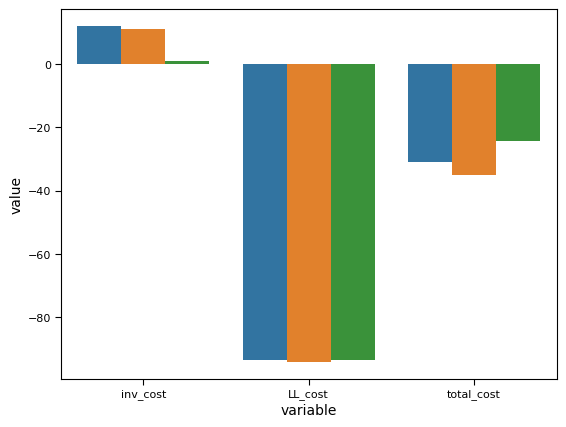

In [52]:
sns.barplot(data=change_all,x='variable',y='value',hue='ISO',legend=False,hue_order=ISOs)

FileNotFoundError: [Errno 2] No such file or directory: '/orcd/nese/mhowland/001/lyqiu/GODEEP/optimization_free//investment/Results_ISONE_mlp/sub3yrs_demand_mlp_ISONE_cc_0_landr_0_TGW_historic_wind-onshore_locations_grouped.csv'

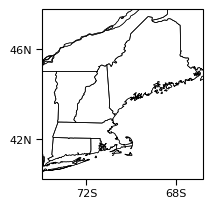

In [46]:
fig = plt.figure(figsize=(7,7))  
cc=0
sce='rcp85hotter'
tech='wind-onshore'
techlabels={'wind-onshore':'wind','solar-UPV':'solar'}
ax_map=[]
ax_se=[]
ax_diff=[]
x1locs=[0.01,0.51]
x2locs=[0.24,0.74]
for ir in range(1):
    ISO=ISOs[ir]
    for itech in range(2):
        tech=techs_RE[itech]
        xloc=x1locs[itech]
        if ir<2:
            ax_map.append(fig.add_axes((xloc, 1-0.295*(ir+1), 0.23, 0.28),projection=ccrs.PlateCarree()))
        else:
            ax_map.append(fig.add_axes((xloc, 1-0.295*(ir+1)+0.02, 0.23, 0.28),projection=ccrs.PlateCarree()))
        setupmapbg(ax_map[len(ax_map)-1],ISO)

        locations_hist=pd.read_csv('%s/investment/Results_%s_%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_grouped.csv'%
                                (mdir, ISO, demandsce,ny, demandsce,ISO, cc, land, mdl,'historic', tech))
        locations_hist=locations_hist.set_index(['lat','lon'])

        locations_future=pd.read_csv('%s/investment/Results_%s_%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_grouped.csv'%
                                (mdir, ISO, demandsce,ny, demandsce,ISO, cc, land, mdl,'rcp85hotter', tech))
        locations_future=locations_future.set_index(['lat','lon'])

        locations_diff=(locations_future-locations_hist)
        thres=locations_hist[locations_hist['capacity']>0].mean().values[0]
        locations_diff_sig=locations_diff[(locations_diff['capacity']>thres)|(locations_diff['capacity']<-thres)]
        locations_diff_sig=locations_diff_sig.reset_index()
        
        locations_diff_nonsig=locations_diff[(locations_diff['capacity']<=thres)&(locations_diff['capacity']>=-thres)]
        locations_hista=locations_hist[(locations_hist['capacity']>0)]
        mean_location_hista=locations_hista['capacity'].quantile(0.3)
        locations_hista=locations_hista[(locations_hista['capacity']>mean_location_hista)]
        locations_diff_nonsig=pd.merge(locations_hista,locations_diff_nonsig,left_index=True,right_index=True,how='inner')
        locations_diff_nonsig=locations_diff_nonsig.reset_index()


        c2=ax_map[len(ax_map)-1].scatter(locations_diff_nonsig['lon'], locations_diff_nonsig['lat'],c='grey',s=5,alpha=0.3)
        c=ax_map[len(ax_map)-1].scatter(locations_diff_sig['lon'], locations_diff_sig['lat'],c=locations_diff_sig['capacity'],cmap=cmaps.MPL_RdBu_r,vmin=-200,vmax=200,s=10)
        setup_map_panel_ticks(ax_map[len(ax_map)-1],1,itech,2,f"",f"")
        #setsubtitle(ax_map[len(ax_map)-1],"",ni=len(ax_map)-1)
        #ax_map[len(ax_map)-1].text(0.15,1.05, f"{ISO}-{techlabels[tech]}",fontsize=11, ha='left', va='center', transform=ax_map[len(ax_map)-1].transAxes)
        CF_df_diff=pd.DataFrame()
        data=xr.open_dataset(f"{metdir}/{sce}/{techlabels[tech]}/{ISO}/{techlabels[tech]}_gen_cf_annual_monthly_dhourmean.nc")['capacity_factor']
        try:
            time=pd.Series(data['Time'].values).apply(parse_timestamp)
        except:
            try:
                time=pd.to_datetime(data['Time'].values)
            except:
                time=pd.to_datetime([str(data['Time'].values[i]) for i in range(len(data['Time'].values))])
        data['lat']=data['lat'].round(3)
        data['lon']=data['lon'].round(3)
        data['Time']=time
        data=data.stack(z=('y', 'x')).dropna(dim='z')
        CF_df=data.to_dataframe()[['capacity_factor', 'lat', 'lon']].reset_index()
        CF_df['Year']=CF_df['Time'].dt.year
        CF_df=CF_df[(CF_df['Year']>=2050) & (CF_df['Year']<2060)]
        CF_df['Month']=CF_df['Time'].dt.month
        CF_df['Hour']=CF_df['Time'].dt.hour
        CF_df['Hour']=CF_df['Hour']+tzs_shift[ISO]
        CF_df['Hour']=CF_df['Hour'].apply(lambda x: x+24 if x<0 else x)
        CF_df=CF_df.drop(columns=['Time','y','x'])
        CF_df['capacity_factor']=CF_df['capacity_factor']*100
        CF_df=CF_df.groupby(['lat','lon','Month','Hour']).mean().reset_index()
        CF_df_diff_tmp=pd.merge(CF_df,locations_diff_sig,left_on=['lat','lon'],right_on=['lat','lon'],how='right')
        CF_df_diff=pd.concat([CF_df_diff,CF_df_diff_tmp])

        xloc=x2locs[itech]
        locs=ax_map[len(ax_map)-1].get_position()
        ax_se.append(fig.add_axes((xloc, locs.y0+locs.height/4, 0.20, locs.height/4*3)))
        ax_diff.append(fig.add_axes((xloc, locs.y0, 0.20, locs.height/4)))
        for ice in range(2):
            if ice==0:
                a=CF_df_diff[CF_df_diff['capacity']>0]
            else:
                a=CF_df_diff[CF_df_diff['capacity']<0]
            a=a[(a['Month']>=6) & (a['Month']<=9)]
            a=a.groupby(['lat','lon','Hour']).mean().reset_index()
            cap=a['capacity'].sum()/1000
            if ice==0:
                sns.lineplot(data=a,x='Hour',y='capacity_factor',legend=False,ax=ax_se[len(ax_se)-1],c='tab:red',
                            errorbar=('sd', 1),linestyle='-')
                redline=a.copy()
            else:
                sns.lineplot(data=a,x='Hour',y='capacity_factor',legend=False,ax=ax_se[len(ax_se)-1],c='tab:blue',
                            errorbar=('sd', 1),linestyle='--')
                blueline=a.copy()
        redline=redline.groupby(['Hour']).mean().reset_index()
        blueline=blueline.groupby(['Hour']).mean().reset_index()
        diff=redline-blueline
        ax_diff[len(ax_diff)-1].plot(diff.index,diff['capacity_factor'],linestyle='-.',color='black')
        ax_se[len(ax_se)-1].yaxis.tick_right()
        ax_se[len(ax_se)-1].yaxis.set_label_position("right")
        ax_diff[len(ax_diff)-1].yaxis.tick_right()
        ax_diff[len(ax_diff)-1].yaxis.set_label_position("right")
        if itech==0:   
            ax_se[len(ax_se)-1].set_ylabel('')
            ax_diff[len(ax_diff)-1].set_ylabel("")
        else:
            ax_se[len(ax_se)-1].set_ylabel('Capacity Factor (%)')
            ax_diff[len(ax_diff)-1].set_ylabel("Difference (%)")

        ax_diff[len(ax_diff)-1].set_xlabel('Hour',labelpad=0.2)
        ax_se[len(ax_se)-1].set_xlabel('')

ax_map[0].text(0.99, 0.26, 'New', fontsize=10, ha='right', va='center', transform=ax_map[0].transAxes,color='tab:red',fontweight='bold')
ax_map[0].text(0.99, 0.16, 'Reduced', fontsize=10, ha='right', va='center', transform=ax_map[0].transAxes,color='tab:blue',fontweight='bold')
ax_map[0].text(0.99, 0.06, 'Unchanged', fontsize=10, ha='right', va='center', transform=ax_map[0].transAxes,color='grey',fontweight='bold')
sces=['historic','rcp85hotter']
vars=['cf_solar-UPV','cf_wind-onshore','wind_solar']
vars_labels={'cf_solar-UPV':'Capacity Factor-Solar','cf_wind-onshore':'Capacity Factor-Wind',
             'solar_sv':'Spatail Variability-Solar','wind_sv':'Spatail Variability-Wind','wind_solar':'Complementarity'}

DF=pd.DataFrame()
for ISO in ISOs:
    for ise in range(3):
        cp_data_full=pd.read_csv('%s/investment/Results_%s_%s/TGW_%s_General_Results.csv'%(mdir,ISO,demandsce,ISO))
        if ise==0:
            tmpISO=get_df(cp_data_full,scenario='historic',cg=cc/100)
            suffix='./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_Load_hourmonth' %(ny, demandsce,ISO, cc, land, mdl,'historic') 
        elif ise==1:
            tmpISO=get_df(cp_data_full,scenario=sce,cg=cc/100)
            suffix='./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_Load_hourmonth' % (ny, demandsce,ISO, cc, land, mdl,sce)
        else:
            tmpISO=get_df(cp_data_full,scenario='historic',cg=cc/100)
            suffix='./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%.3f_Load_hourmonth' % (ny, demandsce,ISO, cc, land, mdl,'historic',sce, 1.00)
        mean_tmp=pd.read_csv('%smean_mean.csv' %(suffix),index_col='id')
        corr_tmp=pd.read_csv('%scorr_mean.csv' %(suffix),index_col='Unnamed: 0')
        tmpISO=tmpISO.reset_index().set_index('inv_ens_id')
        tmpISO=tmpISO.rename(columns={'total_cost':'Total','capacity_strg':'Storage','capacity_solar-UPV':'Solar','capacity_wind-onshore':'Wind','capacity_RE':'RE','capacity_CCGT':'CCGT'})
        tmpISO['RE']=tmpISO['Solar']+tmpISO['Wind']
        tmpISO['SolarR']=tmpISO['Solar']/tmpISO['Wind']
        mean_tmp=mean_tmp[['cf_solar-UPV','cf_wind-onshore']]
        tmpISO=pd.merge(tmpISO,mean_tmp,left_index=True,right_index=True)            
        tmpISO=pd.merge(tmpISO,corr_tmp,left_index=True,right_index=True)

        for tech in ['wind-onshore','solar-UPV']:
            if ise==0:
                std_tmp=pd.read_csv('./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_Load_sptialvar_mean.csv' %
                                            (ny, demandsce,ISO, cc, land, mdl,'historic', tech),index_col='id')
            elif ise==1:
                std_tmp=pd.read_csv('./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_Load_sptialvar_mean.csv' %
                                            (ny, demandsce,ISO, cc, land, mdl,sce, tech),index_col='id')
            else:
                std_tmp=pd.read_csv('./Analysis_drought_free/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_test_%s_%s_Load_sptialvar_mean.csv' %
                                            (ny, demandsce,ISO, cc, land, mdl,'historic',sce, tech),index_col='id')
            tmpISO=pd.merge(tmpISO,std_tmp,left_index=True,right_index=True)

        df=tmpISO.mean(numeric_only=True).to_frame().T
        df=df[vars]

        if ise==0:
            df_hist=df.copy()
        elif ise==1:
            df_new=df.copy()
        elif ise==2:
            df_dispatch=df.copy()
    dfa=df_new-df_dispatch
    print(df_dispatch)
    dfa['ISO']=ISO
    DF=pd.concat([DF,dfa])
                
ax_bar=[]
for ic in range(3):
    yloc=0.005
    ax_bar.append(fig.add_axes((x1locs[0]+ic*0.33, yloc, 0.27, 0.09)))
    var=vars[ic]
    sns.barplot(data=DF,x='ISO',y=var,hue='ISO',ax=ax_bar[ic],legend=False,hue_order=ISOs)
    ax_bar[ic].set_ylabel('')
    ax_bar[ic].axhline(0,linestyle='--',color='grey')
    ax_bar[ic].set_xlabel('')
    setsubtitle(ax_bar[ic],"",ni=ic+6)
    ax_bar[ic].text(0.15,1.12, vars_labels[var],fontsize=11, ha='left', va='center', transform=ax_bar[ic].transAxes)
ax_bar[1].legend( loc='upper right', bbox_to_anchor=(0, -0.1), ncol=3, frameon=False)
# plt.savefig('./figures/futuresiting.pdf', dpi=300, bbox_inches='tight')
plt.show()

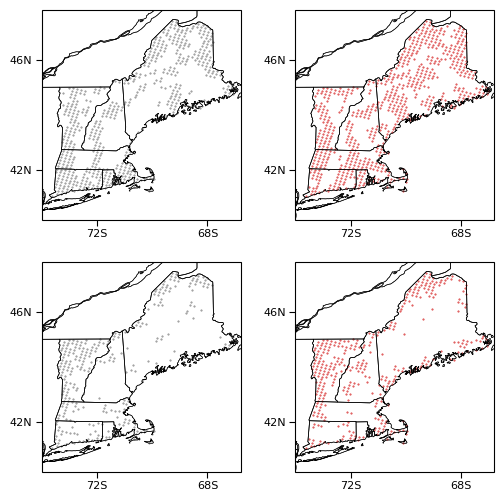

In [57]:
fig,ax_map=plt.subplots(2,2,figsize=(6,6),subplot_kw={'projection': ccrs.PlateCarree()})
cc=0
sce='historic'

techlabels={'wind-onshore':'wind','solar-UPV':'solar'}

ISO='ISONE'
for ir in range(2):
    tech=techs_RE[ir]       
    setupmapbg(ax_map[ir][0],ISO)
    setupmapbg(ax_map[ir][1],ISO)
    locations_hist=pd.read_csv('%s/investment/Results_%s_%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_grouped.csv'%
                            (mdir, ISO, demandsce,ny, demandsce,ISO, cc, land, mdl,'historic', tech))
    locations_hist=locations_hist.set_index(['lat','lon'])

    locations_future=pd.read_csv('%s/investment/Results_%s_%s/sub%dyrs_demand_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_grouped.csv'%
                            (mdir, ISO, demandsce,ny, demandsce,ISO, cc, land, mdl,'rcp85hotter', tech))
    locations_future=locations_future.set_index(['lat','lon'])
    locations_hist=locations_hist.reset_index()
    locations_hist=locations_hist[(locations_hist['capacity']>0)]
    locations_future=locations_future.reset_index()
    locations_future=locations_future[(locations_future['capacity']>0)]
    c=ax_map[ir][0].scatter(locations_hist['lon'], locations_hist['lat'],c='grey',s=0.2)
    c=ax_map[ir][1].scatter(locations_future['lon'], locations_future['lat'],c='tab:red',s=0.2)
        # setup_map_panel_ticks(ax_map[ir],1,0,2,f"",f"")

plt.savefig('./figures/futuresiting_hist.pdf', dpi=300, bbox_inches='tight',transparent=True)
plt.show()

In [88]:
CF_df=data.to_dataframe()[['capacity_factor', 'lat', 'lon']].reset_index()
CF_df['Year']=CF_df['Time'].dt.year
# if scea=='rcp85hotter':
#     CF_df=CF_df[(CF_df['Year']>=2050) & (CF_df['Year']<2060)]
# else:
#     CF_df=CF_df[(CF_df['Year']>=2010) & (CF_df['Year']<2020)]
# CF_df['Month']=CF_df['Time'].dt.month
# CF_df['Hour']=CF_df['Time'].dt.hour
# CF_df['Hour']=CF_df['Hour']+tzs_shift[ISO]
# #Hour<0 +24
# CF_df['Hour']=CF_df['Hour'].apply(lambda x: x+24 if x<0 else x)
# CF_df=CF_df.drop(columns=['Time','y','x'])
# CF_df=CF_df.groupby(['lat','lon','Month','Hour']).mean().reset_index()
# CF_df['sce']=scea